#  <center> Problem Set 4 <center>
<center> Spring 2022 <center>
<center> 3.C01/3.C51, 10.C01/10.C51, 20.C01/20.C51 <center>
<center> Due: 10 pm ET on Thursday, Apr 7, 2021 <center>

## Part 1: Predicting molecular properties with Graph Convolutional Nets 

### 1.1 (5 points) Install and try out RDkit

This is a hack to install RDKit, without needing to install conda (which might take minutes). If you have anaconda installed, you can install RDKit from anaconda.

In [ ]:
url = 'https://anaconda.org/rdkit/rdkit/2018.09.1.0/download/linux-64/rdkit-2018.09.1.0-py36h71b666b_1.tar.bz2'
!curl -L $url | tar xj lib
!mv lib/python3.6/site-packages/rdkit /usr/local/lib/python3.7/dist-packages/

x86 = '/usr/lib/x86_64-linux-gnu'
!mv lib/*.so.* $x86/
!ln -s $x86/libboost_python3-py36.so.1.65.1 $x86/libboost_python3.so.1.65.1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3785    0  3785    0     0   9164      0 --:--:-- --:--:-- --:--:--  9186
100 20.2M  100 20.2M    0     0  3294k      0  0:00:06  0:00:06 --:--:-- 3163k


In [ ]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import sys
import torch 
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*') # turn off RDKit warning message 

Optional: mount your Google Drive to save your model and files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
mydrive = '/content/drive/MyDrive'

Mounted at /content/drive


Example: make a Mol object.

In [ ]:
dopamine_mol = Chem.MolFromSmiles("C1=CC(=C(C=C1CCN)O)O") # Dopamine 
caffeine_mol = Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C") # Caffeine 
asprin_mol = Chem.MolFromSmiles("CC(=O)OC1=CC=CC=C1C(=O)O") # Asprin
vitamin_c_mol = Chem.MolFromSmiles("C(C(C1C(=C(C(=O)O1)O)O)O)O") # Vitamin C

Arrange molecules in a grid image.

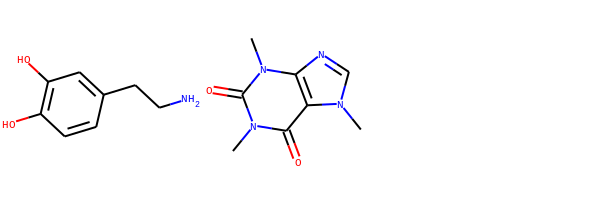

In [ ]:
# Arrange molecules in a grid image
Draw.MolsToGridImage([dopamine_mol, caffeine_mol])

Use RDKit to visualize molecule line drawings

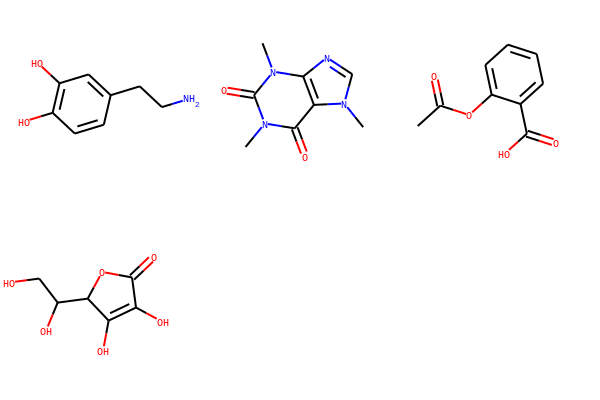

In [ ]:
################ Code #################
Draw.MolsToGridImage([dopamine_mol, caffeine_mol, asprin_mol, vitamin_c_mol])



### 1.2 (10 points) Construct Molecular Graph Datasets and DataLoaders

In [ ]:
! wget https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps4/data/qm9.csv

--2022-04-08 15:55:48--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps4/data/qm9.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30584525 (29M) [text/plain]
Saving to: ‘qm9.csv’

qm9.csv             100%[===================>]  29.17M  --.-KB/s    in 0.1s    

2022-04-08 15:55:49 (220 MB/s) - ‘qm9.csv’ saved [30584525/30584525]



A SMILES to graph conversion function.

In [ ]:
def smiles2graph(smiles):
    '''
    Transform smiles into a list of atomic numbers and an edge array
    
    Args: 
        smiles (str): SMILES strings
    
    Returns: 
        z(np.array), A (np.array): list of atomic numbers, edge array
    '''
    
    mol = Chem.MolFromSmiles( smiles ) # no hydrogen 
    z = np.array( [atom.GetAtomicNum() for atom in mol.GetAtoms()] )
    A = np.stack(Chem.GetAdjacencyMatrix(mol)).nonzero()
    
    return z, A


Read in the DataFrame, shuffle its rows, and store its properties as lists.

In [233]:
import torch
from sklearn.utils import shuffle

df = pd.read_csv("qm9.csv")
df = shuffle(df).reset_index()

################ Code #################
AtomicNum_list = []
Edge_list = []
y_list = []
Natom_list = []

all_smiles = df.loc[:,'smiles']
y_list = list(df.loc[:,'alpha'])

for i in range(0,len(y_list)):
   y_list[i] = torch.Tensor([y_list[i]]).type(torch.FloatTensor)






for smiles in all_smiles:
  z,A = smiles2graph(smiles)
  AtomicNum_list.append(torch.from_numpy(z).type(torch.LongTensor))
  Edge_list.append(torch.tensor(A).type(torch.LongTensor))
  Natom_list.append(int(len(z)))



A GraphDataset class for you to store graphs in PyTorch.

In [234]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self,
                 AtomicNum_list, 
                 Edge_list, 
                 Natom_list, 
                 y_list):
        
        '''
        GraphDataset object
        
        Args: 
            z_list (list of torch.LongTensor)
            a_list (list of torch.LongTensor)
            N_list (list of int)
            y_list (list of torch.FloatTensor)

        '''
        self.AtomicNum_list = AtomicNum_list # atomic number
        self.Edge_list = Edge_list # edge list 
        self.Natom_list = Natom_list # Number of atoms 
        self.y_list = y_list # properties to predict 

    def __len__(self):
        return len(self.Natom_list)

    def __getitem__(self, idx):
        
        AtomicNum = torch.LongTensor(self.AtomicNum_list[idx])
        Edge = torch.LongTensor(self.Edge_list[idx])
        Natom = self.Natom_list[idx]
        y = torch.Tensor(self.y_list[idx])
        
        return AtomicNum, Edge, Natom, y

Split your dataset into train, validation, and test and define the GraphDataset class for each.

In [235]:
################ Code #################
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X = np.transpose(np.array([AtomicNum_list, Edge_list, Natom_list]))

y = y_list


X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.125)


train_dataset = GraphDataset(X_train[:,0], X_train[:,1], X_train[:,2], y_train)
val_dataset = GraphDataset(X_val[:,0], X_val[:,1], X_val[:,2], y_val)
test_dataset = GraphDataset(X_test[:,0], X_test[:,1], X_test[:,2], y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


A graph collation function to batch multiple graphs into one batch.

In [236]:
def collate_graphs(batch):
    '''Batch multiple graphs into one batched graph
    
    Args:
    
        batch (tuple): tuples of AtomicNum, Edge, Natom and y obtained from GraphDataset.__getitem__() 
        
    Return 
        (tuple): Batched AtomicNum, Edge, Natom, y
    
    '''
    AtomicNum_batch = []
    Edge_batch = []
    Natom_batch = []
    y_batch = []

    cumulative_atoms = np.cumsum([0] + [b[2] for b in batch])[:-1]
    
    for i in range(len(batch)):
        z, a, N, y = batch[i]
        index_shift = cumulative_atoms[i]
        a = a + index_shift
        AtomicNum_batch.append(z) 
        Edge_batch.append(a)
        Natom_batch.append(N)
        y_batch.append(y)
        
    AtomicNum_batch = torch.cat(AtomicNum_batch)
    Edge_batch = torch.cat(Edge_batch, dim=1)
    Natom_batch = Natom_batch
    y_batch = torch.cat(y_batch)
    
    return AtomicNum_batch, Edge_batch, Natom_batch, y_batch 

An example use of collate_graph.

In [237]:
# Define graph 1 
AtomicNum1 = torch.LongTensor([6, 6, 7])
Edge1 = torch.LongTensor([[0, 2, 2, 1], 
                       [2, 0, 1, 2]])
Natom1 = 3
y1 =  torch.Tensor([74.18])

# Define graph 2 
AtomicNum2 = torch.LongTensor([6, 6, 8])
Edge2 = torch.LongTensor([[0, 2, 2, 1], 
                       [2, 0, 1, 2]])
Natom2 = 3
y2 = torch.Tensor([64.32])

graph1 = (AtomicNum1, Edge1, Natom1, y1)
graph2 = (AtomicNum2, Edge2, Natom2, y2)

collate_graphs((graph1, graph2))  

(tensor([6, 6, 7, 6, 6, 8]), tensor([[0, 2, 2, 1, 3, 5, 5, 4],
         [2, 0, 1, 2, 5, 3, 4, 5]]), [3, 3], tensor([74.1800, 64.3200]))

Defining the train and test DataLoaders with the above functions.

In [238]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset,
                          batch_size=512, 
                          collate_fn=collate_graphs,shuffle=True)

val_loader = DataLoader(val_dataset,
                          batch_size=512, 
                          collate_fn=collate_graphs,shuffle=True)

test_loader = DataLoader(test_dataset,
                          batch_size=512, 
                          collate_fn=collate_graphs,shuffle=True)

### 1.3 (20 points) Complete the definition of a GNN

The scatter_add function for use in your node updates.

In [239]:
from itertools import repeat
def scatter_add(src, index, dim_size, dim=-1, fill_value=0):
    
    '''
    Sums all values from the src tensor into out at the indices specified in the index 
    tensor along a given axis dim. 
    '''
    
    index_size = list(repeat(1, src.dim()))
    index_size[dim] = src.size(dim)
    index = index.view(index_size).expand_as(src)
    
    dim = range(src.dim())[dim]
    out_size = list(src.size())
    out_size[dim] = dim_size

    out = src.new_full(out_size, fill_value)

    return out.scatter_add_(dim, index, src)

Example usage of scatter_add().

In [ ]:
# Say you have a graph with 4 nodes, and there are an edge list that describes their connectivities.

Edge = torch.LongTensor([[0, 0, 1, 3], # index for i 
                         [1, 2, 2, 0]]) # index for j 

# It means that the 0th node is connected to 1st node and the 2nd node; the 1st node is connected to the 2nd node. 
# For now, let us assume the connections are directed, i.e. 0th node is connected the 1st node, but the 1st node is not connected to the 0th node. 
# We want pass connection messages from the nodes in the first row to the nodes in the second row in Edge.

# And for each edge, we have an message we wanto broadcast from i to j.
message_i2j = torch.Tensor([1000., 100., 10., 1.]) #m1, m2, m3

# We can use scatter_add() function to aggregate these pairwise messages onto each node. 

node_message = scatter_add(src=message_i2j, # message array for all the directed edge 
            index=Edge[1], # index to all the jth node to which you want to pass your message 
            dim=0,         # feature dimension you want to sum over 
            dim_size=4     # there are 4 nodes 
            ) 

print(node_message)

# Now you can look at your results, you can see the messages are assigned from message_i2j to all the jth nodes you specified

# see the graphical representation here: "https://github.com/vikram-sundar/ML4MolEng_Spring2022/blob/master/psets/ps4/scatter_add_demo.png"

tensor([   1., 1000.,  110.,    0.])


In [ ]:
# If you want your graph to be undirected, i.e. the ith node is connected to the jth node and vice versa, you can perfrom the summation in both direction like this: 
node_message = scatter_add(src=message_i2j, index=Edge[1], dim=0, dim_size=4) +  scatter_add(src=message_i2j, index=Edge[0], dim=0, dim_size=4)

print(node_message)

tensor([1.1010e+03, 1.0100e+03, 1.1000e+02, 1.0000e+00])


Example usage of torch.split().

In [ ]:
# splits_idx = [2, 3] # list of integers 
# print(torch.split(tensor, splits_idx) ) 

# # you have two tensors with size (2,2) and (3,2) respectively 
# for split in torch.split(tensor, splits_idx):
#     print(split.shape)
    
# # And you can sum the spllited array separately and stack them together 
# print( torch.stack([split.sum(0) for split in torch.split(tensor, splits_idx)], dim=0) )

Your GNN class.


In [240]:
from torch import nn
from torch.nn import ModuleDict

class GNN(torch.nn.Module):
    '''
        A GNN model 
    '''
    def __init__(self, n_convs=3, n_embed=64):
        super(GNN, self).__init__()
        
        self.atom_embed = nn.Embedding(100, n_embed)
        # Declare MLPs in a ModuleList
        self.convolutions = nn.ModuleList(
            [ 
                ModuleDict({
                    'update_mlp': nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                nn.ReLU(), 
                                                nn.Linear(n_embed, n_embed)),
                    'message_mlp': nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                 nn.ReLU(), 
                                                 nn.Linear(n_embed, n_embed)) 
                })
                for _ in range(n_convs)
            ]
            )
        # Declare readout layers
        self.readout = nn.Sequential(nn.Linear(n_embed, n_embed), nn.ReLU(), nn.Linear(n_embed, 1))
        
    def forward(self, AtomicNum, Edge, Natom):
        ################ Code #################
        
        # Parametrize embedding 
        h = self.atom_embed(AtomicNum) #eqn. 1

        for conv in self.convolutions:
          edge_values = conv['message_mlp'](h[Edge[0]]*h[Edge[1]])
          m = scatter_add(src=edge_values, index=Edge[1], dim=0, dim_size=h.shape[0])
          h = h + conv['update_mlp'](m)

        y_unsplit = self.readout(h)
        split_y = torch.split(y_unsplit,Natom)
        y = torch.stack([torch.sum(split) for split in split_y], dim=0)

        output = y
    
        
    
        
        ################ Code #################
        return output

### 1.4 (5 points) Verify that your GNN preserves permutational invariance

Run this cell as is to show that your GNN respects permutational invariance.

In [241]:
def permute_graph(z, a, perm):
    '''
        permute the order of nodes in a molecular graph 
        
        Args: 
            z(np.array): atomic number array
            a(np.array): edge index pairs 
            
        Return: 
            (np.array, np.array): permuted atomic number, and edge list 
    '''
    
    z = np.array(z)
    perm = np.array(perm)
    assert len(perm) == len(z)
    
    z_perm = z[perm]
    a_perm = np.zeros(a.shape).astype(int)
    
    for i, edge in enumerate(a):
        for j in range(len(edge)):
            a_perm[i, j] = np.where(perm==edge[j])[0]
    return z_perm, a_perm

# node input
z_orig = np.array([6, 6, 8, 7])
# edge input 
a_orig = np.array([[0, 0, 1, 2, 3, 0], [1, 2, 0, 0, 0, 3]] )

permutation = itertools.permutations([0, 1 ,2, 3])
device = 'cuda:0'
model = GNN(n_convs=4, n_embed=128).to(device)
model.eval()

for perm in permutation:
    z_perm, a_perm = permute_graph(z_orig, a_orig, perm)
    
    z = torch.LongTensor(z_perm).to(device)
    a = torch.LongTensor(a_perm).to(device)
    N = [z.shape[0]]

    output = model(z, a, N).item()
    
    print("model output: {:.5f} for perumutation: {}".format(output, perm)) 

model output: 0.24840 for perumutation: (0, 1, 2, 3)
model output: 0.24840 for perumutation: (0, 1, 3, 2)
model output: 0.24840 for perumutation: (0, 2, 1, 3)
model output: 0.24840 for perumutation: (0, 2, 3, 1)
model output: 0.24840 for perumutation: (0, 3, 1, 2)
model output: 0.24840 for perumutation: (0, 3, 2, 1)
model output: 0.24840 for perumutation: (1, 0, 2, 3)
model output: 0.24840 for perumutation: (1, 0, 3, 2)
model output: 0.24840 for perumutation: (1, 2, 0, 3)
model output: 0.24840 for perumutation: (1, 2, 3, 0)
model output: 0.24840 for perumutation: (1, 3, 0, 2)
model output: 0.24840 for perumutation: (1, 3, 2, 0)
model output: 0.24840 for perumutation: (2, 0, 1, 3)
model output: 0.24840 for perumutation: (2, 0, 3, 1)
model output: 0.24840 for perumutation: (2, 1, 0, 3)
model output: 0.24840 for perumutation: (2, 1, 3, 0)
model output: 0.24840 for perumutation: (2, 3, 0, 1)
model output: 0.24840 for perumutation: (2, 3, 1, 0)
model output: 0.24840 for perumutation: (3, 0,

### 1.5  (10 points) Train and test your GNN

The optimizer and scheduler setup.

In [242]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, verbose=True)

A combined train/validation loop, with progress bar.

In [243]:
def loop(model, loader, epoch, evaluation=False):
    
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'
    batch_losses = []
    
    # Define tqdm progress bar 
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    
    for data in tqdm_data:
        
        AtomicNumber, Edge, Natom, y = data 
        AtomicNumber = AtomicNumber.to(device)
        Edge = Edge.to(device)
        y = y.to(device)
        pred = model(AtomicNumber, Edge, Natom)
        loss = (pred-y).pow(2).mean() # MSE loss
        
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['batch loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()

Run this cell to train your model for 500 epochs.

In [ ]:
# I restarted training

device = 'cuda:0'
mydict=torch.load(f'{mydrive}/gcn1_model_480.pt')
model=GNN(n_convs=4,n_embed=128).to(device)
model.load_state_dict(mydict)

for epoch in range(479,500):    
    train_loss = loop(model, train_loader, epoch)
    val_loss = loop(model, val_loader, epoch, evaluation=True)
    
    # save model 
    if epoch % 20 == 0:
        torch.save(model.state_dict(), "{}/gcn1_model_{}.pt".format(mydrive, epoch))

train (epoch #479):   1%|          | 2/184 [00:00<00:11, 16.14it/s, batch loss=4.443 avg. loss=3.574]

torch.Size([4497, 128])
torch.Size([4496, 128])
torch.Size([4507, 128])
torch.Size([4513, 128])


train (epoch #479):   3%|▎         | 6/184 [00:00<00:11, 16.11it/s, batch loss=2.758 avg. loss=3.218]

torch.Size([4511, 128])
torch.Size([4507, 128])
torch.Size([4496, 128])
torch.Size([4503, 128])


train (epoch #479):   6%|▌         | 11/184 [00:00<00:09, 17.48it/s, batch loss=3.009 avg. loss=3.378]

torch.Size([4495, 128])
torch.Size([4503, 128])
torch.Size([4485, 128])
torch.Size([4497, 128])
torch.Size([4505, 128])


train (epoch #479):   9%|▉         | 17/184 [00:00<00:08, 20.25it/s, batch loss=3.398 avg. loss=3.212]

torch.Size([4511, 128])
torch.Size([4505, 128])
torch.Size([4489, 128])
torch.Size([4526, 128])
torch.Size([4514, 128])


train (epoch #479):  11%|█         | 20/184 [00:01<00:08, 18.95it/s, batch loss=2.406 avg. loss=3.125]

torch.Size([4502, 128])
torch.Size([4509, 128])
torch.Size([4521, 128])


train (epoch #479):  12%|█▏        | 22/184 [00:01<00:10, 15.00it/s, batch loss=3.358 avg. loss=3.126]

torch.Size([4514, 128])
torch.Size([4494, 128])
torch.Size([4483, 128])


train (epoch #479):  14%|█▍        | 26/184 [00:01<00:12, 12.25it/s, batch loss=2.849 avg. loss=3.085]

torch.Size([4492, 128])
torch.Size([4510, 128])
torch.Size([4493, 128])


train (epoch #479):  15%|█▌        | 28/184 [00:02<00:12, 12.08it/s, batch loss=3.196 avg. loss=3.188]

torch.Size([4532, 128])
torch.Size([4481, 128])
torch.Size([4498, 128])


train (epoch #479):  17%|█▋        | 32/184 [00:02<00:12, 12.27it/s, batch loss=2.847 avg. loss=3.214]

torch.Size([4494, 128])
torch.Size([4522, 128])
torch.Size([4501, 128])


train (epoch #479):  18%|█▊        | 34/184 [00:02<00:12, 12.06it/s, batch loss=3.385 avg. loss=3.196]

torch.Size([4514, 128])
torch.Size([4494, 128])
torch.Size([4505, 128])


train (epoch #479):  21%|██        | 38/184 [00:02<00:11, 12.46it/s, batch loss=2.372 avg. loss=3.181]

torch.Size([4514, 128])
torch.Size([4496, 128])
torch.Size([4523, 128])


train (epoch #479):  22%|██▏       | 40/184 [00:03<00:12, 11.28it/s, batch loss=2.981 avg. loss=3.161]

torch.Size([4507, 128])
torch.Size([4483, 128])
torch.Size([4517, 128])


train (epoch #479):  23%|██▎       | 42/184 [00:03<00:13, 10.61it/s, batch loss=2.375 avg. loss=3.133]

torch.Size([4512, 128])
torch.Size([4493, 128])


train (epoch #479):  25%|██▌       | 46/184 [00:03<00:13,  9.96it/s, batch loss=2.817 avg. loss=3.118]

torch.Size([4504, 128])
torch.Size([4503, 128])


train (epoch #479):  26%|██▌       | 48/184 [00:03<00:13, 10.12it/s, batch loss=2.751 avg. loss=3.099]

torch.Size([4504, 128])
torch.Size([4522, 128])
torch.Size([4504, 128])

train (epoch #479):  27%|██▋       | 50/184 [00:03<00:13,  9.61it/s, batch loss=2.701 avg. loss=3.139]


torch.Size([4520, 128])


train (epoch #479):  28%|██▊       | 51/184 [00:04<00:14,  9.39it/s, batch loss=2.944 avg. loss=3.130]

torch.Size([4502, 128])
torch.Size([4511, 128])
torch.Size([4517, 128])


train (epoch #479):  30%|██▉       | 55/184 [00:04<00:11, 11.05it/s, batch loss=2.600 avg. loss=3.120]

torch.Size([4502, 128])
torch.Size([4502, 128])
torch.Size([4509, 128])


train (epoch #479):  32%|███▏      | 59/184 [00:04<00:10, 12.42it/s, batch loss=2.918 avg. loss=3.119]

torch.Size([4476, 128])
torch.Size([4503, 128])
torch.Size([4521, 128])
torch.Size([4493, 128])


train (epoch #479):  35%|███▍      | 64/184 [00:04<00:07, 15.72it/s, batch loss=3.098 avg. loss=3.113]

torch.Size([4514, 128])
torch.Size([4500, 128])
torch.Size([4503, 128])
torch.Size([4507, 128])
torch.Size([4496, 128])


train (epoch #479):  37%|███▋      | 68/184 [00:05<00:06, 16.98it/s, batch loss=3.546 avg. loss=3.120]

torch.Size([4500, 128])
torch.Size([4519, 128])
torch.Size([4506, 128])
torch.Size([4516, 128])


train (epoch #479):  38%|███▊      | 70/184 [00:05<00:07, 15.01it/s, batch loss=3.950 avg. loss=3.110]

torch.Size([4517, 128])
torch.Size([4518, 128])
torch.Size([4489, 128])


train (epoch #479):  39%|███▉      | 72/184 [00:05<00:08, 13.88it/s, batch loss=4.443 avg. loss=3.123]

torch.Size([4497, 128])
torch.Size([4506, 128])


train (epoch #479):  41%|████▏     | 76/184 [00:06<00:13,  7.92it/s, batch loss=3.266 avg. loss=3.127]

torch.Size([4500, 128])
torch.Size([4498, 128])
torch.Size([4516, 128])
torch.Size([4491, 128])


train (epoch #479):  43%|████▎     | 79/184 [00:06<00:10, 10.47it/s, batch loss=3.211 avg. loss=3.158]

torch.Size([4500, 128])
torch.Size([4501, 128])
torch.Size([4508, 128])


train (epoch #479):  45%|████▌     | 83/184 [00:06<00:08, 11.61it/s, batch loss=3.455 avg. loss=3.155]

torch.Size([4504, 128])
torch.Size([4516, 128])
torch.Size([4509, 128])


train (epoch #479):  48%|████▊     | 88/184 [00:07<00:06, 15.12it/s, batch loss=3.010 avg. loss=3.165]

torch.Size([4499, 128])
torch.Size([4516, 128])
torch.Size([4502, 128])
torch.Size([4486, 128])
torch.Size([4496, 128])


train (epoch #479):  49%|████▉     | 91/184 [00:07<00:05, 15.53it/s, batch loss=2.791 avg. loss=3.158]

torch.Size([4501, 128])
torch.Size([4519, 128])
torch.Size([4498, 128])


train (epoch #479):  51%|█████     | 93/184 [00:07<00:06, 13.64it/s, batch loss=3.374 avg. loss=3.154]

torch.Size([4508, 128])
torch.Size([4505, 128])
torch.Size([4492, 128])


train (epoch #479):  53%|█████▎    | 97/184 [00:07<00:06, 13.65it/s, batch loss=2.897 avg. loss=3.144]

torch.Size([4508, 128])
torch.Size([4495, 128])
torch.Size([4502, 128])
torch.Size([4500, 128])

train (epoch #479):  54%|█████▍    | 99/184 [00:08<00:06, 12.66it/s, batch loss=2.818 avg. loss=3.138]


torch.Size([4499, 128])


train (epoch #479):  56%|█████▌    | 103/184 [00:08<00:06, 12.73it/s, batch loss=3.594 avg. loss=3.148]

torch.Size([4504, 128])
torch.Size([4513, 128])
torch.Size([4491, 128])
torch.Size([4513, 128])


train (epoch #479):  58%|█████▊    | 106/184 [00:08<00:05, 14.58it/s, batch loss=4.196 avg. loss=3.153]

torch.Size([4516, 128])
torch.Size([4516, 128])
torch.Size([4505, 128])


train (epoch #479):  59%|█████▊    | 108/184 [00:08<00:05, 13.05it/s, batch loss=2.749 avg. loss=3.145]

torch.Size([4498, 128])
torch.Size([4512, 128])
torch.Size([4500, 128])


train (epoch #479):  61%|██████    | 112/184 [00:09<00:05, 12.66it/s, batch loss=2.934 avg. loss=3.143]

torch.Size([4502, 128])
torch.Size([4503, 128])
torch.Size([4504, 128])
torch.Size([4509, 128])


train (epoch #479):  63%|██████▎   | 116/184 [00:09<00:05, 13.34it/s, batch loss=2.901 avg. loss=3.135]

torch.Size([4507, 128])
torch.Size([4510, 128])
torch.Size([4485, 128])
torch.Size([4518, 128])


train (epoch #479):  65%|██████▌   | 120/184 [00:09<00:04, 15.03it/s, batch loss=2.284 avg. loss=3.122]

torch.Size([4503, 128])
torch.Size([4496, 128])
torch.Size([4521, 128])
torch.Size([4505, 128])


train (epoch #479):  67%|██████▋   | 124/184 [00:09<00:04, 13.71it/s, batch loss=3.208 avg. loss=3.120]

torch.Size([4490, 128])
torch.Size([4497, 128])
torch.Size([4503, 128])


train (epoch #479):  70%|███████   | 129/184 [00:10<00:03, 16.35it/s, batch loss=3.343 avg. loss=3.119]

torch.Size([4508, 128])
torch.Size([4517, 128])
torch.Size([4500, 128])
torch.Size([4505, 128])


train (epoch #479):  71%|███████   | 131/184 [00:10<00:03, 14.13it/s, batch loss=5.482 avg. loss=3.135]

torch.Size([4509, 128])
torch.Size([4509, 128])
torch.Size([4515, 128])


train (epoch #479):  74%|███████▍  | 136/184 [00:10<00:03, 15.46it/s, batch loss=3.388 avg. loss=3.125]

torch.Size([4494, 128])
torch.Size([4493, 128])
torch.Size([4508, 128])
torch.Size([4521, 128])


train (epoch #479):  75%|███████▌  | 138/184 [00:10<00:03, 14.62it/s, batch loss=3.390 avg. loss=3.280]

torch.Size([4490, 128])
torch.Size([4503, 128])
torch.Size([4485, 128])
torch.Size([4502, 128])


train (epoch #479):  78%|███████▊  | 143/184 [00:10<00:02, 17.32it/s, batch loss=2.604 avg. loss=3.262]

torch.Size([4504, 128])
torch.Size([4521, 128])
torch.Size([4501, 128])
torch.Size([4515, 128])


train (epoch #479):  80%|███████▉  | 147/184 [00:11<00:02, 16.92it/s, batch loss=3.480 avg. loss=3.259]

torch.Size([4522, 128])
torch.Size([4511, 128])
torch.Size([4495, 128])
torch.Size([4494, 128])


train (epoch #479):  82%|████████▏ | 151/184 [00:11<00:01, 17.21it/s, batch loss=3.501 avg. loss=3.269]

torch.Size([4504, 128])
torch.Size([4495, 128])
torch.Size([4497, 128])
torch.Size([4514, 128])
torch.Size([4499, 128])


train (epoch #479):  85%|████████▍ | 156/184 [00:11<00:01, 17.28it/s, batch loss=3.591 avg. loss=3.268]

torch.Size([4490, 128])
torch.Size([4509, 128])
torch.Size([4509, 128])
torch.Size([4505, 128])


train (epoch #479):  88%|████████▊ | 162/184 [00:11<00:01, 21.44it/s, batch loss=2.459 avg. loss=3.260]

torch.Size([4524, 128])
torch.Size([4505, 128])
torch.Size([4504, 128])
torch.Size([4510, 128])
torch.Size([4497, 128])
torch.Size([4492, 128])


train (epoch #479):  90%|█████████ | 166/184 [00:12<00:00, 24.24it/s, batch loss=4.178 avg. loss=3.263]

torch.Size([4496, 128])
torch.Size([4494, 128])
torch.Size([4497, 128])
torch.Size([4533, 128])
torch.Size([4498, 128])
torch.Size([4502, 128])
torch.Size([4484, 128])


train (epoch #479):  95%|█████████▍| 174/184 [00:12<00:00, 28.33it/s, batch loss=3.527 avg. loss=3.262]

torch.Size([4503, 128])
torch.Size([4518, 128])
torch.Size([4493, 128])
torch.Size([4520, 128])
torch.Size([4516, 128])
torch.Size([4495, 128])
torch.Size([4491, 128])


train (epoch #479): 100%|██████████| 184/184 [00:12<00:00, 14.61it/s, batch loss=1.536 avg. loss=3.239]


torch.Size([4500, 128])
torch.Size([4502, 128])
torch.Size([4507, 128])
torch.Size([4491, 128])
torch.Size([4479, 128])
torch.Size([4502, 128])
torch.Size([201, 128])


eval (epoch #479):  37%|███▋      | 10/27 [00:00<00:00, 48.34it/s, batch loss=3.101 avg. loss=3.464]

torch.Size([4519, 128])
torch.Size([4489, 128])
torch.Size([4522, 128])
torch.Size([4514, 128])
torch.Size([4504, 128])
torch.Size([4508, 128])
torch.Size([4494, 128])
torch.Size([4494, 128])
torch.Size([4490, 128])
torch.Size([4506, 128])


eval (epoch #479):  56%|█████▌    | 15/27 [00:00<00:00, 48.48it/s, batch loss=4.574 avg. loss=3.260]

torch.Size([4503, 128])
torch.Size([4492, 128])
torch.Size([4500, 128])
torch.Size([4516, 128])
torch.Size([4505, 128])
torch.Size([4499, 128])
torch.Size([4481, 128])
torch.Size([4512, 128])
torch.Size([4487, 128])
torch.Size([4496, 128])
torch.Size([4492, 128])


eval (epoch #479): 100%|██████████| 27/27 [00:00<00:00, 49.88it/s, batch loss=3.302 avg. loss=3.141]


torch.Size([4502, 128])
torch.Size([4472, 128])
torch.Size([4506, 128])
torch.Size([4490, 128])
torch.Size([4519, 128])
torch.Size([667, 128])


train (epoch #480):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=4.968 avg. loss=3.879]

torch.Size([4488, 128])
torch.Size([4502, 128])
torch.Size([4510, 128])


train (epoch #480):   2%|▏         | 4/184 [00:00<00:05, 32.18it/s, batch loss=3.344 avg. loss=3.192]

torch.Size([4514, 128])
torch.Size([4513, 128])
torch.Size([4518, 128])
torch.Size([4496, 128])


train (epoch #480):   4%|▍         | 8/184 [00:00<00:05, 33.00it/s, batch loss=3.762 avg. loss=3.182]

torch.Size([4479, 128])
torch.Size([4500, 128])
torch.Size([4505, 128])


train (epoch #480):   7%|▋         | 12/184 [00:00<00:05, 32.74it/s, batch loss=2.847 avg. loss=3.114]

torch.Size([4506, 128])
torch.Size([4496, 128])
torch.Size([4507, 128])
torch.Size([4493, 128])


train (epoch #480):   9%|▊         | 16/184 [00:00<00:05, 30.49it/s, batch loss=2.912 avg. loss=3.057]

torch.Size([4511, 128])
torch.Size([4512, 128])


train (epoch #480):   9%|▊         | 16/184 [00:00<00:05, 30.49it/s, batch loss=3.165 avg. loss=2.997]

torch.Size([4507, 128])
torch.Size([4513, 128])
torch.Size([4481, 128])
torch.Size([4490, 128])


train (epoch #480):  11%|█         | 20/184 [00:00<00:05, 29.01it/s, batch loss=3.099 avg. loss=3.064]

torch.Size([4496, 128])
torch.Size([4497, 128])


train (epoch #480):  13%|█▎        | 24/184 [00:00<00:05, 30.03it/s, batch loss=5.154 avg. loss=3.123]

torch.Size([4501, 128])
torch.Size([4506, 128])
torch.Size([4500, 128])
torch.Size([4511, 128])
torch.Size([4502, 128])


train (epoch #480):  15%|█▌        | 28/184 [00:00<00:05, 30.55it/s, batch loss=2.723 avg. loss=3.108]

torch.Size([4507, 128])
torch.Size([4499, 128])


train (epoch #480):  17%|█▋        | 32/184 [00:01<00:04, 31.17it/s, batch loss=4.094 avg. loss=3.207]

torch.Size([4508, 128])
torch.Size([4519, 128])
torch.Size([4513, 128])
torch.Size([4516, 128])
torch.Size([4505, 128])


train (epoch #480):  17%|█▋        | 32/184 [00:01<00:04, 31.17it/s, batch loss=2.843 avg. loss=3.196]

torch.Size([4497, 128])
torch.Size([4518, 128])


train (epoch #480):  22%|██▏       | 40/184 [00:01<00:04, 31.88it/s, batch loss=2.405 avg. loss=3.149]

torch.Size([4502, 128])
torch.Size([4508, 128])
torch.Size([4524, 128])
torch.Size([4513, 128])
torch.Size([4497, 128])


train (epoch #480):  22%|██▏       | 40/184 [00:01<00:04, 31.88it/s, batch loss=2.728 avg. loss=3.142]

torch.Size([4505, 128])
torch.Size([4512, 128])


train (epoch #480):  24%|██▍       | 44/184 [00:01<00:04, 31.72it/s, batch loss=2.888 avg. loss=3.101]

torch.Size([4495, 128])
torch.Size([4508, 128])
torch.Size([4514, 128])
torch.Size([4516, 128])
torch.Size([4528, 128])


train (epoch #480):  26%|██▌       | 48/184 [00:01<00:04, 32.36it/s, batch loss=6.224 avg. loss=3.165]

torch.Size([4522, 128])
torch.Size([4497, 128])


train (epoch #480):  28%|██▊       | 52/184 [00:01<00:04, 31.36it/s, batch loss=5.673 avg. loss=3.178]

torch.Size([4505, 128])
torch.Size([4490, 128])
torch.Size([4505, 128])
torch.Size([4497, 128])
torch.Size([4506, 128])


train (epoch #480):  30%|███       | 56/184 [00:01<00:03, 32.00it/s, batch loss=3.258 avg. loss=3.179]

torch.Size([4489, 128])
torch.Size([4505, 128])


train (epoch #480):  33%|███▎      | 60/184 [00:01<00:03, 31.86it/s, batch loss=4.143 avg. loss=3.247]

torch.Size([4483, 128])
torch.Size([4495, 128])
torch.Size([4499, 128])
torch.Size([4504, 128])
torch.Size([4486, 128])


train (epoch #480):  35%|███▍      | 64/184 [00:02<00:03, 32.21it/s, batch loss=3.207 avg. loss=3.243]

torch.Size([4500, 128])
torch.Size([4508, 128])


train (epoch #480):  37%|███▋      | 68/184 [00:02<00:03, 32.13it/s, batch loss=3.061 avg. loss=3.223]

torch.Size([4501, 128])
torch.Size([4505, 128])
torch.Size([4502, 128])
torch.Size([4488, 128])
torch.Size([4501, 128])


train (epoch #480):  37%|███▋      | 68/184 [00:02<00:03, 32.13it/s, batch loss=2.729 avg. loss=3.209]

torch.Size([4485, 128])
torch.Size([4523, 128])


train (epoch #480):  41%|████▏     | 76/184 [00:02<00:03, 32.64it/s, batch loss=2.286 avg. loss=3.181]

torch.Size([4509, 128])
torch.Size([4502, 128])
torch.Size([4496, 128])
torch.Size([4517, 128])
torch.Size([4504, 128])


train (epoch #480):  41%|████▏     | 76/184 [00:02<00:03, 32.64it/s, batch loss=3.581 avg. loss=3.187]

torch.Size([4510, 128])
torch.Size([4503, 128])


train (epoch #480):  43%|████▎     | 80/184 [00:02<00:03, 32.24it/s, batch loss=2.264 avg. loss=3.172]

torch.Size([4511, 128])
torch.Size([4529, 128])
torch.Size([4512, 128])
torch.Size([4505, 128])
torch.Size([4488, 128])


train (epoch #480):  46%|████▌     | 84/184 [00:02<00:03, 32.29it/s, batch loss=3.111 avg. loss=3.161]

torch.Size([4510, 128])
torch.Size([4524, 128])


train (epoch #480):  48%|████▊     | 88/184 [00:02<00:02, 32.49it/s, batch loss=2.285 avg. loss=3.163]

torch.Size([4526, 128])
torch.Size([4511, 128])
torch.Size([4514, 128])
torch.Size([4502, 128])
torch.Size([4487, 128])


train (epoch #480):  50%|█████     | 92/184 [00:02<00:02, 32.57it/s, batch loss=2.772 avg. loss=3.163]

torch.Size([4497, 128])
torch.Size([4504, 128])


train (epoch #480):  52%|█████▏    | 96/184 [00:03<00:02, 32.85it/s, batch loss=3.242 avg. loss=3.158]

torch.Size([4502, 128])
torch.Size([4492, 128])
torch.Size([4522, 128])
torch.Size([4506, 128])
torch.Size([4500, 128])


train (epoch #480):  52%|█████▏    | 96/184 [00:03<00:02, 32.85it/s, batch loss=2.697 avg. loss=3.147]

torch.Size([4501, 128])
torch.Size([4511, 128])


train (epoch #480):  57%|█████▋    | 104/184 [00:03<00:02, 32.83it/s, batch loss=4.445 avg. loss=3.150]

torch.Size([4489, 128])
torch.Size([4485, 128])
torch.Size([4499, 128])
torch.Size([4519, 128])
torch.Size([4527, 128])


train (epoch #480):  57%|█████▋    | 104/184 [00:03<00:02, 32.83it/s, batch loss=2.934 avg. loss=3.148]

torch.Size([4505, 128])
torch.Size([4508, 128])


train (epoch #480):  59%|█████▊    | 108/184 [00:03<00:02, 32.78it/s, batch loss=2.821 avg. loss=3.136]

torch.Size([4511, 128])
torch.Size([4496, 128])
torch.Size([4490, 128])
torch.Size([4521, 128])
torch.Size([4493, 128])


train (epoch #480):  61%|██████    | 112/184 [00:03<00:02, 32.82it/s, batch loss=3.150 avg. loss=3.137]

torch.Size([4501, 128])
torch.Size([4512, 128])


train (epoch #480):  63%|██████▎   | 116/184 [00:03<00:02, 32.62it/s, batch loss=2.656 avg. loss=3.127]

torch.Size([4502, 128])
torch.Size([4487, 128])
torch.Size([4521, 128])
torch.Size([4522, 128])
torch.Size([4493, 128])


train (epoch #480):  63%|██████▎   | 116/184 [00:03<00:02, 32.62it/s, batch loss=3.369 avg. loss=3.129]

torch.Size([4494, 128])
torch.Size([4510, 128])


train (epoch #480):  67%|██████▋   | 124/184 [00:03<00:01, 32.27it/s, batch loss=2.653 avg. loss=3.117]

torch.Size([4473, 128])
torch.Size([4508, 128])
torch.Size([4513, 128])
torch.Size([4497, 128])
torch.Size([4514, 128])


train (epoch #480):  67%|██████▋   | 124/184 [00:03<00:01, 32.27it/s, batch loss=4.131 avg. loss=3.122]

torch.Size([4482, 128])
torch.Size([4505, 128])


train (epoch #480):  70%|██████▉   | 128/184 [00:04<00:01, 31.78it/s, batch loss=2.400 avg. loss=3.125]

torch.Size([4494, 128])
torch.Size([4501, 128])
torch.Size([4499, 128])
torch.Size([4509, 128])
torch.Size([4483, 128])


train (epoch #480):  72%|███████▏  | 132/184 [00:04<00:01, 31.81it/s, batch loss=3.162 avg. loss=3.131]

torch.Size([4474, 128])
torch.Size([4506, 128])


train (epoch #480):  74%|███████▍  | 136/184 [00:04<00:01, 32.02it/s, batch loss=3.458 avg. loss=3.138]

torch.Size([4504, 128])
torch.Size([4520, 128])
torch.Size([4486, 128])
torch.Size([4506, 128])
torch.Size([4520, 128])


train (epoch #480):  76%|███████▌  | 140/184 [00:04<00:01, 31.76it/s, batch loss=3.680 avg. loss=3.142]

torch.Size([4515, 128])
torch.Size([4512, 128])


train (epoch #480):  78%|███████▊  | 144/184 [00:04<00:01, 31.29it/s, batch loss=3.246 avg. loss=3.137]

torch.Size([4499, 128])
torch.Size([4519, 128])
torch.Size([4505, 128])
torch.Size([4484, 128])
torch.Size([4506, 128])


train (epoch #480):  78%|███████▊  | 144/184 [00:04<00:01, 31.29it/s, batch loss=3.409 avg. loss=3.138]

torch.Size([4508, 128])
torch.Size([4502, 128])


train (epoch #480):  83%|████████▎ | 152/184 [00:04<00:01, 30.29it/s, batch loss=2.789 avg. loss=3.133]

torch.Size([4518, 128])
torch.Size([4491, 128])
torch.Size([4500, 128])
torch.Size([4496, 128])


train (epoch #480):  83%|████████▎ | 152/184 [00:04<00:01, 30.29it/s, batch loss=3.152 avg. loss=3.132]

torch.Size([4521, 128])
torch.Size([4507, 128])
torch.Size([4507, 128])


train (epoch #480):  85%|████████▍ | 156/184 [00:04<00:00, 30.25it/s, batch loss=3.413 avg. loss=3.129]

torch.Size([4507, 128])
torch.Size([4520, 128])


train (epoch #480):  89%|████████▉ | 164/184 [00:05<00:00, 24.17it/s, batch loss=3.041 avg. loss=3.268]

torch.Size([4513, 128])
torch.Size([4513, 128])
torch.Size([4501, 128])
torch.Size([4498, 128])
torch.Size([4487, 128])
torch.Size([4500, 128])
torch.Size([4516, 128])


train (epoch #480):  91%|█████████▏| 168/184 [00:05<00:00, 26.04it/s, batch loss=2.765 avg. loss=3.259]

torch.Size([4509, 128])
torch.Size([4507, 128])
torch.Size([4514, 128])
torch.Size([4506, 128])
torch.Size([4520, 128])
torch.Size([4506, 128])
torch.Size([4499, 128])


train (epoch #480):  96%|█████████▌| 176/184 [00:05<00:00, 28.58it/s, batch loss=3.364 avg. loss=3.248]

torch.Size([4501, 128])
torch.Size([4491, 128])
torch.Size([4506, 128])
torch.Size([4522, 128])
torch.Size([4495, 128])
torch.Size([4507, 128])
torch.Size([4501, 128])


train (epoch #480): 100%|██████████| 184/184 [00:05<00:00, 30.84it/s, batch loss=5.277 avg. loss=3.259]


torch.Size([4481, 128])
torch.Size([4509, 128])
torch.Size([4500, 128])
torch.Size([4491, 128])
torch.Size([4492, 128])
torch.Size([203, 128])


eval (epoch #480):   0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([4487, 128])


eval (epoch #480):  30%|██▉       | 8/27 [00:00<00:00, 38.55it/s, batch loss=5.181 avg. loss=3.497]

torch.Size([4491, 128])
torch.Size([4519, 128])
torch.Size([4494, 128])
torch.Size([4502, 128])
torch.Size([4501, 128])
torch.Size([4489, 128])
torch.Size([4506, 128])
torch.Size([4487, 128])


eval (epoch #480):  30%|██▉       | 8/27 [00:00<00:00, 38.55it/s, batch loss=2.815 avg. loss=3.369]

torch.Size([4502, 128])
torch.Size([4501, 128])


eval (epoch #480):  67%|██████▋   | 18/27 [00:00<00:00, 45.04it/s, batch loss=3.510 avg. loss=3.211]

torch.Size([4507, 128])
torch.Size([4498, 128])
torch.Size([4507, 128])
torch.Size([4512, 128])
torch.Size([4528, 128])
torch.Size([4504, 128])
torch.Size([4491, 128])
torch.Size([4509, 128])


eval (epoch #480):  67%|██████▋   | 18/27 [00:00<00:00, 45.04it/s, batch loss=3.150 avg. loss=3.208]

torch.Size([4487, 128])
torch.Size([4492, 128])


eval (epoch #480): 100%|██████████| 27/27 [00:00<00:00, 44.55it/s, batch loss=4.097 avg. loss=3.166]


torch.Size([4486, 128])
torch.Size([4490, 128])
torch.Size([4515, 128])
torch.Size([4499, 128])
torch.Size([4503, 128])
torch.Size([672, 128])


train (epoch #481):   0%|          | 0/184 [00:00<?, ?it/s]

torch.Size([4516, 128])


train (epoch #481):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=3.837 avg. loss=3.837]

torch.Size([4514, 128])


train (epoch #481):   2%|▏         | 3/184 [00:00<00:06, 27.52it/s, batch loss=2.942 avg. loss=3.316]

torch.Size([4501, 128])
torch.Size([4509, 128])
torch.Size([4491, 128])
torch.Size([4528, 128])
torch.Size([4494, 128])


train (epoch #481):   4%|▍         | 7/184 [00:00<00:05, 30.27it/s, batch loss=3.764 avg. loss=3.380]

torch.Size([4511, 128])


train (epoch #481):   4%|▍         | 7/184 [00:00<00:05, 30.27it/s, batch loss=2.791 avg. loss=3.307]

torch.Size([4510, 128])


train (epoch #481):   6%|▌         | 11/184 [00:00<00:05, 30.37it/s, batch loss=3.961 avg. loss=3.290]

torch.Size([4513, 128])
torch.Size([4501, 128])
torch.Size([4501, 128])
torch.Size([4510, 128])
torch.Size([4500, 128])


train (epoch #481):   6%|▌         | 11/184 [00:00<00:05, 30.37it/s, batch loss=3.416 avg. loss=3.299]

torch.Size([4506, 128])


train (epoch #481):   8%|▊         | 15/184 [00:00<00:05, 30.66it/s, batch loss=3.097 avg. loss=3.286]

torch.Size([4497, 128])


train (epoch #481):  10%|█         | 19/184 [00:00<00:05, 31.01it/s, batch loss=2.888 avg. loss=3.284]

torch.Size([4496, 128])
torch.Size([4505, 128])
torch.Size([4520, 128])
torch.Size([4494, 128])
torch.Size([4495, 128])


train (epoch #481):  10%|█         | 19/184 [00:00<00:05, 31.01it/s, batch loss=3.184 avg. loss=3.280]

torch.Size([4507, 128])


train (epoch #481):  12%|█▎        | 23/184 [00:00<00:05, 31.42it/s, batch loss=3.292 avg. loss=3.320]

torch.Size([4504, 128])


train (epoch #481):  15%|█▍        | 27/184 [00:00<00:04, 31.68it/s, batch loss=2.845 avg. loss=3.239]

torch.Size([4512, 128])
torch.Size([4507, 128])
torch.Size([4487, 128])
torch.Size([4499, 128])
torch.Size([4495, 128])


train (epoch #481):  15%|█▍        | 27/184 [00:00<00:04, 31.68it/s, batch loss=2.992 avg. loss=3.230]

torch.Size([4469, 128])


train (epoch #481):  15%|█▍        | 27/184 [00:00<00:04, 31.68it/s, batch loss=2.703 avg. loss=3.186]

torch.Size([4509, 128])


train (epoch #481):  17%|█▋        | 31/184 [00:01<00:04, 31.69it/s, batch loss=2.694 avg. loss=3.150]

torch.Size([4529, 128])
torch.Size([4486, 128])
torch.Size([4496, 128])
torch.Size([4502, 128])
torch.Size([4485, 128])


train (epoch #481):  19%|█▉        | 35/184 [00:01<00:04, 31.08it/s, batch loss=3.152 avg. loss=3.150]

torch.Size([4491, 128])


train (epoch #481):  19%|█▉        | 35/184 [00:01<00:04, 31.08it/s, batch loss=2.828 avg. loss=3.141]

torch.Size([4487, 128])


train (epoch #481):  21%|██        | 39/184 [00:01<00:04, 31.45it/s, batch loss=2.645 avg. loss=3.100]

torch.Size([4501, 128])
torch.Size([4526, 128])
torch.Size([4487, 128])
torch.Size([4522, 128])
torch.Size([4498, 128])


train (epoch #481):  21%|██        | 39/184 [00:01<00:04, 31.45it/s, batch loss=4.122 avg. loss=3.125]

torch.Size([4511, 128])


train (epoch #481):  23%|██▎       | 43/184 [00:01<00:04, 31.71it/s, batch loss=3.141 avg. loss=3.125]

torch.Size([4485, 128])


train (epoch #481):  26%|██▌       | 47/184 [00:01<00:04, 31.64it/s, batch loss=3.110 avg. loss=3.105]

torch.Size([4521, 128])
torch.Size([4501, 128])
torch.Size([4488, 128])
torch.Size([4485, 128])
torch.Size([4493, 128])


train (epoch #481):  26%|██▌       | 47/184 [00:01<00:04, 31.64it/s, batch loss=4.640 avg. loss=3.136]

torch.Size([4486, 128])


train (epoch #481):  26%|██▌       | 47/184 [00:01<00:04, 31.64it/s, batch loss=2.468 avg. loss=3.123]

torch.Size([4498, 128])


train (epoch #481):  30%|██▉       | 55/184 [00:01<00:04, 32.13it/s, batch loss=2.735 avg. loss=3.153]

torch.Size([4506, 128])
torch.Size([4517, 128])
torch.Size([4490, 128])
torch.Size([4505, 128])
torch.Size([4505, 128])


train (epoch #481):  30%|██▉       | 55/184 [00:01<00:04, 32.13it/s, batch loss=2.385 avg. loss=3.139]

torch.Size([4504, 128])


train (epoch #481):  30%|██▉       | 55/184 [00:01<00:04, 32.13it/s, batch loss=6.046 avg. loss=3.199]

torch.Size([4516, 128])


train (epoch #481):  34%|███▍      | 63/184 [00:01<00:03, 32.41it/s, batch loss=2.906 avg. loss=3.180]

torch.Size([4520, 128])
torch.Size([4515, 128])
torch.Size([4506, 128])
torch.Size([4492, 128])
torch.Size([4489, 128])
torch.Size([4499, 128])


train (epoch #481):  34%|███▍      | 63/184 [00:02<00:03, 32.41it/s, batch loss=2.681 avg. loss=3.173]

torch.Size([4513, 128])


train (epoch #481):  36%|███▋      | 67/184 [00:02<00:03, 31.29it/s, batch loss=2.881 avg. loss=3.168]

torch.Size([4512, 128])
torch.Size([4478, 128])
torch.Size([4505, 128])
torch.Size([4509, 128])
torch.Size([4510, 128])


train (epoch #481):  36%|███▋      | 67/184 [00:02<00:03, 31.29it/s, batch loss=3.198 avg. loss=3.168]

torch.Size([4528, 128])


train (epoch #481):  39%|███▊      | 71/184 [00:02<00:03, 31.29it/s, batch loss=3.185 avg. loss=3.168]

torch.Size([4514, 128])


train (epoch #481):  41%|████      | 75/184 [00:02<00:03, 31.57it/s, batch loss=2.879 avg. loss=3.181]

torch.Size([4503, 128])
torch.Size([4517, 128])
torch.Size([4488, 128])
torch.Size([4515, 128])
torch.Size([4496, 128])


train (epoch #481):  41%|████      | 75/184 [00:02<00:03, 31.57it/s, batch loss=2.846 avg. loss=3.176]

torch.Size([4501, 128])


train (epoch #481):  41%|████      | 75/184 [00:02<00:03, 31.57it/s, batch loss=3.280 avg. loss=3.178]

torch.Size([4515, 128])


train (epoch #481):  45%|████▌     | 83/184 [00:02<00:03, 31.84it/s, batch loss=4.247 avg. loss=3.443]

torch.Size([4525, 128])
torch.Size([4493, 128])
torch.Size([4509, 128])
torch.Size([4498, 128])
torch.Size([4501, 128])


train (epoch #481):  45%|████▌     | 83/184 [00:02<00:03, 31.84it/s, batch loss=4.046 avg. loss=3.450]

torch.Size([4527, 128])


train (epoch #481):  45%|████▌     | 83/184 [00:02<00:03, 31.84it/s, batch loss=2.444 avg. loss=3.438]

torch.Size([4509, 128])


train (epoch #481):  47%|████▋     | 87/184 [00:02<00:03, 31.57it/s, batch loss=2.409 avg. loss=3.393]

torch.Size([4506, 128])
torch.Size([4495, 128])
torch.Size([4504, 128])
torch.Size([4490, 128])
torch.Size([4510, 128])


train (epoch #481):  49%|████▉     | 91/184 [00:02<00:02, 31.95it/s, batch loss=2.650 avg. loss=3.384]

torch.Size([4501, 128])


train (epoch #481):  49%|████▉     | 91/184 [00:02<00:02, 31.95it/s, batch loss=5.463 avg. loss=3.407]

torch.Size([4521, 128])


train (epoch #481):  52%|█████▏    | 95/184 [00:03<00:02, 31.34it/s, batch loss=2.972 avg. loss=3.394]

torch.Size([4505, 128])
torch.Size([4518, 128])
torch.Size([4498, 128])
torch.Size([4503, 128])
torch.Size([4513, 128])


train (epoch #481):  52%|█████▏    | 95/184 [00:03<00:02, 31.34it/s, batch loss=2.893 avg. loss=3.389]

torch.Size([4507, 128])


train (epoch #481):  54%|█████▍    | 99/184 [00:03<00:02, 30.93it/s, batch loss=3.277 avg. loss=3.388]

torch.Size([4478, 128])


train (epoch #481):  56%|█████▌    | 103/184 [00:03<00:02, 31.62it/s, batch loss=2.601 avg. loss=3.380]

torch.Size([4506, 128])
torch.Size([4500, 128])
torch.Size([4500, 128])
torch.Size([4507, 128])
torch.Size([4513, 128])


train (epoch #481):  56%|█████▌    | 103/184 [00:03<00:02, 31.62it/s, batch loss=3.078 avg. loss=3.377]

torch.Size([4531, 128])


train (epoch #481):  56%|█████▌    | 103/184 [00:03<00:02, 31.62it/s, batch loss=3.324 avg. loss=3.376]

torch.Size([4493, 128])


train (epoch #481):  60%|██████    | 111/184 [00:03<00:02, 31.46it/s, batch loss=2.411 avg. loss=3.355]

torch.Size([4506, 128])
torch.Size([4501, 128])
torch.Size([4503, 128])
torch.Size([4503, 128])
torch.Size([4507, 128])


train (epoch #481):  60%|██████    | 111/184 [00:03<00:02, 31.46it/s, batch loss=2.753 avg. loss=3.349]

torch.Size([4502, 128])


train (epoch #481):  60%|██████    | 111/184 [00:03<00:02, 31.46it/s, batch loss=3.208 avg. loss=3.348]

torch.Size([4506, 128])


train (epoch #481):  65%|██████▍   | 119/184 [00:03<00:02, 32.07it/s, batch loss=2.793 avg. loss=3.334]

torch.Size([4484, 128])
torch.Size([4516, 128])
torch.Size([4503, 128])
torch.Size([4498, 128])
torch.Size([4510, 128])
torch.Size([4495, 128])


train (epoch #481):  65%|██████▍   | 119/184 [00:03<00:02, 32.07it/s, batch loss=2.648 avg. loss=3.328]

torch.Size([4479, 128])


train (epoch #481):  67%|██████▋   | 123/184 [00:03<00:01, 31.86it/s, batch loss=4.141 avg. loss=3.315]

torch.Size([4504, 128])
torch.Size([4495, 128])
torch.Size([4524, 128])
torch.Size([4508, 128])
torch.Size([4515, 128])


train (epoch #481):  67%|██████▋   | 123/184 [00:04<00:01, 31.86it/s, batch loss=2.678 avg. loss=3.305]

torch.Size([4503, 128])


train (epoch #481):  69%|██████▉   | 127/184 [00:04<00:01, 32.02it/s, batch loss=2.678 avg. loss=3.305]

torch.Size([4502, 128])


train (epoch #481):  71%|███████   | 131/184 [00:04<00:01, 31.40it/s, batch loss=3.187 avg. loss=3.291]

torch.Size([4513, 128])
torch.Size([4518, 128])
torch.Size([4513, 128])
torch.Size([4523, 128])
torch.Size([4528, 128])


train (epoch #481):  71%|███████   | 131/184 [00:04<00:01, 31.40it/s, batch loss=2.812 avg. loss=3.288]

torch.Size([4502, 128])


train (epoch #481):  71%|███████   | 131/184 [00:04<00:01, 31.40it/s, batch loss=3.205 avg. loss=3.287]

torch.Size([4511, 128])


train (epoch #481):  76%|███████▌  | 139/184 [00:04<00:01, 31.03it/s, batch loss=3.402 avg. loss=3.278]

torch.Size([4501, 128])
torch.Size([4491, 128])
torch.Size([4488, 128])
torch.Size([4504, 128])
torch.Size([4493, 128])


train (epoch #481):  76%|███████▌  | 139/184 [00:04<00:01, 31.03it/s, batch loss=3.651 avg. loss=3.280]

torch.Size([4518, 128])


train (epoch #481):  76%|███████▌  | 139/184 [00:04<00:01, 31.03it/s, batch loss=3.962 avg. loss=3.285]

torch.Size([4507, 128])


train (epoch #481):  78%|███████▊  | 143/184 [00:04<00:01, 30.75it/s, batch loss=2.736 avg. loss=3.278]

torch.Size([4512, 128])
torch.Size([4473, 128])
torch.Size([4498, 128])
torch.Size([4519, 128])
torch.Size([4512, 128])


train (epoch #481):  80%|███████▉  | 147/184 [00:04<00:01, 31.29it/s, batch loss=3.002 avg. loss=3.276]

torch.Size([4509, 128])


train (epoch #481):  80%|███████▉  | 147/184 [00:04<00:01, 31.29it/s, batch loss=2.448 avg. loss=3.270]

torch.Size([4492, 128])


train (epoch #481):  82%|████████▏ | 151/184 [00:04<00:01, 30.98it/s, batch loss=2.434 avg. loss=3.259]

torch.Size([4508, 128])
torch.Size([4498, 128])
torch.Size([4501, 128])
torch.Size([4509, 128])
torch.Size([4526, 128])


train (epoch #481):  82%|████████▏ | 151/184 [00:04<00:01, 30.98it/s, batch loss=2.945 avg. loss=3.257]

torch.Size([4501, 128])


train (epoch #481):  86%|████████▋ | 159/184 [00:05<00:00, 28.52it/s, batch loss=2.473 avg. loss=3.256]

torch.Size([4502, 128])
torch.Size([4493, 128])
torch.Size([4499, 128])
torch.Size([4496, 128])


train (epoch #481):  86%|████████▋ | 159/184 [00:05<00:00, 28.52it/s, batch loss=2.845 avg. loss=3.254]

torch.Size([4507, 128])
torch.Size([4499, 128])


train (epoch #481):  88%|████████▊ | 162/184 [00:05<00:00, 28.45it/s, batch loss=2.644 avg. loss=3.256]

torch.Size([4508, 128])
torch.Size([4471, 128])
torch.Size([4515, 128])
torch.Size([4488, 128])
torch.Size([4508, 128])


train (epoch #481):  90%|█████████ | 166/184 [00:05<00:00, 29.18it/s, batch loss=3.797 avg. loss=3.257]

torch.Size([4497, 128])
torch.Size([4510, 128])


train (epoch #481):  92%|█████████▏| 170/184 [00:05<00:00, 29.68it/s, batch loss=3.770 avg. loss=3.276]

torch.Size([4508, 128])
torch.Size([4506, 128])
torch.Size([4514, 128])
torch.Size([4524, 128])
torch.Size([4511, 128])


train (epoch #481):  94%|█████████▍| 173/184 [00:05<00:00, 29.73it/s, batch loss=3.084 avg. loss=3.271]

torch.Size([4529, 128])
torch.Size([4514, 128])


train (epoch #481):  96%|█████████▌| 177/184 [00:05<00:00, 30.24it/s, batch loss=2.658 avg. loss=3.262]

torch.Size([4505, 128])
torch.Size([4495, 128])
torch.Size([4510, 128])
torch.Size([4504, 128])
torch.Size([4491, 128])


train (epoch #481):  98%|█████████▊| 181/184 [00:05<00:00, 30.48it/s, batch loss=2.566 avg. loss=3.255]

torch.Size([4513, 128])
torch.Size([4494, 128])


train (epoch #481): 100%|██████████| 184/184 [00:05<00:00, 31.11it/s, batch loss=2.674 avg. loss=3.245]


torch.Size([4478, 128])
torch.Size([204, 128])


eval (epoch #481):   0%|          | 0/27 [00:00<?, ?it/s, batch loss=2.973 avg. loss=2.926]

torch.Size([4502, 128])
torch.Size([4490, 128])
torch.Size([4519, 128])
torch.Size([4515, 128])


eval (epoch #481):  19%|█▊        | 5/27 [00:00<00:00, 45.97it/s, batch loss=2.469 avg. loss=2.841]

torch.Size([4511, 128])
torch.Size([4500, 128])
torch.Size([4510, 128])


eval (epoch #481):  19%|█▊        | 5/27 [00:00<00:00, 45.97it/s, batch loss=3.473 avg. loss=2.884]

torch.Size([4489, 128])
torch.Size([4503, 128])
torch.Size([4502, 128])


eval (epoch #481):  37%|███▋      | 10/27 [00:00<00:00, 43.81it/s, batch loss=3.676 avg. loss=2.917]

torch.Size([4486, 128])
torch.Size([4509, 128])
torch.Size([4468, 128])


eval (epoch #481):  56%|█████▌    | 15/27 [00:00<00:00, 44.00it/s, batch loss=5.430 avg. loss=3.156]

torch.Size([4490, 128])
torch.Size([4490, 128])
torch.Size([4505, 128])


eval (epoch #481):  56%|█████▌    | 15/27 [00:00<00:00, 44.00it/s, batch loss=4.174 avg. loss=3.192]

torch.Size([4517, 128])
torch.Size([4511, 128])
torch.Size([4489, 128])
torch.Size([4511, 128])


eval (epoch #481):  74%|███████▍  | 20/27 [00:00<00:00, 43.60it/s, batch loss=2.743 avg. loss=3.172]

torch.Size([4506, 128])
torch.Size([4516, 128])
torch.Size([4514, 128])


eval (epoch #481):  93%|█████████▎| 25/27 [00:00<00:00, 43.95it/s, batch loss=3.170 avg. loss=3.144]

torch.Size([4472, 128])
torch.Size([4478, 128])


eval (epoch #481): 100%|██████████| 27/27 [00:00<00:00, 44.15it/s, batch loss=2.686 avg. loss=3.122]


torch.Size([4492, 128])
torch.Size([684, 128])


train (epoch #482):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=4.612 avg. loss=4.612]

torch.Size([4503, 128])
torch.Size([4517, 128])


train (epoch #482):   2%|▏         | 3/184 [00:00<00:06, 27.16it/s, batch loss=3.684 avg. loss=3.838]

torch.Size([4504, 128])


train (epoch #482):   2%|▏         | 3/184 [00:00<00:06, 27.16it/s, batch loss=4.412 avg. loss=3.982]

torch.Size([4494, 128])
torch.Size([4501, 128])


train (epoch #482):   3%|▎         | 6/184 [00:00<00:06, 28.22it/s, batch loss=4.354 avg. loss=4.004]

torch.Size([4513, 128])


train (epoch #482):   3%|▎         | 6/184 [00:00<00:06, 28.22it/s, batch loss=2.572 avg. loss=3.645]

torch.Size([4491, 128])
torch.Size([4498, 128])
torch.Size([4508, 128])


train (epoch #482):   5%|▍         | 9/184 [00:00<00:06, 28.92it/s, batch loss=3.300 avg. loss=3.510]

torch.Size([4507, 128])
torch.Size([4512, 128])
torch.Size([4499, 128])


train (epoch #482):   5%|▍         | 9/184 [00:00<00:06, 28.92it/s, batch loss=3.704 avg. loss=3.526]

torch.Size([4498, 128])


train (epoch #482):   7%|▋         | 13/184 [00:00<00:05, 30.38it/s, batch loss=2.877 avg. loss=3.391]

torch.Size([4505, 128])
torch.Size([4500, 128])
torch.Size([4495, 128])


train (epoch #482):   9%|▉         | 17/184 [00:00<00:05, 30.64it/s, batch loss=3.390 avg. loss=4.533]

torch.Size([4513, 128])
torch.Size([4506, 128])
torch.Size([4500, 128])


train (epoch #482):   9%|▉         | 17/184 [00:00<00:05, 30.64it/s, batch loss=4.074 avg. loss=4.509]

torch.Size([4535, 128])


train (epoch #482):  11%|█▏        | 21/184 [00:00<00:05, 30.05it/s, batch loss=2.716 avg. loss=4.280]

torch.Size([4508, 128])
torch.Size([4511, 128])
torch.Size([4493, 128])


train (epoch #482):  14%|█▎        | 25/184 [00:00<00:05, 30.34it/s, batch loss=2.834 avg. loss=4.118]

torch.Size([4506, 128])
torch.Size([4510, 128])


train (epoch #482):  14%|█▎        | 25/184 [00:00<00:05, 30.34it/s, batch loss=3.054 avg. loss=4.077]

torch.Size([4497, 128])


train (epoch #482):  16%|█▌        | 29/184 [00:00<00:05, 30.17it/s, batch loss=3.098 avg. loss=4.027]

torch.Size([4500, 128])
torch.Size([4514, 128])
torch.Size([4503, 128])
torch.Size([4502, 128])


train (epoch #482):  16%|█▌        | 29/184 [00:01<00:05, 30.17it/s, batch loss=3.268 avg. loss=3.964]

torch.Size([4490, 128])
torch.Size([4515, 128])


train (epoch #482):  16%|█▌        | 29/184 [00:01<00:05, 30.17it/s, batch loss=4.277 avg. loss=3.973]

torch.Size([4506, 128])


train (epoch #482):  18%|█▊        | 33/184 [00:01<00:04, 30.23it/s, batch loss=3.265 avg. loss=3.859]

torch.Size([4504, 128])
torch.Size([4485, 128])
torch.Size([4501, 128])
torch.Size([4494, 128])


train (epoch #482):  20%|██        | 37/184 [00:01<00:04, 31.03it/s, batch loss=3.315 avg. loss=3.834]

torch.Size([4504, 128])
torch.Size([4523, 128])


train (epoch #482):  20%|██        | 37/184 [00:01<00:04, 31.03it/s, batch loss=3.771 avg. loss=3.832]

torch.Size([4500, 128])


train (epoch #482):  22%|██▏       | 41/184 [00:01<00:04, 29.85it/s, batch loss=2.494 avg. loss=3.711]

torch.Size([4486, 128])
torch.Size([4491, 128])
torch.Size([4513, 128])


train (epoch #482):  24%|██▍       | 44/184 [00:01<00:04, 29.84it/s, batch loss=2.798 avg. loss=3.683]

torch.Size([4495, 128])
torch.Size([4512, 128])


train (epoch #482):  24%|██▍       | 44/184 [00:01<00:04, 29.84it/s, batch loss=2.764 avg. loss=3.663]

torch.Size([4488, 128])


train (epoch #482):  26%|██▌       | 47/184 [00:01<00:04, 29.84it/s, batch loss=3.613 avg. loss=3.637]

torch.Size([4510, 128])
torch.Size([4495, 128])
torch.Size([4531, 128])
torch.Size([4497, 128])


train (epoch #482):  28%|██▊       | 51/184 [00:01<00:04, 29.92it/s, batch loss=2.787 avg. loss=3.609]

torch.Size([4508, 128])


train (epoch #482):  28%|██▊       | 51/184 [00:01<00:04, 29.92it/s, batch loss=2.528 avg. loss=3.588]

torch.Size([4493, 128])


train (epoch #482):  29%|██▉       | 54/184 [00:01<00:04, 29.60it/s, batch loss=3.209 avg. loss=3.550]

torch.Size([4520, 128])
torch.Size([4491, 128])
torch.Size([4506, 128])
torch.Size([4518, 128])


train (epoch #482):  31%|███       | 57/184 [00:01<00:04, 29.64it/s, batch loss=3.001 avg. loss=3.540]

torch.Size([4518, 128])


train (epoch #482):  31%|███       | 57/184 [00:01<00:04, 29.64it/s, batch loss=3.633 avg. loss=3.542]

torch.Size([4501, 128])
torch.Size([4501, 128])


train (epoch #482):  33%|███▎      | 60/184 [00:02<00:04, 29.16it/s, batch loss=2.695 avg. loss=3.503]

torch.Size([4522, 128])
torch.Size([4503, 128])
torch.Size([4500, 128])


train (epoch #482):  33%|███▎      | 60/184 [00:02<00:04, 29.16it/s, batch loss=2.971 avg. loss=3.495]

torch.Size([4508, 128])


train (epoch #482):  34%|███▍      | 63/184 [00:02<00:04, 27.89it/s, batch loss=2.804 avg. loss=3.490]

torch.Size([4505, 128])
torch.Size([4499, 128])


train (epoch #482):  36%|███▌      | 66/184 [00:02<00:04, 28.23it/s, batch loss=2.431 avg. loss=3.451]

torch.Size([4520, 128])
torch.Size([4517, 128])
torch.Size([4497, 128])


train (epoch #482):  36%|███▌      | 66/184 [00:02<00:04, 28.23it/s, batch loss=3.050 avg. loss=3.445]

torch.Size([4512, 128])
torch.Size([4515, 128])


train (epoch #482):  38%|███▊      | 70/184 [00:02<00:03, 28.81it/s, batch loss=3.023 avg. loss=3.428]

torch.Size([4471, 128])


train (epoch #482):  40%|████      | 74/184 [00:02<00:03, 29.48it/s, batch loss=2.676 avg. loss=3.391]

torch.Size([4508, 128])
torch.Size([4499, 128])
torch.Size([4499, 128])


train (epoch #482):  40%|████      | 74/184 [00:02<00:03, 29.48it/s, batch loss=2.808 avg. loss=3.379]

torch.Size([4493, 128])
torch.Size([4503, 128])
torch.Size([4490, 128])


train (epoch #482):  40%|████      | 74/184 [00:02<00:03, 29.48it/s, batch loss=2.677 avg. loss=3.370]

torch.Size([4485, 128])


train (epoch #482):  42%|████▏     | 78/184 [00:02<00:03, 30.15it/s, batch loss=2.757 avg. loss=3.361]

torch.Size([4519, 128])
torch.Size([4501, 128])
torch.Size([4513, 128])


train (epoch #482):  45%|████▍     | 82/184 [00:02<00:03, 30.07it/s, batch loss=3.114 avg. loss=3.357]

torch.Size([4492, 128])
torch.Size([4503, 128])
torch.Size([4502, 128])


train (epoch #482):  45%|████▍     | 82/184 [00:02<00:03, 30.07it/s, batch loss=2.878 avg. loss=3.351]

torch.Size([4517, 128])


train (epoch #482):  47%|████▋     | 86/184 [00:02<00:03, 30.29it/s, batch loss=2.398 avg. loss=3.362]

torch.Size([4510, 128])
torch.Size([4519, 128])
torch.Size([4513, 128])


train (epoch #482):  49%|████▉     | 90/184 [00:03<00:03, 30.39it/s, batch loss=2.959 avg. loss=3.367]

torch.Size([4519, 128])
torch.Size([4504, 128])
torch.Size([4506, 128])


train (epoch #482):  49%|████▉     | 90/184 [00:03<00:03, 30.39it/s, batch loss=2.687 avg. loss=3.360]

torch.Size([4498, 128])


train (epoch #482):  51%|█████     | 94/184 [00:03<00:02, 30.31it/s, batch loss=2.896 avg. loss=3.346]

torch.Size([4506, 128])
torch.Size([4494, 128])


train (epoch #482):  51%|█████     | 94/184 [00:03<00:02, 30.31it/s, batch loss=2.948 avg. loss=3.343]

torch.Size([4491, 128])
torch.Size([4503, 128])
torch.Size([4507, 128])
torch.Size([4522, 128])


train (epoch #482):  53%|█████▎    | 98/184 [00:03<00:02, 30.31it/s, batch loss=2.767 avg. loss=3.337]

torch.Size([4509, 128])


train (epoch #482):  53%|█████▎    | 98/184 [00:03<00:02, 30.31it/s, batch loss=4.244 avg. loss=3.344]

torch.Size([4521, 128])
torch.Size([4513, 128])


train (epoch #482):  55%|█████▌    | 102/184 [00:03<00:02, 30.35it/s, batch loss=2.740 avg. loss=3.337]

torch.Size([4514, 128])
torch.Size([4502, 128])
torch.Size([4519, 128])
torch.Size([4522, 128])


train (epoch #482):  55%|█████▌    | 102/184 [00:03<00:02, 30.35it/s, batch loss=3.825 avg. loss=3.342]

torch.Size([4507, 128])


train (epoch #482):  58%|█████▊    | 106/184 [00:03<00:02, 30.40it/s, batch loss=4.432 avg. loss=3.350]

torch.Size([4474, 128])


train (epoch #482):  60%|█████▉    | 110/184 [00:03<00:02, 30.39it/s, batch loss=3.283 avg. loss=3.345]

torch.Size([4497, 128])
torch.Size([4498, 128])
torch.Size([4510, 128])
torch.Size([4513, 128])


train (epoch #482):  60%|█████▉    | 110/184 [00:03<00:02, 30.39it/s, batch loss=3.351 avg. loss=3.345]

torch.Size([4518, 128])


train (epoch #482):  60%|█████▉    | 110/184 [00:03<00:02, 30.39it/s, batch loss=2.565 avg. loss=3.338]

torch.Size([4485, 128])


train (epoch #482):  62%|██████▏   | 114/184 [00:03<00:02, 29.39it/s, batch loss=2.586 avg. loss=3.330]

torch.Size([4516, 128])
torch.Size([4524, 128])
torch.Size([4509, 128])
torch.Size([4522, 128])
torch.Size([4507, 128])


train (epoch #482):  64%|██████▍   | 118/184 [00:03<00:02, 29.70it/s, batch loss=2.837 avg. loss=3.327]

torch.Size([4488, 128])
torch.Size([4496, 128])


train (epoch #482):  66%|██████▋   | 122/184 [00:04<00:02, 30.12it/s, batch loss=2.581 avg. loss=3.312]

torch.Size([4528, 128])
torch.Size([4502, 128])
torch.Size([4498, 128])
torch.Size([4503, 128])
torch.Size([4514, 128])


train (epoch #482):  68%|██████▊   | 126/184 [00:04<00:01, 30.62it/s, batch loss=2.479 avg. loss=3.308]

torch.Size([4493, 128])
torch.Size([4505, 128])


train (epoch #482):  71%|███████   | 130/184 [00:04<00:01, 30.66it/s, batch loss=2.779 avg. loss=3.293]

torch.Size([4514, 128])
torch.Size([4498, 128])
torch.Size([4508, 128])
torch.Size([4514, 128])
torch.Size([4493, 128])


train (epoch #482):  71%|███████   | 130/184 [00:04<00:01, 30.66it/s, batch loss=3.449 avg. loss=3.293]

torch.Size([4507, 128])
torch.Size([4513, 128])


train (epoch #482):  75%|███████▌  | 138/184 [00:04<00:01, 31.05it/s, batch loss=2.690 avg. loss=3.280]

torch.Size([4509, 128])
torch.Size([4485, 128])
torch.Size([4519, 128])
torch.Size([4512, 128])
torch.Size([4484, 128])


train (epoch #482):  75%|███████▌  | 138/184 [00:04<00:01, 31.05it/s, batch loss=2.853 avg. loss=3.271]

torch.Size([4512, 128])
torch.Size([4493, 128])


train (epoch #482):  77%|███████▋  | 142/184 [00:04<00:01, 30.90it/s, batch loss=3.036 avg. loss=3.262]

torch.Size([4507, 128])
torch.Size([4492, 128])
torch.Size([4486, 128])
torch.Size([4496, 128])
torch.Size([4517, 128])


train (epoch #482):  79%|███████▉  | 146/184 [00:04<00:01, 30.71it/s, batch loss=2.814 avg. loss=3.252]

torch.Size([4518, 128])


train (epoch #482):  82%|████████▏ | 150/184 [00:05<00:01, 30.37it/s, batch loss=3.293 avg. loss=3.264]

torch.Size([4492, 128])
torch.Size([4518, 128])
torch.Size([4502, 128])
torch.Size([4503, 128])
torch.Size([4516, 128])
torch.Size([4497, 128])


train (epoch #482):  82%|████████▏ | 150/184 [00:05<00:01, 30.37it/s, batch loss=2.756 avg. loss=3.261]

torch.Size([4492, 128])


train (epoch #482):  86%|████████▌ | 158/184 [00:05<00:00, 30.94it/s, batch loss=4.067 avg. loss=3.252]

torch.Size([4505, 128])
torch.Size([4525, 128])
torch.Size([4484, 128])
torch.Size([4499, 128])
torch.Size([4486, 128])
torch.Size([4512, 128])


train (epoch #482):  86%|████████▌ | 158/184 [00:05<00:00, 30.94it/s, batch loss=3.026 avg. loss=3.251]

torch.Size([4507, 128])


train (epoch #482):  90%|█████████ | 166/184 [00:05<00:00, 31.39it/s, batch loss=3.850 avg. loss=3.249]

torch.Size([4514, 128])
torch.Size([4489, 128])
torch.Size([4485, 128])
torch.Size([4501, 128])
torch.Size([4490, 128])
torch.Size([4514, 128])


train (epoch #482):  90%|█████████ | 166/184 [00:05<00:00, 31.39it/s, batch loss=2.583 avg. loss=3.245]

torch.Size([4493, 128])

train (epoch #482):  92%|█████████▏| 170/184 [00:05<00:00, 28.43it/s, batch loss=2.917 avg. loss=3.229]


torch.Size([4494, 128])
torch.Size([4492, 128])
torch.Size([4483, 128])
torch.Size([4513, 128])
torch.Size([4500, 128])


train (epoch #482):  97%|█████████▋| 178/184 [00:05<00:00, 30.31it/s, batch loss=3.645 avg. loss=3.251]

torch.Size([4509, 128])
torch.Size([4489, 128])
torch.Size([4523, 128])
torch.Size([4487, 128])
torch.Size([4489, 128])
torch.Size([4515, 128])
torch.Size([4501, 128])


train (epoch #482): 100%|██████████| 184/184 [00:06<00:00, 30.18it/s, batch loss=3.968 avg. loss=3.252]


torch.Size([4488, 128])
torch.Size([4501, 128])
torch.Size([4516, 128])
torch.Size([201, 128])


eval (epoch #482):   0%|          | 0/27 [00:00<?, ?it/s, batch loss=2.961 avg. loss=3.566]

torch.Size([4497, 128])
torch.Size([4507, 128])
torch.Size([4490, 128])
torch.Size([4503, 128])


eval (epoch #482):  37%|███▋      | 10/27 [00:00<00:00, 46.92it/s, batch loss=3.387 avg. loss=3.205]

torch.Size([4509, 128])
torch.Size([4490, 128])
torch.Size([4492, 128])
torch.Size([4504, 128])
torch.Size([4501, 128])
torch.Size([4517, 128])


eval (epoch #482):  37%|███▋      | 10/27 [00:00<00:00, 46.92it/s, batch loss=2.602 avg. loss=3.186]

torch.Size([4498, 128])
torch.Size([4508, 128])
torch.Size([4501, 128])
torch.Size([4504, 128])
torch.Size([4494, 128])


eval (epoch #482):  56%|█████▌    | 15/27 [00:00<00:00, 45.64it/s, batch loss=3.480 avg. loss=3.113]

torch.Size([4474, 128])
torch.Size([4515, 128])
torch.Size([4481, 128])
torch.Size([4494, 128])
torch.Size([4506, 128])


eval (epoch #482):  74%|███████▍  | 20/27 [00:00<00:00, 45.10it/s, batch loss=5.250 avg. loss=3.178]

torch.Size([4510, 128])
torch.Size([4508, 128])
torch.Size([4487, 128])
torch.Size([4521, 128])
torch.Size([4492, 128])


eval (epoch #482): 100%|██████████| 27/27 [00:00<00:00, 46.52it/s, batch loss=2.217 avg. loss=3.107]


torch.Size([4497, 128])
torch.Size([679, 128])


train (epoch #483):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=3.469 avg. loss=3.469]

torch.Size([4515, 128])
torch.Size([4511, 128])


train (epoch #483):   2%|▏         | 3/184 [00:00<00:06, 26.18it/s, batch loss=2.653 avg. loss=2.951]

torch.Size([4521, 128])
torch.Size([4503, 128])
torch.Size([4515, 128])


train (epoch #483):   2%|▏         | 3/184 [00:00<00:06, 26.18it/s, batch loss=2.715 avg. loss=2.996]

torch.Size([4513, 128])


train (epoch #483):   3%|▎         | 6/184 [00:00<00:06, 27.27it/s, batch loss=3.567 avg. loss=3.078]

torch.Size([4493, 128])
torch.Size([4502, 128])


train (epoch #483):   5%|▍         | 9/184 [00:00<00:06, 26.93it/s, batch loss=2.330 avg. loss=2.928]

torch.Size([4496, 128])


train (epoch #483):   7%|▋         | 12/184 [00:00<00:10, 16.97it/s, batch loss=2.832 avg. loss=3.076]

torch.Size([4510, 128])
torch.Size([4516, 128])
torch.Size([4506, 128])
torch.Size([4522, 128])
torch.Size([4492, 128])
torch.Size([4520, 128])
torch.Size([4498, 128])


train (epoch #483):  11%|█         | 20/184 [00:00<00:06, 23.85it/s, batch loss=3.033 avg. loss=3.105]

torch.Size([4504, 128])
torch.Size([4509, 128])
torch.Size([4494, 128])
torch.Size([4510, 128])
torch.Size([4512, 128])
torch.Size([4488, 128])
torch.Size([4499, 128])


train (epoch #483):  14%|█▍        | 26/184 [00:01<00:06, 25.66it/s, batch loss=4.299 avg. loss=3.158]

torch.Size([4498, 128])
torch.Size([4490, 128])
torch.Size([4500, 128])
torch.Size([4508, 128])
torch.Size([4490, 128])
torch.Size([4524, 128])


train (epoch #483):  17%|█▋        | 32/184 [00:01<00:05, 25.64it/s, batch loss=3.337 avg. loss=3.194]

torch.Size([4516, 128])
torch.Size([4523, 128])
torch.Size([4503, 128])
torch.Size([4524, 128])
torch.Size([4500, 128])
torch.Size([4517, 128])


train (epoch #483):  21%|██        | 38/184 [00:01<00:05, 26.25it/s, batch loss=2.735 avg. loss=3.133]

torch.Size([4498, 128])
torch.Size([4507, 128])
torch.Size([4511, 128])
torch.Size([4503, 128])
torch.Size([4501, 128])
torch.Size([4510, 128])


train (epoch #483):  26%|██▌       | 47/184 [00:01<00:05, 26.86it/s, batch loss=2.566 avg. loss=3.081]

torch.Size([4508, 128])
torch.Size([4503, 128])
torch.Size([4524, 128])
torch.Size([4506, 128])
torch.Size([4496, 128])
torch.Size([4518, 128])


train (epoch #483):  27%|██▋       | 50/184 [00:02<00:04, 27.33it/s, batch loss=2.721 avg. loss=3.048]

torch.Size([4494, 128])
torch.Size([4486, 128])
torch.Size([4494, 128])
torch.Size([4512, 128])
torch.Size([4494, 128])


train (epoch #483):  30%|███       | 56/184 [00:02<00:05, 25.41it/s, batch loss=3.094 avg. loss=3.066]

torch.Size([4510, 128])
torch.Size([4509, 128])
torch.Size([4504, 128])
torch.Size([4510, 128])
torch.Size([4499, 128])
torch.Size([4515, 128])


train (epoch #483):  34%|███▎      | 62/184 [00:02<00:04, 26.97it/s, batch loss=4.078 avg. loss=3.094]

torch.Size([4505, 128])
torch.Size([4502, 128])
torch.Size([4510, 128])
torch.Size([4508, 128])
torch.Size([4506, 128])
torch.Size([4502, 128])
torch.Size([4475, 128])


train (epoch #483):  38%|███▊      | 69/184 [00:02<00:03, 29.20it/s, batch loss=2.874 avg. loss=3.068]

torch.Size([4509, 128])
torch.Size([4485, 128])
torch.Size([4512, 128])
torch.Size([4468, 128])
torch.Size([4520, 128])
torch.Size([4493, 128])
torch.Size([4495, 128])


train (epoch #483):  42%|████▏     | 77/184 [00:02<00:03, 29.93it/s, batch loss=2.565 avg. loss=3.085]

torch.Size([4519, 128])
torch.Size([4497, 128])
torch.Size([4504, 128])
torch.Size([4511, 128])
torch.Size([4507, 128])
torch.Size([4511, 128])
torch.Size([4511, 128])


train (epoch #483):  46%|████▌     | 84/184 [00:03<00:03, 30.11it/s, batch loss=3.165 avg. loss=3.102]

torch.Size([4504, 128])
torch.Size([4500, 128])
torch.Size([4504, 128])
torch.Size([4515, 128])
torch.Size([4489, 128])
torch.Size([4513, 128])
torch.Size([4489, 128])


train (epoch #483):  50%|█████     | 92/184 [00:03<00:02, 30.68it/s, batch loss=2.298 avg. loss=3.111]

torch.Size([4501, 128])
torch.Size([4490, 128])
torch.Size([4510, 128])
torch.Size([4493, 128])
torch.Size([4485, 128])
torch.Size([4505, 128])
torch.Size([4521, 128])


train (epoch #483):  52%|█████▏    | 96/184 [00:03<00:02, 30.60it/s, batch loss=3.133 avg. loss=3.304]

torch.Size([4499, 128])
torch.Size([4486, 128])
torch.Size([4498, 128])
torch.Size([4487, 128])
torch.Size([4505, 128])
torch.Size([4500, 128])
torch.Size([4496, 128])


train (epoch #483):  57%|█████▋    | 104/184 [00:03<00:02, 30.89it/s, batch loss=2.322 avg. loss=3.279]

torch.Size([4500, 128])
torch.Size([4498, 128])
torch.Size([4517, 128])
torch.Size([4509, 128])
torch.Size([4509, 128])
torch.Size([4482, 128])
torch.Size([4477, 128])


train (epoch #483):  61%|██████    | 112/184 [00:04<00:02, 30.72it/s, batch loss=3.835 avg. loss=3.287]

torch.Size([4498, 128])
torch.Size([4504, 128])
torch.Size([4501, 128])
torch.Size([4506, 128])
torch.Size([4509, 128])
torch.Size([4474, 128])


train (epoch #483):  63%|██████▎   | 116/184 [00:04<00:02, 30.13it/s, batch loss=3.132 avg. loss=3.296]

torch.Size([4469, 128])
torch.Size([4503, 128])
torch.Size([4509, 128])
torch.Size([4513, 128])
torch.Size([4507, 128])
torch.Size([4494, 128])
torch.Size([4492, 128])


train (epoch #483):  67%|██████▋   | 124/184 [00:04<00:01, 30.56it/s, batch loss=2.748 avg. loss=3.332]

torch.Size([4506, 128])
torch.Size([4488, 128])
torch.Size([4510, 128])
torch.Size([4510, 128])
torch.Size([4499, 128])
torch.Size([4499, 128])
torch.Size([4488, 128])


train (epoch #483):  72%|███████▏  | 132/184 [00:04<00:01, 31.22it/s, batch loss=3.199 avg. loss=3.313]

torch.Size([4520, 128])
torch.Size([4515, 128])
torch.Size([4512, 128])
torch.Size([4503, 128])
torch.Size([4508, 128])
torch.Size([4503, 128])
torch.Size([4503, 128])


train (epoch #483):  76%|███████▌  | 140/184 [00:04<00:01, 31.16it/s, batch loss=2.776 avg. loss=3.291]

torch.Size([4500, 128])
torch.Size([4514, 128])
torch.Size([4484, 128])
torch.Size([4508, 128])
torch.Size([4531, 128])
torch.Size([4474, 128])
torch.Size([4494, 128])


train (epoch #483):  78%|███████▊  | 144/184 [00:05<00:01, 31.15it/s, batch loss=4.287 avg. loss=3.307]

torch.Size([4510, 128])
torch.Size([4496, 128])
torch.Size([4503, 128])
torch.Size([4531, 128])
torch.Size([4502, 128])
torch.Size([4502, 128])


train (epoch #483):  82%|████████▏ | 151/184 [00:05<00:01, 27.84it/s, batch loss=2.790 avg. loss=3.292]

torch.Size([4514, 128])
torch.Size([4522, 128])
torch.Size([4516, 128])
torch.Size([4494, 128])
torch.Size([4522, 128])


train (epoch #483):  84%|████████▍ | 155/184 [00:05<00:01, 28.74it/s, batch loss=3.200 avg. loss=3.294]

torch.Size([4516, 128])
torch.Size([4518, 128])
torch.Size([4509, 128])
torch.Size([4499, 128])
torch.Size([4496, 128])
torch.Size([4487, 128])
torch.Size([4516, 128])


train (epoch #483):  88%|████████▊ | 162/184 [00:05<00:00, 29.72it/s, batch loss=3.552 avg. loss=3.275]

torch.Size([4490, 128])
torch.Size([4532, 128])
torch.Size([4514, 128])
torch.Size([4515, 128])
torch.Size([4518, 128])
torch.Size([4495, 128])
torch.Size([4500, 128])


train (epoch #483):  92%|█████████▏| 170/184 [00:06<00:00, 30.85it/s, batch loss=2.349 avg. loss=3.255]

torch.Size([4507, 128])
torch.Size([4513, 128])
torch.Size([4497, 128])
torch.Size([4498, 128])
torch.Size([4503, 128])
torch.Size([4498, 128])
torch.Size([4518, 128])


train (epoch #483):  96%|█████████▌| 177/184 [00:06<00:00, 29.01it/s, batch loss=2.989 avg. loss=3.253]

torch.Size([4494, 128])
torch.Size([4496, 128])
torch.Size([4495, 128])
torch.Size([4528, 128])
torch.Size([4495, 128])
torch.Size([4513, 128])


train (epoch #483): 100%|██████████| 184/184 [00:06<00:00, 28.37it/s, batch loss=2.860 avg. loss=3.246]


torch.Size([4518, 128])
torch.Size([4478, 128])
torch.Size([4525, 128])
torch.Size([4503, 128])
torch.Size([203, 128])


eval (epoch #483):   0%|          | 0/27 [00:00<?, ?it/s, batch loss=2.703 avg. loss=2.703]

torch.Size([4496, 128])
torch.Size([4516, 128])


eval (epoch #483):  19%|█▊        | 5/27 [00:00<00:00, 44.38it/s, batch loss=3.705 avg. loss=3.486]

torch.Size([4489, 128])
torch.Size([4524, 128])
torch.Size([4492, 128])
torch.Size([4507, 128])
torch.Size([4495, 128])
torch.Size([4493, 128])
torch.Size([4506, 128])


eval (epoch #483):  37%|███▋      | 10/27 [00:00<00:00, 42.05it/s, batch loss=3.559 avg. loss=3.401]

torch.Size([4492, 128])
torch.Size([4511, 128])


eval (epoch #483):  56%|█████▌    | 15/27 [00:00<00:00, 42.08it/s, batch loss=2.798 avg. loss=3.201]

torch.Size([4503, 128])
torch.Size([4512, 128])
torch.Size([4492, 128])
torch.Size([4501, 128])
torch.Size([4476, 128])
torch.Size([4518, 128])
torch.Size([4466, 128])


eval (epoch #483):  56%|█████▌    | 15/27 [00:00<00:00, 42.08it/s, batch loss=2.677 avg. loss=3.139]

torch.Size([4502, 128])
torch.Size([4497, 128])


eval (epoch #483): 100%|██████████| 27/27 [00:00<00:00, 42.89it/s, batch loss=2.164 avg. loss=3.105]


torch.Size([4499, 128])
torch.Size([4501, 128])
torch.Size([4511, 128])
torch.Size([4508, 128])
torch.Size([4509, 128])
torch.Size([4487, 128])
torch.Size([676, 128])


train (epoch #484):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=2.631 avg. loss=2.631]

torch.Size([4503, 128])


train (epoch #484):   3%|▎         | 6/184 [00:00<00:06, 28.27it/s, batch loss=2.804 avg. loss=2.859]

torch.Size([4494, 128])
torch.Size([4484, 128])
torch.Size([4503, 128])
torch.Size([4507, 128])
torch.Size([4509, 128])


train (epoch #484):   3%|▎         | 6/184 [00:00<00:06, 28.27it/s, batch loss=3.351 avg. loss=2.929]

torch.Size([4505, 128])
torch.Size([4511, 128])


train (epoch #484):   5%|▍         | 9/184 [00:00<00:06, 26.98it/s, batch loss=3.064 avg. loss=2.898]

torch.Size([4489, 128])
torch.Size([4503, 128])
torch.Size([4495, 128])
torch.Size([4500, 128])


train (epoch #484):   7%|▋         | 12/184 [00:00<00:06, 27.82it/s, batch loss=3.483 avg. loss=2.974]

torch.Size([4491, 128])
torch.Size([4500, 128])


train (epoch #484):  10%|▉         | 18/184 [00:00<00:05, 28.81it/s, batch loss=2.804 avg. loss=2.945]

torch.Size([4511, 128])
torch.Size([4514, 128])
torch.Size([4494, 128])
torch.Size([4499, 128])


train (epoch #484):  10%|▉         | 18/184 [00:00<00:05, 28.81it/s, batch loss=3.268 avg. loss=2.938]

torch.Size([4499, 128])
torch.Size([4499, 128])


train (epoch #484):  11%|█▏        | 21/184 [00:00<00:05, 28.40it/s, batch loss=2.580 avg. loss=2.915]

torch.Size([4486, 128])
torch.Size([4507, 128])
torch.Size([4515, 128])
torch.Size([4502, 128])
torch.Size([4482, 128])


train (epoch #484):  14%|█▎        | 25/184 [00:00<00:05, 28.74it/s, batch loss=3.157 avg. loss=2.942]

torch.Size([4503, 128])
torch.Size([4519, 128])


train (epoch #484):  16%|█▌        | 29/184 [00:01<00:05, 29.60it/s, batch loss=2.413 avg. loss=2.931]

torch.Size([4487, 128])
torch.Size([4489, 128])
torch.Size([4510, 128])
torch.Size([4519, 128])
torch.Size([4501, 128])


train (epoch #484):  17%|█▋        | 32/184 [00:01<00:05, 29.61it/s, batch loss=4.124 avg. loss=2.983]

torch.Size([4506, 128])


train (epoch #484):  21%|██        | 38/184 [00:01<00:05, 28.85it/s, batch loss=3.764 avg. loss=2.997]

torch.Size([4497, 128])
torch.Size([4501, 128])
torch.Size([4489, 128])
torch.Size([4500, 128])
torch.Size([4498, 128])


train (epoch #484):  21%|██        | 38/184 [00:01<00:05, 28.85it/s, batch loss=3.485 avg. loss=3.010]

torch.Size([4490, 128])


train (epoch #484):  24%|██▍       | 44/184 [00:01<00:04, 28.75it/s, batch loss=2.830 avg. loss=2.998]

torch.Size([4501, 128])
torch.Size([4494, 128])
torch.Size([4506, 128])
torch.Size([4498, 128])
torch.Size([4501, 128])


train (epoch #484):  24%|██▍       | 44/184 [00:01<00:04, 28.75it/s, batch loss=2.811 avg. loss=2.994]

torch.Size([4518, 128])


train (epoch #484):  26%|██▌       | 48/184 [00:01<00:04, 29.09it/s, batch loss=2.339 avg. loss=2.981]

torch.Size([4521, 128])
torch.Size([4481, 128])
torch.Size([4517, 128])
torch.Size([4515, 128])
torch.Size([4497, 128])
torch.Size([4497, 128])


train (epoch #484):  26%|██▌       | 48/184 [00:01<00:04, 29.09it/s, batch loss=2.913 avg. loss=2.980]

torch.Size([4514, 128])


train (epoch #484):  30%|███       | 56/184 [00:01<00:04, 30.29it/s, batch loss=3.206 avg. loss=3.061]

torch.Size([4510, 128])
torch.Size([4488, 128])
torch.Size([4512, 128])
torch.Size([4511, 128])
torch.Size([4498, 128])
torch.Size([4499, 128])


train (epoch #484):  30%|███       | 56/184 [00:02<00:04, 30.29it/s, batch loss=2.747 avg. loss=3.056]

torch.Size([4511, 128])


train (epoch #484):  34%|███▍      | 63/184 [00:02<00:04, 29.40it/s, batch loss=2.664 avg. loss=3.047]

torch.Size([4487, 128])
torch.Size([4509, 128])
torch.Size([4506, 128])
torch.Size([4506, 128])
torch.Size([4515, 128])


train (epoch #484):  34%|███▍      | 63/184 [00:02<00:04, 29.40it/s, batch loss=2.810 avg. loss=3.043]

torch.Size([4502, 128])


train (epoch #484):  38%|███▊      | 70/184 [00:02<00:03, 30.32it/s, batch loss=2.480 avg. loss=3.019]

torch.Size([4485, 128])
torch.Size([4483, 128])
torch.Size([4511, 128])
torch.Size([4511, 128])
torch.Size([4508, 128])
torch.Size([4515, 128])


train (epoch #484):  38%|███▊      | 70/184 [00:02<00:03, 30.32it/s, batch loss=4.212 avg. loss=3.036]

torch.Size([4531, 128])


train (epoch #484):  40%|████      | 74/184 [00:02<00:03, 29.43it/s, batch loss=4.747 avg. loss=3.041]

torch.Size([4505, 128])
torch.Size([4504, 128])
torch.Size([4496, 128])
torch.Size([4512, 128])
torch.Size([4500, 128])


train (epoch #484):  42%|████▏     | 77/184 [00:02<00:03, 27.50it/s, batch loss=3.421 avg. loss=3.046]

torch.Size([4510, 128])


train (epoch #484):  43%|████▎     | 80/184 [00:02<00:03, 27.23it/s, batch loss=2.623 avg. loss=3.052]

torch.Size([4514, 128])
torch.Size([4504, 128])
torch.Size([4504, 128])
torch.Size([4514, 128])
torch.Size([4510, 128])
torch.Size([4512, 128])


train (epoch #484):  46%|████▌     | 84/184 [00:02<00:03, 28.23it/s, batch loss=3.296 avg. loss=3.055]

torch.Size([4502, 128])


train (epoch #484):  47%|████▋     | 87/184 [00:03<00:03, 28.66it/s, batch loss=2.509 avg. loss=3.048]

torch.Size([4509, 128])
torch.Size([4511, 128])
torch.Size([4519, 128])
torch.Size([4497, 128])
torch.Size([4490, 128])
torch.Size([4493, 128])


train (epoch #484):  49%|████▉     | 91/184 [00:03<00:03, 29.52it/s, batch loss=3.608 avg. loss=3.054]

torch.Size([4498, 128])


train (epoch #484):  49%|████▉     | 91/184 [00:03<00:03, 29.52it/s, batch loss=2.777 avg. loss=3.051]

torch.Size([4521, 128])


train (epoch #484):  53%|█████▎    | 97/184 [00:03<00:04, 21.69it/s, batch loss=2.698 avg. loss=3.061]

torch.Size([4491, 128])
torch.Size([4514, 128])
torch.Size([4490, 128])
torch.Size([4486, 128])
torch.Size([4516, 128])
torch.Size([4503, 128])
torch.Size([4481, 128])


train (epoch #484):  57%|█████▋    | 104/184 [00:03<00:03, 25.67it/s, batch loss=2.484 avg. loss=3.065]

torch.Size([4529, 128])
torch.Size([4507, 128])
torch.Size([4494, 128])
torch.Size([4500, 128])
torch.Size([4531, 128])
torch.Size([4498, 128])
torch.Size([4510, 128])


train (epoch #484):  61%|██████    | 112/184 [00:04<00:02, 28.55it/s, batch loss=4.024 avg. loss=3.075]

torch.Size([4515, 128])
torch.Size([4513, 128])
torch.Size([4507, 128])
torch.Size([4498, 128])
torch.Size([4521, 128])
torch.Size([4470, 128])
torch.Size([4499, 128])


train (epoch #484):  64%|██████▍   | 118/184 [00:04<00:02, 28.79it/s, batch loss=2.552 avg. loss=3.056]

torch.Size([4496, 128])
torch.Size([4497, 128])
torch.Size([4499, 128])
torch.Size([4517, 128])
torch.Size([4520, 128])
torch.Size([4499, 128])


train (epoch #484):  67%|██████▋   | 124/184 [00:04<00:02, 29.23it/s, batch loss=3.627 avg. loss=3.062]

torch.Size([4504, 128])
torch.Size([4517, 128])
torch.Size([4509, 128])
torch.Size([4519, 128])
torch.Size([4507, 128])
torch.Size([4525, 128])
torch.Size([4514, 128])


train (epoch #484):  72%|███████▏  | 132/184 [00:04<00:01, 30.65it/s, batch loss=2.779 avg. loss=3.097]

torch.Size([4505, 128])
torch.Size([4500, 128])
torch.Size([4529, 128])
torch.Size([4492, 128])
torch.Size([4481, 128])
torch.Size([4500, 128])
torch.Size([4488, 128])


train (epoch #484):  76%|███████▌  | 140/184 [00:04<00:01, 30.87it/s, batch loss=3.813 avg. loss=3.259]

torch.Size([4491, 128])
torch.Size([4494, 128])
torch.Size([4507, 128])
torch.Size([4497, 128])
torch.Size([4497, 128])
torch.Size([4509, 128])
torch.Size([4510, 128])


train (epoch #484):  78%|███████▊  | 144/184 [00:05<00:01, 30.94it/s, batch loss=2.932 avg. loss=3.247]

torch.Size([4510, 128])
torch.Size([4494, 128])
torch.Size([4510, 128])
torch.Size([4485, 128])
torch.Size([4503, 128])
torch.Size([4500, 128])


train (epoch #484):  82%|████████▏ | 151/184 [00:05<00:01, 28.33it/s, batch loss=2.874 avg. loss=3.235]

torch.Size([4510, 128])
torch.Size([4499, 128])
torch.Size([4526, 128])
torch.Size([4500, 128])
torch.Size([4508, 128])
torch.Size([4505, 128])
torch.Size([4513, 128])


train (epoch #484):  86%|████████▋ | 159/184 [00:05<00:00, 30.02it/s, batch loss=3.380 avg. loss=3.236]

torch.Size([4501, 128])
torch.Size([4505, 128])
torch.Size([4508, 128])
torch.Size([4490, 128])
torch.Size([4510, 128])
torch.Size([4511, 128])
torch.Size([4495, 128])


train (epoch #484):  91%|█████████ | 167/184 [00:05<00:00, 30.15it/s, batch loss=3.658 avg. loss=3.221]

torch.Size([4521, 128])
torch.Size([4508, 128])
torch.Size([4509, 128])
torch.Size([4523, 128])
torch.Size([4515, 128])
torch.Size([4496, 128])
torch.Size([4487, 128])


train (epoch #484):  93%|█████████▎| 171/184 [00:06<00:00, 30.34it/s, batch loss=2.152 avg. loss=3.235]

torch.Size([4488, 128])
torch.Size([4514, 128])
torch.Size([4505, 128])
torch.Size([4511, 128])
torch.Size([4514, 128])
torch.Size([4500, 128])
torch.Size([4516, 128])


train (epoch #484):  97%|█████████▋| 179/184 [00:06<00:00, 29.76it/s, batch loss=3.009 avg. loss=3.244]

torch.Size([4514, 128])
torch.Size([4497, 128])
torch.Size([4511, 128])
torch.Size([4507, 128])
torch.Size([4496, 128])
torch.Size([4505, 128])


train (epoch #484): 100%|██████████| 184/184 [00:06<00:00, 28.62it/s, batch loss=2.819 avg. loss=3.246]


torch.Size([4504, 128])
torch.Size([4514, 128])
torch.Size([205, 128])


eval (epoch #484):  19%|█▊        | 5/27 [00:00<00:00, 43.37it/s, batch loss=3.133 avg. loss=3.152]

torch.Size([4483, 128])
torch.Size([4507, 128])
torch.Size([4513, 128])
torch.Size([4500, 128])
torch.Size([4505, 128])


eval (epoch #484):  19%|█▊        | 5/27 [00:00<00:00, 43.37it/s, batch loss=2.426 avg. loss=3.188]

torch.Size([4475, 128])
torch.Size([4495, 128])
torch.Size([4507, 128])
torch.Size([4495, 128])
torch.Size([4484, 128])

eval (epoch #484):  37%|███▋      | 10/27 [00:00<00:00, 43.27it/s, batch loss=2.614 avg. loss=3.051]


torch.Size([4499, 128])
torch.Size([4519, 128])
torch.Size([4506, 128])
torch.Size([4503, 128])
torch.Size([4501, 128])


eval (epoch #484):  56%|█████▌    | 15/27 [00:00<00:00, 43.76it/s, batch loss=2.661 avg. loss=3.146]

torch.Size([4504, 128])
torch.Size([4526, 128])
torch.Size([4495, 128])


eval (epoch #484):  74%|███████▍  | 20/27 [00:00<00:00, 43.61it/s, batch loss=2.526 avg. loss=3.123]

torch.Size([4493, 128])
torch.Size([4507, 128])
torch.Size([4506, 128])
torch.Size([4470, 128])
torch.Size([4502, 128])
torch.Size([4490, 128])
torch.Size([4507, 128])


eval (epoch #484): 100%|██████████| 27/27 [00:00<00:00, 44.59it/s, batch loss=2.767 avg. loss=3.124]


torch.Size([4503, 128])
torch.Size([684, 128])


train (epoch #485):   2%|▏         | 3/184 [00:00<00:08, 20.48it/s, batch loss=3.483 avg. loss=3.156]

torch.Size([4506, 128])
torch.Size([4505, 128])
torch.Size([4513, 128])
torch.Size([4487, 128])


train (epoch #485):   2%|▏         | 3/184 [00:00<00:08, 20.48it/s, batch loss=3.014 avg. loss=3.102]

torch.Size([4479, 128])


train (epoch #485):   5%|▍         | 9/184 [00:00<00:06, 26.08it/s, batch loss=2.895 avg. loss=3.283]

torch.Size([4498, 128])
torch.Size([4515, 128])
torch.Size([4482, 128])
torch.Size([4505, 128])
torch.Size([4527, 128])


train (epoch #485):   5%|▍         | 9/184 [00:00<00:06, 26.08it/s, batch loss=3.005 avg. loss=3.258]

torch.Size([4492, 128])


train (epoch #485):   8%|▊         | 15/184 [00:00<00:06, 27.54it/s, batch loss=2.896 avg. loss=3.101]

torch.Size([4506, 128])
torch.Size([4507, 128])
torch.Size([4513, 128])
torch.Size([4493, 128])
torch.Size([4496, 128])


train (epoch #485):   8%|▊         | 15/184 [00:00<00:06, 27.54it/s, batch loss=2.275 avg. loss=3.053]

torch.Size([4525, 128])


train (epoch #485):  10%|█         | 19/184 [00:00<00:05, 27.89it/s, batch loss=3.535 avg. loss=3.153]

torch.Size([4490, 128])
torch.Size([4499, 128])
torch.Size([4504, 128])
torch.Size([4513, 128])
torch.Size([4501, 128])


train (epoch #485):  12%|█▎        | 23/184 [00:00<00:05, 28.58it/s, batch loss=3.223 avg. loss=3.156]

torch.Size([4481, 128])


train (epoch #485):  14%|█▍        | 26/184 [00:01<00:05, 28.85it/s, batch loss=2.981 avg. loss=3.882]

torch.Size([4509, 128])
torch.Size([4490, 128])
torch.Size([4510, 128])
torch.Size([4515, 128])
torch.Size([4519, 128])


train (epoch #485):  16%|█▌        | 29/184 [00:01<00:05, 28.92it/s, batch loss=2.547 avg. loss=3.836]

torch.Size([4488, 128])
torch.Size([4500, 128])


train (epoch #485):  17%|█▋        | 32/184 [00:01<00:05, 28.94it/s, batch loss=3.884 avg. loss=3.812]

torch.Size([4518, 128])
torch.Size([4484, 128])
torch.Size([4476, 128])
torch.Size([4512, 128])


train (epoch #485):  19%|█▉        | 35/184 [00:01<00:05, 28.07it/s, batch loss=2.910 avg. loss=3.806]

torch.Size([4506, 128])
torch.Size([4509, 128])


train (epoch #485):  21%|██        | 38/184 [00:01<00:05, 27.02it/s, batch loss=3.079 avg. loss=3.732]

torch.Size([4492, 128])
torch.Size([4496, 128])
torch.Size([4504, 128])
torch.Size([4510, 128])


train (epoch #485):  22%|██▏       | 41/184 [00:01<00:05, 26.90it/s, batch loss=2.600 avg. loss=3.693]

torch.Size([4502, 128])
torch.Size([4497, 128])


train (epoch #485):  24%|██▍       | 44/184 [00:01<00:05, 26.60it/s, batch loss=2.566 avg. loss=3.635]

torch.Size([4512, 128])
torch.Size([4500, 128])
torch.Size([4512, 128])
torch.Size([4519, 128])


train (epoch #485):  26%|██▌       | 47/184 [00:01<00:05, 26.91it/s, batch loss=2.384 avg. loss=3.594]

torch.Size([4517, 128])
torch.Size([4489, 128])


train (epoch #485):  27%|██▋       | 50/184 [00:01<00:04, 26.97it/s, batch loss=3.168 avg. loss=3.528]

torch.Size([4509, 128])
torch.Size([4513, 128])
torch.Size([4501, 128])
torch.Size([4485, 128])


train (epoch #485):  29%|██▉       | 53/184 [00:01<00:04, 26.60it/s, batch loss=3.368 avg. loss=3.529]

torch.Size([4515, 128])
torch.Size([4511, 128])


train (epoch #485):  30%|███       | 56/184 [00:02<00:04, 26.80it/s, batch loss=3.187 avg. loss=3.498]

torch.Size([4512, 128])
torch.Size([4498, 128])
torch.Size([4516, 128])
torch.Size([4496, 128])


train (epoch #485):  32%|███▏      | 59/184 [00:02<00:04, 25.05it/s, batch loss=3.002 avg. loss=3.479]

torch.Size([4515, 128])


train (epoch #485):  34%|███▎      | 62/184 [00:02<00:04, 24.93it/s, batch loss=3.557 avg. loss=3.469]

torch.Size([4508, 128])
torch.Size([4500, 128])
torch.Size([4496, 128])
torch.Size([4486, 128])
torch.Size([4494, 128])


train (epoch #485):  34%|███▎      | 62/184 [00:02<00:04, 24.93it/s, batch loss=2.537 avg. loss=3.454]

torch.Size([4509, 128])


train (epoch #485):  38%|███▊      | 69/184 [00:02<00:04, 27.19it/s, batch loss=3.777 avg. loss=3.428]

torch.Size([4502, 128])
torch.Size([4504, 128])
torch.Size([4495, 128])
torch.Size([4521, 128])
torch.Size([4510, 128])


train (epoch #485):  38%|███▊      | 69/184 [00:02<00:04, 27.19it/s, batch loss=4.035 avg. loss=3.436]

torch.Size([4513, 128])


train (epoch #485):  41%|████      | 75/184 [00:02<00:03, 27.71it/s, batch loss=3.039 avg. loss=3.411]

torch.Size([4494, 128])
torch.Size([4514, 128])
torch.Size([4495, 128])
torch.Size([4488, 128])
torch.Size([4493, 128])


train (epoch #485):  41%|████      | 75/184 [00:02<00:03, 27.71it/s, batch loss=4.434 avg. loss=3.424]

torch.Size([4511, 128])


train (epoch #485):  44%|████▍     | 81/184 [00:03<00:03, 28.49it/s, batch loss=2.233 avg. loss=3.421]

torch.Size([4512, 128])
torch.Size([4504, 128])
torch.Size([4528, 128])
torch.Size([4511, 128])
torch.Size([4503, 128])


train (epoch #485):  44%|████▍     | 81/184 [00:03<00:03, 28.49it/s, batch loss=3.278 avg. loss=3.405]

torch.Size([4484, 128])
torch.Size([4529, 128])
torch.Size([4486, 128])


train (epoch #485):  48%|████▊     | 88/184 [00:03<00:03, 28.84it/s, batch loss=3.571 avg. loss=3.383]

torch.Size([4498, 128])
torch.Size([4505, 128])
torch.Size([4491, 128])


train (epoch #485):  49%|████▉     | 91/184 [00:03<00:03, 29.04it/s, batch loss=3.249 avg. loss=3.383]

torch.Size([4516, 128])
torch.Size([4496, 128])
torch.Size([4520, 128])


train (epoch #485):  51%|█████     | 94/184 [00:03<00:03, 28.89it/s, batch loss=2.698 avg. loss=3.382]

torch.Size([4490, 128])
torch.Size([4489, 128])
torch.Size([4525, 128])


train (epoch #485):  53%|█████▎    | 97/184 [00:03<00:02, 29.02it/s, batch loss=2.836 avg. loss=3.369]

torch.Size([4505, 128])
torch.Size([4525, 128])
torch.Size([4485, 128])


train (epoch #485):  54%|█████▍    | 100/184 [00:03<00:02, 28.84it/s, batch loss=2.992 avg. loss=3.352]

torch.Size([4505, 128])
torch.Size([4498, 128])
torch.Size([4509, 128])


train (epoch #485):  56%|█████▌    | 103/184 [00:03<00:02, 29.08it/s, batch loss=3.016 avg. loss=3.333]

torch.Size([4516, 128])
torch.Size([4518, 128])
torch.Size([4500, 128])


train (epoch #485):  58%|█████▊    | 106/184 [00:03<00:02, 28.74it/s, batch loss=2.947 avg. loss=3.318]

torch.Size([4511, 128])
torch.Size([4497, 128])
torch.Size([4503, 128])


train (epoch #485):  59%|█████▉    | 109/184 [00:03<00:02, 28.73it/s, batch loss=2.680 avg. loss=3.303]

torch.Size([4500, 128])
torch.Size([4473, 128])
torch.Size([4497, 128])


train (epoch #485):  61%|██████    | 112/184 [00:04<00:02, 28.88it/s, batch loss=3.472 avg. loss=3.295]

torch.Size([4523, 128])
torch.Size([4501, 128])
torch.Size([4500, 128])
torch.Size([4509, 128])

train (epoch #485):  61%|██████    | 112/184 [00:04<00:02, 28.88it/s, batch loss=3.577 avg. loss=3.304]


torch.Size([4489, 128])


train (epoch #485):  62%|██████▎   | 115/184 [00:04<00:02, 26.01it/s, batch loss=2.901 avg. loss=3.298]

torch.Size([4509, 128])
torch.Size([4510, 128])
torch.Size([4500, 128])


train (epoch #485):  64%|██████▍   | 118/184 [00:04<00:02, 26.86it/s, batch loss=3.505 avg. loss=3.291]

torch.Size([4508, 128])
torch.Size([4501, 128])
torch.Size([4507, 128])


train (epoch #485):  66%|██████▌   | 121/184 [00:04<00:02, 27.17it/s, batch loss=3.010 avg. loss=3.281]

torch.Size([4511, 128])
torch.Size([4521, 128])
torch.Size([4510, 128])
torch.Size([4489, 128])


train (epoch #485):  67%|██████▋   | 124/184 [00:04<00:02, 27.64it/s, batch loss=4.050 avg. loss=3.281]

torch.Size([4506, 128])
torch.Size([4517, 128])


train (epoch #485):  69%|██████▉   | 127/184 [00:04<00:02, 28.09it/s, batch loss=2.599 avg. loss=3.270]

torch.Size([4515, 128])
torch.Size([4520, 128])
torch.Size([4507, 128])
torch.Size([4507, 128])
torch.Size([4495, 128])


train (epoch #485):  71%|███████   | 131/184 [00:04<00:01, 28.71it/s, batch loss=3.254 avg. loss=3.266]

torch.Size([4497, 128])


train (epoch #485):  74%|███████▍  | 137/184 [00:04<00:01, 28.80it/s, batch loss=2.770 avg. loss=3.253]

torch.Size([4506, 128])
torch.Size([4489, 128])
torch.Size([4512, 128])
torch.Size([4495, 128])
torch.Size([4501, 128])


train (epoch #485):  74%|███████▍  | 137/184 [00:04<00:01, 28.80it/s, batch loss=6.314 avg. loss=3.275]

torch.Size([4518, 128])


train (epoch #485):  78%|███████▊  | 143/184 [00:05<00:01, 28.86it/s, batch loss=3.334 avg. loss=3.274]

torch.Size([4509, 128])
torch.Size([4525, 128])
torch.Size([4493, 128])
torch.Size([4504, 128])
torch.Size([4506, 128])


train (epoch #485):  78%|███████▊  | 143/184 [00:05<00:01, 28.86it/s, batch loss=3.068 avg. loss=3.273]

torch.Size([4511, 128])


train (epoch #485):  79%|███████▉  | 146/184 [00:05<00:01, 28.24it/s, batch loss=2.416 avg. loss=3.257]

torch.Size([4513, 128])
torch.Size([4498, 128])
torch.Size([4509, 128])
torch.Size([4487, 128])
torch.Size([4517, 128])


train (epoch #485):  82%|████████▏ | 150/184 [00:05<00:01, 28.22it/s, batch loss=5.272 avg. loss=3.270]

torch.Size([4503, 128])


train (epoch #485):  83%|████████▎ | 153/184 [00:05<00:01, 28.32it/s, batch loss=3.031 avg. loss=3.283]

torch.Size([4496, 128])
torch.Size([4508, 128])
torch.Size([4501, 128])
torch.Size([4507, 128])
torch.Size([4489, 128])


train (epoch #485):  83%|████████▎ | 153/184 [00:05<00:01, 28.32it/s, batch loss=2.497 avg. loss=3.278]

torch.Size([4496, 128])
torch.Size([4500, 128])


train (epoch #485):  87%|████████▋ | 160/184 [00:05<00:00, 28.33it/s, batch loss=3.258 avg. loss=3.269]

torch.Size([4494, 128])
torch.Size([4505, 128])
torch.Size([4501, 128])
torch.Size([4519, 128])


train (epoch #485):  89%|████████▊ | 163/184 [00:05<00:00, 28.47it/s, batch loss=3.788 avg. loss=3.268]

torch.Size([4535, 128])
torch.Size([4501, 128])


train (epoch #485):  90%|█████████ | 166/184 [00:05<00:00, 28.53it/s, batch loss=2.847 avg. loss=3.262]

torch.Size([4498, 128])
torch.Size([4499, 128])
torch.Size([4497, 128])
torch.Size([4484, 128])


train (epoch #485):  90%|█████████ | 166/184 [00:06<00:00, 28.53it/s, batch loss=3.057 avg. loss=3.256]

torch.Size([4497, 128])


train (epoch #485):  93%|█████████▎| 172/184 [00:06<00:00, 26.52it/s, batch loss=3.687 avg. loss=3.259]

torch.Size([4511, 128])
torch.Size([4498, 128])
torch.Size([4501, 128])
torch.Size([4518, 128])
torch.Size([4513, 128])


train (epoch #485):  93%|█████████▎| 172/184 [00:06<00:00, 26.52it/s, batch loss=3.060 avg. loss=3.258]

torch.Size([4492, 128])


train (epoch #485):  95%|█████████▌| 175/184 [00:06<00:00, 26.95it/s, batch loss=3.322 avg. loss=3.259]

torch.Size([4509, 128])
torch.Size([4521, 128])


train (epoch #485):  98%|█████████▊| 181/184 [00:06<00:00, 20.44it/s, batch loss=2.950 avg. loss=3.253]

torch.Size([4517, 128])
torch.Size([4499, 128])
torch.Size([4509, 128])
torch.Size([4508, 128])
torch.Size([4498, 128])
torch.Size([4497, 128])


train (epoch #485): 100%|██████████| 184/184 [00:06<00:00, 27.00it/s, batch loss=6.437 avg. loss=3.265]


torch.Size([4509, 128])
torch.Size([202, 128])


eval (epoch #485):  19%|█▊        | 5/27 [00:00<00:00, 43.45it/s, batch loss=3.110 avg. loss=2.850]

torch.Size([4510, 128])
torch.Size([4475, 128])
torch.Size([4495, 128])
torch.Size([4484, 128])
torch.Size([4492, 128])
torch.Size([4511, 128])


eval (epoch #485):  19%|█▊        | 5/27 [00:00<00:00, 43.45it/s, batch loss=3.155 avg. loss=2.854]

torch.Size([4506, 128])
torch.Size([4487, 128])
torch.Size([4520, 128])


eval (epoch #485):  56%|█████▌    | 15/27 [00:00<00:00, 43.48it/s, batch loss=3.385 avg. loss=3.035]

torch.Size([4486, 128])
torch.Size([4524, 128])
torch.Size([4513, 128])
torch.Size([4513, 128])
torch.Size([4489, 128])
torch.Size([4513, 128])


eval (epoch #485):  56%|█████▌    | 15/27 [00:00<00:00, 43.48it/s, batch loss=2.687 avg. loss=3.001]

torch.Size([4488, 128])
torch.Size([4493, 128])
torch.Size([4480, 128])


eval (epoch #485):  74%|███████▍  | 20/27 [00:00<00:00, 41.70it/s, batch loss=2.996 avg. loss=3.133]

torch.Size([4513, 128])
torch.Size([4497, 128])
torch.Size([4484, 128])
torch.Size([4506, 128])
torch.Size([4498, 128])
torch.Size([4504, 128])


eval (epoch #485): 100%|██████████| 27/27 [00:00<00:00, 42.80it/s, batch loss=2.791 avg. loss=3.125]


torch.Size([4503, 128])
torch.Size([4518, 128])
torch.Size([677, 128])


train (epoch #486):   2%|▏         | 3/184 [00:00<00:06, 27.69it/s, batch loss=2.939 avg. loss=3.366]

torch.Size([4511, 128])
torch.Size([4501, 128])
torch.Size([4501, 128])
torch.Size([4504, 128])


train (epoch #486):   2%|▏         | 3/184 [00:00<00:06, 27.69it/s, batch loss=3.090 avg. loss=3.524]

torch.Size([4502, 128])
torch.Size([4489, 128])


train (epoch #486):   3%|▎         | 6/184 [00:00<00:06, 26.34it/s, batch loss=2.908 avg. loss=3.206]

torch.Size([4521, 128])
torch.Size([4513, 128])
torch.Size([4505, 128])


train (epoch #486):   5%|▍         | 9/184 [00:00<00:07, 23.86it/s, batch loss=3.167 avg. loss=3.163]

torch.Size([4513, 128])
torch.Size([4499, 128])


train (epoch #486):   8%|▊         | 15/184 [00:00<00:06, 26.32it/s, batch loss=2.757 avg. loss=3.078]

torch.Size([4497, 128])
torch.Size([4506, 128])
torch.Size([4508, 128])
torch.Size([4472, 128])


train (epoch #486):   8%|▊         | 15/184 [00:00<00:06, 26.32it/s, batch loss=3.226 avg. loss=3.067]

torch.Size([4495, 128])
torch.Size([4504, 128])


train (epoch #486):  11%|█▏        | 21/184 [00:00<00:05, 27.51it/s, batch loss=2.837 avg. loss=3.217]

torch.Size([4507, 128])
torch.Size([4498, 128])
torch.Size([4503, 128])
torch.Size([4503, 128])


train (epoch #486):  11%|█▏        | 21/184 [00:00<00:05, 27.51it/s, batch loss=2.555 avg. loss=3.166]

torch.Size([4498, 128])
torch.Size([4504, 128])


train (epoch #486):  15%|█▍        | 27/184 [00:01<00:05, 27.61it/s, batch loss=2.673 avg. loss=3.102]

torch.Size([4499, 128])
torch.Size([4509, 128])
torch.Size([4494, 128])
torch.Size([4497, 128])


train (epoch #486):  15%|█▍        | 27/184 [00:01<00:05, 27.61it/s, batch loss=3.285 avg. loss=3.108]

torch.Size([4508, 128])
torch.Size([4484, 128])


train (epoch #486):  16%|█▋        | 30/184 [00:01<00:05, 27.46it/s, batch loss=2.816 avg. loss=3.066]

torch.Size([4514, 128])
torch.Size([4510, 128])
torch.Size([4519, 128])
torch.Size([4500, 128])


train (epoch #486):  18%|█▊        | 34/184 [00:01<00:05, 28.72it/s, batch loss=4.626 avg. loss=3.110]

torch.Size([4495, 128])
torch.Size([4502, 128])


train (epoch #486):  20%|██        | 37/184 [00:01<00:05, 28.34it/s, batch loss=2.976 avg. loss=3.067]

torch.Size([4512, 128])
torch.Size([4521, 128])
torch.Size([4497, 128])
torch.Size([4498, 128])


train (epoch #486):  22%|██▏       | 40/184 [00:01<00:05, 28.35it/s, batch loss=3.328 avg. loss=3.063]

torch.Size([4486, 128])
torch.Size([4508, 128])


train (epoch #486):  23%|██▎       | 43/184 [00:01<00:04, 28.73it/s, batch loss=5.605 avg. loss=3.143]

torch.Size([4491, 128])
torch.Size([4524, 128])
torch.Size([4505, 128])
torch.Size([4484, 128])


train (epoch #486):  25%|██▌       | 46/184 [00:01<00:04, 28.95it/s, batch loss=3.032 avg. loss=3.133]

torch.Size([4506, 128])
torch.Size([4501, 128])


train (epoch #486):  27%|██▋       | 49/184 [00:01<00:04, 28.77it/s, batch loss=2.632 avg. loss=3.112]

torch.Size([4517, 128])
torch.Size([4501, 128])
torch.Size([4503, 128])
torch.Size([4500, 128])


train (epoch #486):  28%|██▊       | 52/184 [00:01<00:04, 28.65it/s, batch loss=2.696 avg. loss=3.097]

torch.Size([4486, 128])
torch.Size([4507, 128])


train (epoch #486):  30%|██▉       | 55/184 [00:02<00:04, 28.82it/s, batch loss=2.496 avg. loss=3.078]

torch.Size([4512, 128])
torch.Size([4498, 128])
torch.Size([4508, 128])
torch.Size([4533, 128])


train (epoch #486):  30%|██▉       | 55/184 [00:02<00:04, 28.82it/s, batch loss=3.167 avg. loss=3.079]

torch.Size([4504, 128])


train (epoch #486):  33%|███▎      | 61/184 [00:02<00:04, 25.60it/s, batch loss=2.775 avg. loss=3.451]

torch.Size([4497, 128])
torch.Size([4500, 128])
torch.Size([4514, 128])
torch.Size([4520, 128])
torch.Size([4499, 128])


train (epoch #486):  35%|███▍      | 64/184 [00:02<00:04, 26.38it/s, batch loss=2.500 avg. loss=3.431]

torch.Size([4488, 128])


train (epoch #486):  36%|███▋      | 67/184 [00:02<00:04, 26.80it/s, batch loss=3.616 avg. loss=3.402]

torch.Size([4496, 128])
torch.Size([4507, 128])
torch.Size([4501, 128])
torch.Size([4500, 128])
torch.Size([4515, 128])


train (epoch #486):  38%|███▊      | 70/184 [00:02<00:04, 27.41it/s, batch loss=2.498 avg. loss=3.389]

torch.Size([4498, 128])


train (epoch #486):  40%|███▉      | 73/184 [00:02<00:04, 27.02it/s, batch loss=2.223 avg. loss=3.357]

torch.Size([4511, 128])
torch.Size([4508, 128])
torch.Size([4506, 128])
torch.Size([4496, 128])
torch.Size([4498, 128])


train (epoch #486):  40%|███▉      | 73/184 [00:02<00:04, 27.02it/s, batch loss=3.422 avg. loss=3.358]

torch.Size([4486, 128])


train (epoch #486):  43%|████▎     | 80/184 [00:02<00:03, 28.36it/s, batch loss=3.794 avg. loss=3.367]

torch.Size([4505, 128])
torch.Size([4514, 128])
torch.Size([4510, 128])
torch.Size([4513, 128])
torch.Size([4475, 128])
torch.Size([4489, 128])


train (epoch #486):  43%|████▎     | 80/184 [00:02<00:03, 28.36it/s, batch loss=2.897 avg. loss=3.362]

torch.Size([4510, 128])


train (epoch #486):  47%|████▋     | 86/184 [00:03<00:03, 28.52it/s, batch loss=3.120 avg. loss=3.345]

torch.Size([4511, 128])
torch.Size([4517, 128])
torch.Size([4501, 128])
torch.Size([4497, 128])
torch.Size([4510, 128])


train (epoch #486):  48%|████▊     | 89/184 [00:03<00:03, 28.57it/s, batch loss=2.619 avg. loss=3.337]

torch.Size([4498, 128])


train (epoch #486):  50%|█████     | 92/184 [00:03<00:03, 28.18it/s, batch loss=4.132 avg. loss=3.335]

torch.Size([4518, 128])
torch.Size([4496, 128])
torch.Size([4503, 128])
torch.Size([4497, 128])
torch.Size([4494, 128])


train (epoch #486):  52%|█████▏    | 95/184 [00:03<00:03, 27.87it/s, batch loss=3.044 avg. loss=3.330]

torch.Size([4501, 128])


train (epoch #486):  53%|█████▎    | 98/184 [00:03<00:03, 28.21it/s, batch loss=2.520 avg. loss=3.305]

torch.Size([4516, 128])
torch.Size([4508, 128])
torch.Size([4525, 128])
torch.Size([4512, 128])
torch.Size([4494, 128])


train (epoch #486):  55%|█████▍    | 101/184 [00:03<00:02, 28.48it/s, batch loss=3.646 avg. loss=3.309]

torch.Size([4502, 128])


train (epoch #486):  57%|█████▋    | 104/184 [00:03<00:03, 25.00it/s, batch loss=3.014 avg. loss=3.292]

torch.Size([4507, 128])
torch.Size([4517, 128])
torch.Size([4526, 128])
torch.Size([4518, 128])
torch.Size([4502, 128])


train (epoch #486):  60%|██████    | 111/184 [00:04<00:02, 27.54it/s, batch loss=3.110 avg. loss=3.288]

torch.Size([4527, 128])
torch.Size([4519, 128])
torch.Size([4503, 128])
torch.Size([4515, 128])
torch.Size([4508, 128])
torch.Size([4511, 128])


train (epoch #486):  64%|██████▍   | 118/184 [00:04<00:02, 28.56it/s, batch loss=3.051 avg. loss=3.280]

torch.Size([4500, 128])
torch.Size([4495, 128])
torch.Size([4502, 128])
torch.Size([4529, 128])
torch.Size([4489, 128])
torch.Size([4517, 128])
torch.Size([4488, 128])

train (epoch #486):  67%|██████▋   | 124/184 [00:04<00:02, 28.65it/s, batch loss=3.381 avg. loss=3.261]


torch.Size([4509, 128])
torch.Size([4520, 128])
torch.Size([4500, 128])
torch.Size([4524, 128])
torch.Size([4505, 128])


train (epoch #486):  71%|███████   | 130/184 [00:04<00:01, 28.91it/s, batch loss=3.960 avg. loss=3.258]

torch.Size([4526, 128])
torch.Size([4495, 128])
torch.Size([4508, 128])
torch.Size([4502, 128])
torch.Size([4512, 128])
torch.Size([4497, 128])
torch.Size([4498, 128])


train (epoch #486):  74%|███████▍  | 137/184 [00:04<00:01, 29.62it/s, batch loss=2.631 avg. loss=3.251]

torch.Size([4504, 128])
torch.Size([4517, 128])
torch.Size([4485, 128])
torch.Size([4504, 128])
torch.Size([4482, 128])
torch.Size([4506, 128])
torch.Size([4497, 128])


train (epoch #486):  78%|███████▊  | 143/184 [00:05<00:01, 28.60it/s, batch loss=2.616 avg. loss=3.239]

torch.Size([4508, 128])
torch.Size([4515, 128])
torch.Size([4504, 128])
torch.Size([4493, 128])
torch.Size([4519, 128])
torch.Size([4506, 128])


train (epoch #486):  82%|████████▏ | 150/184 [00:05<00:01, 29.15it/s, batch loss=3.509 avg. loss=3.233]

torch.Size([4503, 128])
torch.Size([4504, 128])
torch.Size([4497, 128])
torch.Size([4486, 128])
torch.Size([4508, 128])
torch.Size([4508, 128])


train (epoch #486):  85%|████████▍ | 156/184 [00:05<00:00, 28.83it/s, batch loss=3.278 avg. loss=3.229]

torch.Size([4500, 128])
torch.Size([4505, 128])
torch.Size([4514, 128])
torch.Size([4502, 128])
torch.Size([4497, 128])
torch.Size([4508, 128])


train (epoch #486):  86%|████████▋ | 159/184 [00:05<00:00, 26.54it/s, batch loss=3.261 avg. loss=3.251]

torch.Size([4492, 128])
torch.Size([4509, 128])
torch.Size([4508, 128])
torch.Size([4493, 128])
torch.Size([4492, 128])


train (epoch #486):  90%|████████▉ | 165/184 [00:06<00:00, 27.61it/s, batch loss=2.800 avg. loss=3.255]

torch.Size([4508, 128])
torch.Size([4509, 128])
torch.Size([4481, 128])
torch.Size([4523, 128])
torch.Size([4485, 128])
torch.Size([4509, 128])
torch.Size([4502, 128])


train (epoch #486):  93%|█████████▎| 172/184 [00:06<00:00, 28.38it/s, batch loss=2.635 avg. loss=3.254]

torch.Size([4509, 128])
torch.Size([4516, 128])
torch.Size([4510, 128])
torch.Size([4485, 128])
torch.Size([4505, 128])
torch.Size([4488, 128])


train (epoch #486):  98%|█████████▊| 180/184 [00:06<00:00, 29.85it/s, batch loss=3.055 avg. loss=3.249]

torch.Size([4504, 128])
torch.Size([4484, 128])
torch.Size([4489, 128])
torch.Size([4513, 128])
torch.Size([4524, 128])
torch.Size([4496, 128])


train (epoch #486): 100%|██████████| 184/184 [00:06<00:00, 28.00it/s, batch loss=5.601 avg. loss=3.261]


torch.Size([4509, 128])
torch.Size([4509, 128])
torch.Size([4493, 128])
torch.Size([204, 128])


eval (epoch #486):   0%|          | 0/27 [00:00<?, ?it/s, batch loss=3.455 avg. loss=3.131]

torch.Size([4521, 128])
torch.Size([4474, 128])
torch.Size([4519, 128])
torch.Size([4522, 128])


eval (epoch #486):  19%|█▊        | 5/27 [00:00<00:00, 41.16it/s, batch loss=5.527 avg. loss=3.206]

torch.Size([4485, 128])
torch.Size([4506, 128])
torch.Size([4504, 128])
torch.Size([4496, 128])
torch.Size([4512, 128])


eval (epoch #486):  37%|███▋      | 10/27 [00:00<00:00, 42.46it/s, batch loss=4.220 avg. loss=3.181]

torch.Size([4489, 128])
torch.Size([4495, 128])
torch.Size([4489, 128])
torch.Size([4527, 128])


eval (epoch #486):  56%|█████▌    | 15/27 [00:00<00:00, 42.69it/s, batch loss=3.634 avg. loss=3.221]

torch.Size([4477, 128])
torch.Size([4518, 128])
torch.Size([4489, 128])
torch.Size([4500, 128])
torch.Size([4495, 128])


eval (epoch #486):  74%|███████▍  | 20/27 [00:00<00:00, 41.99it/s, batch loss=3.107 avg. loss=3.150]

torch.Size([4511, 128])
torch.Size([4494, 128])
torch.Size([4503, 128])
torch.Size([4506, 128])


eval (epoch #486):  93%|█████████▎| 25/27 [00:00<00:00, 39.95it/s, batch loss=3.309 avg. loss=3.157]

torch.Size([4497, 128])
torch.Size([4488, 128])
torch.Size([4510, 128])
torch.Size([4477, 128])


eval (epoch #486): 100%|██████████| 27/27 [00:00<00:00, 41.58it/s, batch loss=1.874 avg. loss=3.096]


torch.Size([675, 128])


train (epoch #487):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=2.749 avg. loss=2.749]

torch.Size([4499, 128])
torch.Size([4507, 128])


train (epoch #487):   2%|▏         | 3/184 [00:00<00:07, 23.53it/s, batch loss=2.645 avg. loss=2.847]

torch.Size([4514, 128])
torch.Size([4484, 128])
torch.Size([4489, 128])


train (epoch #487):   2%|▏         | 3/184 [00:00<00:07, 23.53it/s, batch loss=2.987 avg. loss=2.875]

torch.Size([4502, 128])


train (epoch #487):   3%|▎         | 6/184 [00:00<00:06, 26.00it/s, batch loss=2.969 avg. loss=2.871]

torch.Size([4507, 128])
torch.Size([4518, 128])


train (epoch #487):   5%|▍         | 9/184 [00:00<00:06, 27.45it/s, batch loss=2.553 avg. loss=2.935]

torch.Size([4486, 128])
torch.Size([4495, 128])
torch.Size([4497, 128])


train (epoch #487):   7%|▋         | 12/184 [00:00<00:06, 28.07it/s, batch loss=4.077 avg. loss=3.030]

torch.Size([4507, 128])
torch.Size([4508, 128])


train (epoch #487):   7%|▋         | 12/184 [00:00<00:06, 28.07it/s, batch loss=2.559 avg. loss=3.095]

torch.Size([4507, 128])


train (epoch #487):   8%|▊         | 15/184 [00:00<00:06, 27.83it/s, batch loss=4.045 avg. loss=3.134]

torch.Size([4506, 128])
torch.Size([4496, 128])
torch.Size([4506, 128])


train (epoch #487):  10%|▉         | 18/184 [00:00<00:05, 27.76it/s, batch loss=2.983 avg. loss=3.106]

torch.Size([4495, 128])
torch.Size([4501, 128])


train (epoch #487):  11%|█▏        | 21/184 [00:00<00:05, 28.34it/s, batch loss=3.004 avg. loss=3.079]

torch.Size([4498, 128])
torch.Size([4507, 128])


train (epoch #487):  11%|█▏        | 21/184 [00:00<00:05, 28.34it/s, batch loss=2.710 avg. loss=3.061]

torch.Size([4491, 128])
torch.Size([4506, 128])


train (epoch #487):  13%|█▎        | 24/184 [00:00<00:05, 28.12it/s, batch loss=3.178 avg. loss=3.058]

torch.Size([4506, 128])
torch.Size([4517, 128])


train (epoch #487):  13%|█▎        | 24/184 [00:00<00:05, 28.12it/s, batch loss=3.105 avg. loss=3.060]

torch.Size([4505, 128])
torch.Size([4516, 128])


train (epoch #487):  15%|█▍        | 27/184 [00:01<00:05, 27.14it/s, batch loss=2.596 avg. loss=3.054]

torch.Size([4509, 128])
torch.Size([4505, 128])


train (epoch #487):  16%|█▋        | 30/184 [00:01<00:05, 27.31it/s, batch loss=2.870 avg. loss=3.052]

torch.Size([4502, 128])
torch.Size([4506, 128])


train (epoch #487):  18%|█▊        | 33/184 [00:01<00:05, 27.86it/s, batch loss=4.369 avg. loss=3.145]

torch.Size([4515, 128])
torch.Size([4495, 128])


train (epoch #487):  18%|█▊        | 33/184 [00:01<00:05, 27.86it/s, batch loss=2.528 avg. loss=3.114]

torch.Size([4503, 128])
torch.Size([4514, 128])


train (epoch #487):  20%|█▉        | 36/184 [00:01<00:05, 25.89it/s, batch loss=2.658 avg. loss=3.102]

torch.Size([4508, 128])


train (epoch #487):  20%|█▉        | 36/184 [00:01<00:05, 25.89it/s, batch loss=4.196 avg. loss=3.131]

torch.Size([4523, 128])
torch.Size([4519, 128])


train (epoch #487):  21%|██        | 39/184 [00:01<00:05, 25.32it/s, batch loss=2.531 avg. loss=3.111]

torch.Size([4485, 128])
torch.Size([4525, 128])


train (epoch #487):  21%|██        | 39/184 [00:01<00:05, 25.32it/s, batch loss=3.762 avg. loss=3.127]

torch.Size([4513, 128])
torch.Size([4484, 128])


train (epoch #487):  26%|██▌       | 48/184 [00:01<00:06, 21.98it/s, batch loss=3.107 avg. loss=3.209]

torch.Size([4496, 128])
torch.Size([4482, 128])
torch.Size([4512, 128])
torch.Size([4510, 128])
torch.Size([4493, 128])
torch.Size([4528, 128])


train (epoch #487):  28%|██▊       | 51/184 [00:02<00:05, 23.42it/s, batch loss=2.772 avg. loss=3.168]

torch.Size([4505, 128])
torch.Size([4487, 128])
torch.Size([4513, 128])
torch.Size([4523, 128])
torch.Size([4496, 128])
torch.Size([4507, 128])


train (epoch #487):  32%|███▏      | 58/184 [00:02<00:04, 26.17it/s, batch loss=2.964 avg. loss=3.155]

torch.Size([4491, 128])
torch.Size([4528, 128])
torch.Size([4508, 128])
torch.Size([4487, 128])
torch.Size([4497, 128])
torch.Size([4502, 128])
torch.Size([4508, 128])


train (epoch #487):  35%|███▌      | 65/184 [00:02<00:04, 28.02it/s, batch loss=3.306 avg. loss=3.156]

torch.Size([4506, 128])
torch.Size([4489, 128])
torch.Size([4503, 128])
torch.Size([4518, 128])
torch.Size([4513, 128])
torch.Size([4479, 128])
torch.Size([4514, 128])


train (epoch #487):  39%|███▉      | 72/184 [00:02<00:03, 28.82it/s, batch loss=3.354 avg. loss=3.165]

torch.Size([4527, 128])
torch.Size([4522, 128])
torch.Size([4508, 128])
torch.Size([4509, 128])
torch.Size([4501, 128])
torch.Size([4489, 128])


train (epoch #487):  43%|████▎     | 79/184 [00:03<00:03, 28.96it/s, batch loss=2.755 avg. loss=3.435]

torch.Size([4520, 128])
torch.Size([4490, 128])
torch.Size([4483, 128])
torch.Size([4491, 128])
torch.Size([4510, 128])
torch.Size([4502, 128])


train (epoch #487):  46%|████▌     | 85/184 [00:03<00:03, 26.36it/s, batch loss=2.452 avg. loss=3.403]

torch.Size([4507, 128])
torch.Size([4499, 128])
torch.Size([4511, 128])
torch.Size([4497, 128])
torch.Size([4496, 128])
torch.Size([4521, 128])


train (epoch #487):  50%|█████     | 92/184 [00:03<00:03, 28.21it/s, batch loss=2.781 avg. loss=3.390]

torch.Size([4505, 128])
torch.Size([4505, 128])
torch.Size([4499, 128])
torch.Size([4497, 128])
torch.Size([4494, 128])
torch.Size([4504, 128])
torch.Size([4505, 128])


train (epoch #487):  53%|█████▎    | 98/184 [00:03<00:02, 28.72it/s, batch loss=2.880 avg. loss=3.369]

torch.Size([4515, 128])
torch.Size([4493, 128])
torch.Size([4487, 128])
torch.Size([4518, 128])
torch.Size([4491, 128])
torch.Size([4508, 128])


train (epoch #487):  57%|█████▋    | 104/184 [00:03<00:02, 28.65it/s, batch loss=2.848 avg. loss=3.372]

torch.Size([4517, 128])
torch.Size([4500, 128])
torch.Size([4500, 128])
torch.Size([4515, 128])
torch.Size([4520, 128])
torch.Size([4498, 128])


train (epoch #487):  60%|█████▉    | 110/184 [00:04<00:02, 28.19it/s, batch loss=2.895 avg. loss=3.359]

torch.Size([4513, 128])
torch.Size([4505, 128])
torch.Size([4505, 128])
torch.Size([4512, 128])
torch.Size([4500, 128])
torch.Size([4501, 128])


train (epoch #487):  63%|██████▎   | 116/184 [00:04<00:02, 27.99it/s, batch loss=3.598 avg. loss=3.360]

torch.Size([4510, 128])
torch.Size([4487, 128])
torch.Size([4509, 128])
torch.Size([4511, 128])
torch.Size([4508, 128])
torch.Size([4509, 128])


train (epoch #487):  67%|██████▋   | 123/184 [00:04<00:02, 28.91it/s, batch loss=3.816 avg. loss=3.335]

torch.Size([4512, 128])
torch.Size([4480, 128])
torch.Size([4507, 128])
torch.Size([4503, 128])
torch.Size([4490, 128])
torch.Size([4505, 128])
torch.Size([4489, 128])


train (epoch #487):  70%|███████   | 129/184 [00:04<00:01, 28.39it/s, batch loss=2.993 avg. loss=3.333]

torch.Size([4507, 128])
torch.Size([4512, 128])
torch.Size([4500, 128])
torch.Size([4502, 128])
torch.Size([4510, 128])
torch.Size([4521, 128])


train (epoch #487):  73%|███████▎  | 135/184 [00:05<00:01, 27.93it/s, batch loss=2.845 avg. loss=3.322]

torch.Size([4487, 128])
torch.Size([4530, 128])
torch.Size([4501, 128])
torch.Size([4510, 128])
torch.Size([4508, 128])
torch.Size([4521, 128])


train (epoch #487):  77%|███████▋  | 142/184 [00:05<00:01, 28.48it/s, batch loss=2.941 avg. loss=3.299]

torch.Size([4507, 128])
torch.Size([4503, 128])
torch.Size([4496, 128])
torch.Size([4512, 128])
torch.Size([4516, 128])
torch.Size([4500, 128])


train (epoch #487):  79%|███████▉  | 145/184 [00:05<00:01, 28.55it/s, batch loss=2.635 avg. loss=3.283]

torch.Size([4504, 128])
torch.Size([4503, 128])
torch.Size([4515, 128])
torch.Size([4486, 128])
torch.Size([4507, 128])
torch.Size([4509, 128])
torch.Size([4505, 128])


train (epoch #487):  84%|████████▍ | 155/184 [00:05<00:01, 28.77it/s, batch loss=3.324 avg. loss=3.278]

torch.Size([4495, 128])
torch.Size([4497, 128])
torch.Size([4498, 128])
torch.Size([4498, 128])
torch.Size([4504, 128])
torch.Size([4513, 128])


train (epoch #487):  88%|████████▊ | 161/184 [00:05<00:00, 29.23it/s, batch loss=2.614 avg. loss=3.265]

torch.Size([4509, 128])
torch.Size([4505, 128])
torch.Size([4511, 128])
torch.Size([4493, 128])
torch.Size([4504, 128])
torch.Size([4506, 128])


train (epoch #487):  91%|█████████ | 167/184 [00:06<00:00, 28.57it/s, batch loss=5.567 avg. loss=3.268]

torch.Size([4493, 128])
torch.Size([4497, 128])
torch.Size([4534, 128])
torch.Size([4495, 128])
torch.Size([4491, 128])
torch.Size([4491, 128])


train (epoch #487):  92%|█████████▏| 170/184 [00:06<00:00, 25.94it/s, batch loss=3.405 avg. loss=3.263]

torch.Size([4476, 128])
torch.Size([4513, 128])
torch.Size([4529, 128])
torch.Size([4496, 128])
torch.Size([4492, 128])


train (epoch #487):  96%|█████████▌| 176/184 [00:06<00:00, 27.39it/s, batch loss=2.802 avg. loss=3.259]

torch.Size([4497, 128])
torch.Size([4514, 128])
torch.Size([4506, 128])
torch.Size([4509, 128])
torch.Size([4491, 128])
torch.Size([4486, 128])


train (epoch #487): 100%|██████████| 184/184 [00:06<00:00, 27.35it/s, batch loss=2.719 avg. loss=3.246]


torch.Size([4527, 128])
torch.Size([4490, 128])
torch.Size([4499, 128])
torch.Size([4508, 128])
torch.Size([4507, 128])
torch.Size([206, 128])


eval (epoch #487):  19%|█▊        | 5/27 [00:00<00:00, 44.21it/s, batch loss=3.380 avg. loss=3.605]

torch.Size([4504, 128])
torch.Size([4510, 128])
torch.Size([4500, 128])
torch.Size([4495, 128])
torch.Size([4497, 128])
torch.Size([4500, 128])
torch.Size([4509, 128])
torch.Size([4491, 128])
torch.Size([4501, 128])
torch.Size([4466, 128])


eval (epoch #487):  56%|█████▌    | 15/27 [00:00<00:00, 44.23it/s, batch loss=3.430 avg. loss=3.262]

torch.Size([4504, 128])
torch.Size([4512, 128])
torch.Size([4491, 128])
torch.Size([4498, 128])
torch.Size([4496, 128])
torch.Size([4496, 128])
torch.Size([4514, 128])
torch.Size([4486, 128])
torch.Size([4515, 128])


eval (epoch #487): 100%|██████████| 27/27 [00:00<00:00, 42.69it/s, batch loss=1.384 avg. loss=3.081]


torch.Size([4489, 128])
torch.Size([4510, 128])
torch.Size([4494, 128])
torch.Size([4515, 128])
torch.Size([4504, 128])
torch.Size([4501, 128])
torch.Size([4506, 128])
torch.Size([675, 128])


train (epoch #488):   2%|▏         | 3/184 [00:00<00:07, 22.78it/s, batch loss=4.005 avg. loss=3.665]

torch.Size([4523, 128])
torch.Size([4510, 128])
torch.Size([4503, 128])
torch.Size([4486, 128])
torch.Size([4508, 128])


train (epoch #488):   5%|▍         | 9/184 [00:00<00:07, 24.91it/s, batch loss=2.764 avg. loss=3.305]

torch.Size([4514, 128])
torch.Size([4510, 128])
torch.Size([4490, 128])
torch.Size([4483, 128])
torch.Size([4495, 128])
torch.Size([4520, 128])


train (epoch #488):   8%|▊         | 15/184 [00:00<00:06, 26.40it/s, batch loss=2.764 avg. loss=3.140]

torch.Size([4506, 128])
torch.Size([4520, 128])
torch.Size([4491, 128])
torch.Size([4481, 128])
torch.Size([4492, 128])
torch.Size([4494, 128])


train (epoch #488):  11%|█▏        | 21/184 [00:00<00:06, 26.69it/s, batch loss=3.772 avg. loss=3.316]

torch.Size([4490, 128])
torch.Size([4493, 128])
torch.Size([4499, 128])
torch.Size([4519, 128])
torch.Size([4500, 128])
torch.Size([4507, 128])


train (epoch #488):  15%|█▍        | 27/184 [00:01<00:05, 27.26it/s, batch loss=4.454 avg. loss=3.241]

torch.Size([4517, 128])
torch.Size([4502, 128])
torch.Size([4519, 128])
torch.Size([4506, 128])
torch.Size([4492, 128])
torch.Size([4512, 128])


train (epoch #488):  18%|█▊        | 33/184 [00:01<00:05, 27.68it/s, batch loss=4.430 avg. loss=3.230]

torch.Size([4499, 128])
torch.Size([4491, 128])
torch.Size([4478, 128])
torch.Size([4503, 128])
torch.Size([4518, 128])
torch.Size([4512, 128])


train (epoch #488):  22%|██▏       | 40/184 [00:01<00:05, 25.96it/s, batch loss=24.794 avg. loss=3.714]

torch.Size([4487, 128])
torch.Size([4502, 128])
torch.Size([4502, 128])
torch.Size([4498, 128])
torch.Size([4502, 128])


train (epoch #488):  23%|██▎       | 43/184 [00:01<00:05, 25.85it/s, batch loss=3.006 avg. loss=3.638]

torch.Size([4526, 128])
torch.Size([4496, 128])
torch.Size([4505, 128])
torch.Size([4514, 128])
torch.Size([4510, 128])
torch.Size([4479, 128])


train (epoch #488):  28%|██▊       | 52/184 [00:01<00:04, 27.48it/s, batch loss=2.823 avg. loss=3.537]

torch.Size([4509, 128])
torch.Size([4529, 128])
torch.Size([4485, 128])
torch.Size([4487, 128])
torch.Size([4506, 128])
torch.Size([4531, 128])


train (epoch #488):  32%|███▏      | 58/184 [00:02<00:04, 28.12it/s, batch loss=3.218 avg. loss=3.473]

torch.Size([4503, 128])
torch.Size([4498, 128])
torch.Size([4486, 128])
torch.Size([4506, 128])
torch.Size([4521, 128])
torch.Size([4492, 128])


train (epoch #488):  35%|███▍      | 64/184 [00:02<00:04, 28.55it/s, batch loss=2.900 avg. loss=3.412]

torch.Size([4509, 128])
torch.Size([4493, 128])
torch.Size([4504, 128])
torch.Size([4520, 128])
torch.Size([4511, 128])
torch.Size([4507, 128])


train (epoch #488):  38%|███▊      | 70/184 [00:02<00:04, 28.48it/s, batch loss=3.640 avg. loss=3.385]

torch.Size([4500, 128])
torch.Size([4490, 128])
torch.Size([4499, 128])
torch.Size([4509, 128])
torch.Size([4491, 128])
torch.Size([4504, 128])


train (epoch #488):  41%|████▏     | 76/184 [00:02<00:03, 28.98it/s, batch loss=3.140 avg. loss=3.380]

torch.Size([4496, 128])
torch.Size([4497, 128])
torch.Size([4479, 128])
torch.Size([4516, 128])
torch.Size([4496, 128])
torch.Size([4503, 128])


train (epoch #488):  43%|████▎     | 79/184 [00:03<00:03, 26.58it/s, batch loss=2.838 avg. loss=3.401]

torch.Size([4498, 128])
torch.Size([4523, 128])
torch.Size([4497, 128])
torch.Size([4490, 128])
torch.Size([4498, 128])


train (epoch #488):  46%|████▌     | 85/184 [00:03<00:03, 26.83it/s, batch loss=3.617 avg. loss=3.380]

torch.Size([4512, 128])
torch.Size([4505, 128])
torch.Size([4491, 128])
torch.Size([4510, 128])
torch.Size([4514, 128])
torch.Size([4523, 128])


train (epoch #488):  49%|████▉     | 91/184 [00:03<00:03, 27.54it/s, batch loss=3.074 avg. loss=3.355]

torch.Size([4520, 128])
torch.Size([4501, 128])
torch.Size([4517, 128])
torch.Size([4493, 128])
torch.Size([4503, 128])
torch.Size([4506, 128])


train (epoch #488):  53%|█████▎    | 97/184 [00:03<00:03, 27.90it/s, batch loss=2.563 avg. loss=3.340]

torch.Size([4478, 128])
torch.Size([4507, 128])
torch.Size([4502, 128])
torch.Size([4515, 128])
torch.Size([4485, 128])
torch.Size([4492, 128])


train (epoch #488):  56%|█████▌    | 103/184 [00:03<00:02, 27.61it/s, batch loss=3.600 avg. loss=3.322]

torch.Size([4500, 128])
torch.Size([4503, 128])
torch.Size([4507, 128])
torch.Size([4514, 128])
torch.Size([4487, 128])
torch.Size([4503, 128])


train (epoch #488):  59%|█████▉    | 109/184 [00:04<00:02, 27.97it/s, batch loss=4.817 avg. loss=3.339]

torch.Size([4525, 128])
torch.Size([4517, 128])
torch.Size([4498, 128])
torch.Size([4483, 128])
torch.Size([4509, 128])
torch.Size([4505, 128])


train (epoch #488):  62%|██████▎   | 115/184 [00:04<00:02, 28.54it/s, batch loss=2.336 avg. loss=3.323]

torch.Size([4511, 128])
torch.Size([4501, 128])
torch.Size([4499, 128])
torch.Size([4484, 128])
torch.Size([4514, 128])
torch.Size([4504, 128])


train (epoch #488):  66%|██████▌   | 121/184 [00:04<00:02, 24.46it/s, batch loss=3.085 avg. loss=3.329]

torch.Size([4506, 128])
torch.Size([4507, 128])
torch.Size([4519, 128])
torch.Size([4511, 128])
torch.Size([4520, 128])


train (epoch #488):  67%|██████▋   | 124/184 [00:04<00:02, 24.95it/s, batch loss=2.435 avg. loss=3.315]

torch.Size([4519, 128])
torch.Size([4520, 128])
torch.Size([4507, 128])


train (epoch #488):  71%|███████   | 130/184 [00:05<00:02, 18.93it/s, batch loss=3.592 avg. loss=3.306]

torch.Size([4499, 128])
torch.Size([4506, 128])
torch.Size([4504, 128])
torch.Size([4508, 128])
torch.Size([4509, 128])
torch.Size([4482, 128])


train (epoch #488):  74%|███████▍  | 136/184 [00:05<00:02, 22.91it/s, batch loss=2.686 avg. loss=3.283]

torch.Size([4483, 128])
torch.Size([4503, 128])
torch.Size([4520, 128])
torch.Size([4504, 128])
torch.Size([4520, 128])
torch.Size([4519, 128])


train (epoch #488):  77%|███████▋  | 142/184 [00:05<00:01, 25.36it/s, batch loss=3.399 avg. loss=3.279]

torch.Size([4504, 128])
torch.Size([4520, 128])
torch.Size([4494, 128])
torch.Size([4489, 128])
torch.Size([4503, 128])
torch.Size([4525, 128])


train (epoch #488):  80%|████████  | 148/184 [00:05<00:01, 26.60it/s, batch loss=2.747 avg. loss=3.268]

torch.Size([4532, 128])
torch.Size([4518, 128])
torch.Size([4491, 128])
torch.Size([4498, 128])
torch.Size([4517, 128])
torch.Size([4495, 128])


train (epoch #488):  84%|████████▎ | 154/184 [00:05<00:01, 26.16it/s, batch loss=3.130 avg. loss=3.263]

torch.Size([4501, 128])
torch.Size([4513, 128])
torch.Size([4495, 128])
torch.Size([4503, 128])
torch.Size([4510, 128])
torch.Size([4521, 128])


train (epoch #488):  87%|████████▋ | 160/184 [00:06<00:00, 25.15it/s, batch loss=2.345 avg. loss=3.249]

torch.Size([4506, 128])
torch.Size([4500, 128])
torch.Size([4504, 128])
torch.Size([4501, 128])
torch.Size([4493, 128])


train (epoch #488):  89%|████████▊ | 163/184 [00:06<00:00, 25.96it/s, batch loss=3.458 avg. loss=3.248]

torch.Size([4516, 128])
torch.Size([4503, 128])
torch.Size([4508, 128])
torch.Size([4514, 128])
torch.Size([4500, 128])
torch.Size([4505, 128])
torch.Size([4514, 128])


train (epoch #488):  92%|█████████▏| 170/184 [00:06<00:00, 27.69it/s, batch loss=4.520 avg. loss=3.253]

torch.Size([4505, 128])
torch.Size([4484, 128])
torch.Size([4506, 128])
torch.Size([4496, 128])
torch.Size([4512, 128])
torch.Size([4505, 128])
torch.Size([4491, 128])


train (epoch #488):  98%|█████████▊| 180/184 [00:06<00:00, 28.63it/s, batch loss=2.757 avg. loss=3.252]

torch.Size([4502, 128])
torch.Size([4514, 128])
torch.Size([4506, 128])
torch.Size([4505, 128])
torch.Size([4506, 128])
torch.Size([4504, 128])


train (epoch #488): 100%|██████████| 184/184 [00:06<00:00, 26.36it/s, batch loss=2.678 avg. loss=3.245]


torch.Size([4506, 128])
torch.Size([4515, 128])
torch.Size([4490, 128])
torch.Size([202, 128])


eval (epoch #488):   0%|          | 0/27 [00:00<?, ?it/s, batch loss=2.645 avg. loss=3.138]

torch.Size([4498, 128])
torch.Size([4497, 128])
torch.Size([4480, 128])


eval (epoch #488):  15%|█▍        | 4/27 [00:00<00:00, 37.89it/s, batch loss=2.442 avg. loss=3.132]

torch.Size([4490, 128])
torch.Size([4500, 128])
torch.Size([4506, 128])
torch.Size([4492, 128])
torch.Size([4499, 128])


eval (epoch #488):  30%|██▉       | 8/27 [00:00<00:00, 36.46it/s, batch loss=3.131 avg. loss=3.056]

torch.Size([4519, 128])
torch.Size([4515, 128])


eval (epoch #488):  44%|████▍     | 12/27 [00:00<00:00, 34.23it/s, batch loss=3.796 avg. loss=3.153]

torch.Size([4481, 128])
torch.Size([4496, 128])
torch.Size([4503, 128])
torch.Size([4501, 128])
torch.Size([4515, 128])
torch.Size([4478, 128])


eval (epoch #488):  63%|██████▎   | 17/27 [00:00<00:00, 38.07it/s, batch loss=3.117 avg. loss=3.143]

torch.Size([4498, 128])
torch.Size([4512, 128])
torch.Size([4496, 128])


eval (epoch #488):  81%|████████▏ | 22/27 [00:00<00:00, 39.38it/s, batch loss=3.072 avg. loss=3.173]

torch.Size([4500, 128])
torch.Size([4502, 128])
torch.Size([4518, 128])
torch.Size([4517, 128])
torch.Size([4480, 128])
torch.Size([4514, 128])


eval (epoch #488): 100%|██████████| 27/27 [00:00<00:00, 39.16it/s, batch loss=1.450 avg. loss=3.083]


torch.Size([4498, 128])
torch.Size([674, 128])


train (epoch #489):   2%|▏         | 3/184 [00:00<00:06, 26.62it/s, batch loss=2.356 avg. loss=2.781]

torch.Size([4487, 128])
torch.Size([4513, 128])
torch.Size([4504, 128])
torch.Size([4520, 128])
torch.Size([4484, 128])


train (epoch #489):   3%|▎         | 6/184 [00:00<00:06, 27.91it/s, batch loss=2.590 avg. loss=2.686]

torch.Size([4501, 128])


train (epoch #489):   5%|▍         | 9/184 [00:00<00:06, 26.87it/s, batch loss=2.981 avg. loss=2.780]

torch.Size([4513, 128])
torch.Size([4490, 128])
torch.Size([4515, 128])
torch.Size([4497, 128])
torch.Size([4499, 128])


train (epoch #489):   5%|▍         | 9/184 [00:00<00:06, 26.87it/s, batch loss=3.626 avg. loss=2.857]

torch.Size([4517, 128])


train (epoch #489):   8%|▊         | 15/184 [00:00<00:05, 28.20it/s, batch loss=4.356 avg. loss=2.873]

torch.Size([4511, 128])
torch.Size([4498, 128])
torch.Size([4508, 128])
torch.Size([4496, 128])
torch.Size([4497, 128])
torch.Size([4504, 128])


train (epoch #489):  11%|█▏        | 21/184 [00:00<00:06, 26.49it/s, batch loss=3.843 avg. loss=2.924]

torch.Size([4493, 128])
torch.Size([4504, 128])
torch.Size([4496, 128])
torch.Size([4498, 128])
torch.Size([4507, 128])


train (epoch #489):  11%|█▏        | 21/184 [00:00<00:06, 26.49it/s, batch loss=4.057 avg. loss=2.974]

torch.Size([4500, 128])


train (epoch #489):  15%|█▍        | 27/184 [00:01<00:05, 27.27it/s, batch loss=6.326 avg. loss=3.099]

torch.Size([4477, 128])
torch.Size([4516, 128])
torch.Size([4519, 128])
torch.Size([4477, 128])
torch.Size([4497, 128])


train (epoch #489):  15%|█▍        | 27/184 [00:01<00:05, 27.27it/s, batch loss=4.422 avg. loss=3.143]

torch.Size([4512, 128])
torch.Size([4503, 128])


train (epoch #489):  18%|█▊        | 34/184 [00:01<00:05, 28.68it/s, batch loss=3.528 avg. loss=3.152]

torch.Size([4504, 128])
torch.Size([4496, 128])
torch.Size([4493, 128])
torch.Size([4506, 128])


train (epoch #489):  20%|██        | 37/184 [00:01<00:05, 28.02it/s, batch loss=2.641 avg. loss=3.174]

torch.Size([4506, 128])
torch.Size([4496, 128])


train (epoch #489):  22%|██▏       | 40/184 [00:01<00:05, 28.06it/s, batch loss=2.906 avg. loss=3.175]

torch.Size([4502, 128])
torch.Size([4505, 128])
torch.Size([4504, 128])
torch.Size([4496, 128])


train (epoch #489):  23%|██▎       | 43/184 [00:01<00:04, 28.29it/s, batch loss=2.329 avg. loss=3.129]

torch.Size([4495, 128])
torch.Size([4506, 128])


train (epoch #489):  25%|██▌       | 46/184 [00:01<00:04, 28.62it/s, batch loss=3.534 avg. loss=3.111]

torch.Size([4507, 128])
torch.Size([4501, 128])
torch.Size([4497, 128])
torch.Size([4511, 128])


train (epoch #489):  27%|██▋       | 49/184 [00:01<00:04, 28.02it/s, batch loss=3.079 avg. loss=3.097]

torch.Size([4497, 128])
torch.Size([4520, 128])


train (epoch #489):  27%|██▋       | 49/184 [00:01<00:04, 28.02it/s, batch loss=2.575 avg. loss=3.087]

torch.Size([4515, 128])
torch.Size([4509, 128])
torch.Size([4516, 128])


train (epoch #489):  28%|██▊       | 52/184 [00:01<00:05, 25.03it/s, batch loss=2.701 avg. loss=3.084]

torch.Size([4501, 128])
torch.Size([4501, 128])


train (epoch #489):  32%|███▏      | 58/184 [00:02<00:04, 26.38it/s, batch loss=2.689 avg. loss=3.066]

torch.Size([4504, 128])
torch.Size([4492, 128])
torch.Size([4510, 128])
torch.Size([4482, 128])


train (epoch #489):  32%|███▏      | 58/184 [00:02<00:04, 26.38it/s, batch loss=2.488 avg. loss=3.056]

torch.Size([4484, 128])
torch.Size([4498, 128])


train (epoch #489):  33%|███▎      | 61/184 [00:02<00:04, 26.36it/s, batch loss=2.900 avg. loss=3.078]

torch.Size([4497, 128])
torch.Size([4501, 128])
torch.Size([4500, 128])
torch.Size([4501, 128])


train (epoch #489):  35%|███▍      | 64/184 [00:02<00:04, 26.05it/s, batch loss=2.930 avg. loss=3.079]

torch.Size([4493, 128])
torch.Size([4521, 128])


train (epoch #489):  37%|███▋      | 68/184 [00:02<00:04, 27.48it/s, batch loss=2.500 avg. loss=3.111]

torch.Size([4502, 128])
torch.Size([4526, 128])
torch.Size([4502, 128])
torch.Size([4490, 128])
torch.Size([4495, 128])


train (epoch #489):  39%|███▊      | 71/184 [00:02<00:04, 26.97it/s, batch loss=4.024 avg. loss=3.124]

torch.Size([4501, 128])


train (epoch #489):  40%|████      | 74/184 [00:02<00:04, 26.80it/s, batch loss=2.997 avg. loss=3.134]

torch.Size([4497, 128])
torch.Size([4505, 128])
torch.Size([4503, 128])
torch.Size([4495, 128])
torch.Size([4505, 128])


train (epoch #489):  42%|████▏     | 77/184 [00:02<00:03, 27.11it/s, batch loss=2.775 avg. loss=3.129]

torch.Size([4491, 128])


train (epoch #489):  45%|████▌     | 83/184 [00:03<00:03, 27.49it/s, batch loss=3.036 avg. loss=3.138]

torch.Size([4489, 128])
torch.Size([4501, 128])
torch.Size([4513, 128])
torch.Size([4512, 128])
torch.Size([4521, 128])
torch.Size([4522, 128])


train (epoch #489):  47%|████▋     | 86/184 [00:03<00:04, 24.07it/s, batch loss=3.663 avg. loss=3.138]

torch.Size([4495, 128])
torch.Size([4519, 128])
torch.Size([4515, 128])
torch.Size([4502, 128])


train (epoch #489):  48%|████▊     | 89/184 [00:03<00:03, 24.72it/s, batch loss=2.878 avg. loss=3.135]

torch.Size([4509, 128])


train (epoch #489):  50%|█████     | 92/184 [00:03<00:03, 25.26it/s, batch loss=3.678 avg. loss=3.129]

torch.Size([4516, 128])
torch.Size([4517, 128])
torch.Size([4525, 128])
torch.Size([4501, 128])
torch.Size([4501, 128])


train (epoch #489):  50%|█████     | 92/184 [00:03<00:03, 25.26it/s, batch loss=3.207 avg. loss=3.128]

torch.Size([4495, 128])


train (epoch #489):  53%|█████▎    | 98/184 [00:03<00:03, 26.48it/s, batch loss=2.798 avg. loss=3.128]

torch.Size([4494, 128])
torch.Size([4511, 128])
torch.Size([4503, 128])
torch.Size([4498, 128])
torch.Size([4515, 128])


train (epoch #489):  55%|█████▍    | 101/184 [00:03<00:03, 27.28it/s, batch loss=5.854 avg. loss=3.155]

torch.Size([4481, 128])


train (epoch #489):  57%|█████▋    | 104/184 [00:03<00:02, 27.16it/s, batch loss=3.689 avg. loss=3.154]

torch.Size([4503, 128])
torch.Size([4513, 128])
torch.Size([4522, 128])
torch.Size([4507, 128])
torch.Size([4519, 128])


train (epoch #489):  58%|█████▊    | 107/184 [00:03<00:02, 27.73it/s, batch loss=3.323 avg. loss=3.156]

torch.Size([4494, 128])


train (epoch #489):  60%|█████▉    | 110/184 [00:04<00:02, 27.59it/s, batch loss=3.280 avg. loss=3.165]

torch.Size([4479, 128])
torch.Size([4516, 128])
torch.Size([4508, 128])
torch.Size([4494, 128])
torch.Size([4490, 128])


train (epoch #489):  61%|██████▏   | 113/184 [00:04<00:02, 28.14it/s, batch loss=3.718 avg. loss=3.170]

torch.Size([4496, 128])


train (epoch #489):  63%|██████▎   | 116/184 [00:04<00:02, 25.13it/s, batch loss=2.880 avg. loss=3.174]

torch.Size([4499, 128])
torch.Size([4497, 128])
torch.Size([4530, 128])
torch.Size([4512, 128])


train (epoch #489):  63%|██████▎   | 116/184 [00:04<00:02, 25.13it/s, batch loss=2.712 avg. loss=3.170]

torch.Size([4512, 128])


train (epoch #489):  67%|██████▋   | 123/184 [00:04<00:02, 27.26it/s, batch loss=2.909 avg. loss=3.190]

torch.Size([4499, 128])
torch.Size([4507, 128])
torch.Size([4497, 128])
torch.Size([4495, 128])
torch.Size([4509, 128])


train (epoch #489):  67%|██████▋   | 123/184 [00:04<00:02, 27.26it/s, batch loss=3.195 avg. loss=3.190]

torch.Size([4505, 128])


train (epoch #489):  70%|███████   | 129/184 [00:04<00:01, 27.64it/s, batch loss=2.843 avg. loss=3.178]

torch.Size([4504, 128])
torch.Size([4516, 128])
torch.Size([4490, 128])
torch.Size([4513, 128])
torch.Size([4493, 128])


train (epoch #489):  70%|███████   | 129/184 [00:04<00:01, 27.64it/s, batch loss=2.416 avg. loss=3.174]

torch.Size([4506, 128])
torch.Size([4505, 128])


train (epoch #489):  73%|███████▎  | 135/184 [00:05<00:01, 28.28it/s, batch loss=3.073 avg. loss=3.168]

torch.Size([4517, 128])
torch.Size([4512, 128])
torch.Size([4488, 128])
torch.Size([4509, 128])


train (epoch #489):  73%|███████▎  | 135/184 [00:05<00:01, 28.28it/s, batch loss=2.369 avg. loss=3.160]

torch.Size([4506, 128])
torch.Size([4503, 128])
torch.Size([4484, 128])


train (epoch #489):  77%|███████▋  | 141/184 [00:05<00:01, 28.22it/s, batch loss=2.750 avg. loss=3.156]

torch.Size([4536, 128])
torch.Size([4514, 128])
torch.Size([4493, 128])


train (epoch #489):  78%|███████▊  | 144/184 [00:05<00:01, 28.30it/s, batch loss=3.095 avg. loss=3.149]

torch.Size([4514, 128])
torch.Size([4506, 128])
torch.Size([4487, 128])
torch.Size([4493, 128])


train (epoch #489):  80%|███████▉  | 147/184 [00:05<00:01, 28.35it/s, batch loss=3.451 avg. loss=3.147]

torch.Size([4481, 128])
torch.Size([4496, 128])


train (epoch #489):  80%|███████▉  | 147/184 [00:05<00:01, 28.35it/s, batch loss=3.170 avg. loss=3.144]

torch.Size([4518, 128])
torch.Size([4503, 128])
torch.Size([4517, 128])


train (epoch #489):  82%|████████▏ | 150/184 [00:05<00:01, 25.45it/s, batch loss=2.875 avg. loss=3.142]

torch.Size([4497, 128])
torch.Size([4508, 128])


train (epoch #489):  83%|████████▎ | 153/184 [00:05<00:01, 26.07it/s, batch loss=2.618 avg. loss=3.139]

torch.Size([4484, 128])
torch.Size([4515, 128])
torch.Size([4507, 128])
torch.Size([4521, 128])


train (epoch #489):  85%|████████▌ | 157/184 [00:05<00:00, 27.25it/s, batch loss=24.100 avg. loss=3.275]

torch.Size([4499, 128])
torch.Size([4523, 128])


train (epoch #489):  87%|████████▋ | 160/184 [00:05<00:00, 27.37it/s, batch loss=3.275 avg. loss=3.270]

torch.Size([4509, 128])
torch.Size([4508, 128])
torch.Size([4506, 128])
torch.Size([4493, 128])


train (epoch #489):  89%|████████▊ | 163/184 [00:06<00:00, 26.95it/s, batch loss=2.746 avg. loss=3.267]

torch.Size([4515, 128])
torch.Size([4504, 128])


train (epoch #489):  90%|█████████ | 166/184 [00:06<00:00, 26.66it/s, batch loss=2.784 avg. loss=3.259]

torch.Size([4504, 128])
torch.Size([4501, 128])
torch.Size([4501, 128])
torch.Size([4492, 128])


train (epoch #489):  92%|█████████▏| 169/184 [00:06<00:00, 27.24it/s, batch loss=3.016 avg. loss=3.266]

torch.Size([4514, 128])
torch.Size([4507, 128])


train (epoch #489):  93%|█████████▎| 172/184 [00:06<00:00, 27.46it/s, batch loss=3.002 avg. loss=3.261]

torch.Size([4508, 128])
torch.Size([4505, 128])
torch.Size([4503, 128])
torch.Size([4500, 128])


train (epoch #489):  95%|█████████▌| 175/184 [00:06<00:00, 27.07it/s, batch loss=2.751 avg. loss=3.257]

torch.Size([4502, 128])
torch.Size([4505, 128])


train (epoch #489):  97%|█████████▋| 178/184 [00:06<00:00, 25.14it/s, batch loss=3.169 avg. loss=3.253]

torch.Size([4517, 128])
torch.Size([4511, 128])
torch.Size([4506, 128])


train (epoch #489):  98%|█████████▊| 181/184 [00:06<00:00, 25.62it/s, batch loss=2.846 avg. loss=3.249]

torch.Size([4524, 128])
torch.Size([4526, 128])


train (epoch #489): 100%|██████████| 184/184 [00:06<00:00, 26.97it/s, batch loss=9.432 avg. loss=3.280]


torch.Size([4508, 128])
torch.Size([4512, 128])
torch.Size([204, 128])


eval (epoch #489):   0%|          | 0/27 [00:00<?, ?it/s, batch loss=2.539 avg. loss=2.539]

torch.Size([4498, 128])


eval (epoch #489):  15%|█▍        | 4/27 [00:00<00:00, 37.23it/s, batch loss=2.725 avg. loss=2.994]

torch.Size([4502, 128])
torch.Size([4517, 128])
torch.Size([4509, 128])
torch.Size([4481, 128])


eval (epoch #489):  15%|█▍        | 4/27 [00:00<00:00, 37.23it/s, batch loss=2.630 avg. loss=2.838]

torch.Size([4492, 128])
torch.Size([4487, 128])
torch.Size([4493, 128])
torch.Size([4511, 128])


eval (epoch #489):  33%|███▎      | 9/27 [00:00<00:00, 40.60it/s, batch loss=2.944 avg. loss=2.850]

torch.Size([4493, 128])


eval (epoch #489):  52%|█████▏    | 14/27 [00:00<00:00, 41.25it/s, batch loss=3.021 avg. loss=2.931]

torch.Size([4499, 128])
torch.Size([4521, 128])
torch.Size([4490, 128])
torch.Size([4489, 128])


eval (epoch #489):  52%|█████▏    | 14/27 [00:00<00:00, 41.25it/s, batch loss=5.237 avg. loss=3.047]

torch.Size([4501, 128])
torch.Size([4501, 128])
torch.Size([4521, 128])
torch.Size([4502, 128])


eval (epoch #489):  70%|███████   | 19/27 [00:00<00:00, 41.24it/s, batch loss=4.276 avg. loss=3.114]

torch.Size([4514, 128])


eval (epoch #489):  70%|███████   | 19/27 [00:00<00:00, 41.24it/s, batch loss=3.517 avg. loss=3.144]

torch.Size([4509, 128])
torch.Size([4491, 128])
torch.Size([4503, 128])
torch.Size([4482, 128])


eval (epoch #489):  89%|████████▉ | 24/27 [00:00<00:00, 40.48it/s, batch loss=3.591 avg. loss=3.132]

torch.Size([4498, 128])
torch.Size([4496, 128])
torch.Size([4511, 128])
torch.Size([668, 128])


train (epoch #490):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=2.953 avg. loss=2.943]

torch.Size([4509, 128])
torch.Size([4495, 128])


train (epoch #490):   2%|▏         | 3/184 [00:00<00:08, 20.51it/s, batch loss=3.321 avg. loss=3.074]

torch.Size([4512, 128])
torch.Size([4520, 128])
torch.Size([4497, 128])


train (epoch #490):   3%|▎         | 6/184 [00:00<00:07, 23.76it/s, batch loss=3.693 avg. loss=3.132]

torch.Size([4512, 128])
torch.Size([4519, 128])
torch.Size([4501, 128])


train (epoch #490):   5%|▍         | 9/184 [00:00<00:07, 24.73it/s, batch loss=3.784 avg. loss=3.175]

torch.Size([4514, 128])
torch.Size([4501, 128])
torch.Size([4511, 128])


train (epoch #490):   7%|▋         | 12/184 [00:00<00:06, 25.61it/s, batch loss=2.605 avg. loss=3.137]

torch.Size([4482, 128])
torch.Size([4507, 128])
torch.Size([4483, 128])


train (epoch #490):   8%|▊         | 15/184 [00:00<00:06, 25.67it/s, batch loss=2.650 avg. loss=3.020]

torch.Size([4503, 128])
torch.Size([4500, 128])
torch.Size([4485, 128])


train (epoch #490):  10%|▉         | 18/184 [00:00<00:06, 26.39it/s, batch loss=2.709 avg. loss=3.034]

torch.Size([4501, 128])
torch.Size([4510, 128])
torch.Size([4508, 128])


train (epoch #490):  11%|█▏        | 21/184 [00:00<00:06, 26.53it/s, batch loss=4.028 avg. loss=3.068]

torch.Size([4505, 128])
torch.Size([4513, 128])
torch.Size([4514, 128])


train (epoch #490):  13%|█▎        | 24/184 [00:00<00:06, 26.64it/s, batch loss=2.958 avg. loss=3.064]

torch.Size([4516, 128])
torch.Size([4508, 128])
torch.Size([4493, 128])


train (epoch #490):  15%|█▍        | 27/184 [00:01<00:06, 25.95it/s, batch loss=3.051 avg. loss=3.033]

torch.Size([4513, 128])
torch.Size([4519, 128])


train (epoch #490):  16%|█▋        | 30/184 [00:01<00:05, 25.68it/s, batch loss=3.158 avg. loss=2.991]

torch.Size([4511, 128])
torch.Size([4507, 128])
torch.Size([4518, 128])
torch.Size([4493, 128])


train (epoch #490):  18%|█▊        | 33/184 [00:01<00:05, 26.41it/s, batch loss=3.434 avg. loss=3.001]

torch.Size([4506, 128])
torch.Size([4522, 128])


train (epoch #490):  20%|█▉        | 36/184 [00:01<00:05, 26.61it/s, batch loss=2.833 avg. loss=2.976]

torch.Size([4495, 128])
torch.Size([4506, 128])
torch.Size([4510, 128])
torch.Size([4490, 128])


train (epoch #490):  21%|██        | 39/184 [00:01<00:05, 26.78it/s, batch loss=2.522 avg. loss=2.984]

torch.Size([4507, 128])
torch.Size([4510, 128])


train (epoch #490):  23%|██▎       | 42/184 [00:01<00:05, 27.59it/s, batch loss=6.110 avg. loss=3.050]

torch.Size([4492, 128])
torch.Size([4504, 128])
torch.Size([4512, 128])
torch.Size([4501, 128])


train (epoch #490):  24%|██▍       | 45/184 [00:01<00:05, 27.70it/s, batch loss=3.280 avg. loss=3.053]

torch.Size([4511, 128])
torch.Size([4491, 128])


train (epoch #490):  26%|██▌       | 48/184 [00:01<00:04, 27.98it/s, batch loss=3.329 avg. loss=3.047]

torch.Size([4501, 128])
torch.Size([4508, 128])
torch.Size([4511, 128])
torch.Size([4499, 128])


train (epoch #490):  28%|██▊       | 51/184 [00:01<00:04, 27.42it/s, batch loss=3.774 avg. loss=3.061]

torch.Size([4524, 128])
torch.Size([4495, 128])


train (epoch #490):  29%|██▉       | 54/184 [00:02<00:04, 27.50it/s, batch loss=3.737 avg. loss=3.070]

torch.Size([4483, 128])
torch.Size([4506, 128])
torch.Size([4509, 128])
torch.Size([4502, 128])


train (epoch #490):  31%|███       | 57/184 [00:02<00:04, 27.09it/s, batch loss=2.564 avg. loss=3.056]

torch.Size([4493, 128])
torch.Size([4497, 128])


train (epoch #490):  33%|███▎      | 60/184 [00:02<00:04, 25.53it/s, batch loss=2.673 avg. loss=3.028]

torch.Size([4508, 128])
torch.Size([4505, 128])
torch.Size([4504, 128])


train (epoch #490):  34%|███▍      | 63/184 [00:02<00:04, 26.16it/s, batch loss=3.925 avg. loss=3.045]

torch.Size([4496, 128])
torch.Size([4503, 128])
torch.Size([4496, 128])


train (epoch #490):  36%|███▌      | 66/184 [00:02<00:04, 26.79it/s, batch loss=2.945 avg. loss=3.092]

torch.Size([4496, 128])
torch.Size([4505, 128])
torch.Size([4517, 128])


train (epoch #490):  38%|███▊      | 69/184 [00:02<00:04, 27.01it/s, batch loss=4.578 avg. loss=3.115]

torch.Size([4515, 128])
torch.Size([4491, 128])
torch.Size([4498, 128])


train (epoch #490):  39%|███▉      | 72/184 [00:02<00:04, 26.81it/s, batch loss=2.820 avg. loss=3.108]

torch.Size([4509, 128])
torch.Size([4497, 128])
torch.Size([4509, 128])


train (epoch #490):  41%|████      | 75/184 [00:02<00:04, 26.76it/s, batch loss=2.556 avg. loss=3.113]

torch.Size([4522, 128])
torch.Size([4500, 128])
torch.Size([4516, 128])


train (epoch #490):  42%|████▏     | 78/184 [00:02<00:03, 27.23it/s, batch loss=2.499 avg. loss=3.102]

torch.Size([4501, 128])
torch.Size([4509, 128])
torch.Size([4506, 128])


train (epoch #490):  44%|████▍     | 81/184 [00:03<00:03, 27.41it/s, batch loss=4.021 avg. loss=3.109]

torch.Size([4516, 128])
torch.Size([4506, 128])
torch.Size([4515, 128])


train (epoch #490):  44%|████▍     | 81/184 [00:03<00:03, 27.41it/s, batch loss=3.192 avg. loss=3.109]

torch.Size([4483, 128])
torch.Size([4522, 128])


train (epoch #490):  47%|████▋     | 87/184 [00:03<00:03, 25.21it/s, batch loss=2.556 avg. loss=3.102]

torch.Size([4493, 128])
torch.Size([4522, 128])
torch.Size([4520, 128])


train (epoch #490):  49%|████▉     | 90/184 [00:03<00:03, 25.99it/s, batch loss=2.365 avg. loss=3.102]

torch.Size([4505, 128])
torch.Size([4498, 128])
torch.Size([4496, 128])


train (epoch #490):  51%|█████     | 93/184 [00:03<00:03, 26.57it/s, batch loss=3.258 avg. loss=3.126]

torch.Size([4498, 128])
torch.Size([4495, 128])
torch.Size([4524, 128])


train (epoch #490):  51%|█████     | 93/184 [00:03<00:03, 26.57it/s, batch loss=4.655 avg. loss=3.125]

torch.Size([4490, 128])
torch.Size([4485, 128])
torch.Size([4500, 128])


train (epoch #490):  54%|█████▍    | 99/184 [00:03<00:03, 27.50it/s, batch loss=3.884 avg. loss=3.133]

torch.Size([4519, 128])
torch.Size([4494, 128])
torch.Size([4503, 128])


train (epoch #490):  55%|█████▌    | 102/184 [00:03<00:03, 27.24it/s, batch loss=3.304 avg. loss=3.133]

torch.Size([4525, 128])
torch.Size([4494, 128])
torch.Size([4519, 128])


train (epoch #490):  55%|█████▌    | 102/184 [00:03<00:03, 27.24it/s, batch loss=2.959 avg. loss=3.138]

torch.Size([4518, 128])
torch.Size([4506, 128])
torch.Size([4500, 128])


train (epoch #490):  57%|█████▋    | 105/184 [00:04<00:02, 27.61it/s, batch loss=3.506 avg. loss=3.133]

torch.Size([4496, 128])
torch.Size([4530, 128])
torch.Size([4498, 128])


train (epoch #490):  59%|█████▊    | 108/184 [00:04<00:02, 27.17it/s, batch loss=2.859 avg. loss=3.122]

torch.Size([4499, 128])
torch.Size([4510, 128])
torch.Size([4501, 128])


train (epoch #490):  60%|██████    | 111/184 [00:04<00:02, 27.21it/s, batch loss=3.359 avg. loss=3.117]

torch.Size([4499, 128])
torch.Size([4515, 128])
torch.Size([4493, 128])


train (epoch #490):  62%|██████▏   | 114/184 [00:04<00:02, 25.11it/s, batch loss=2.524 avg. loss=3.106]

torch.Size([4509, 128])
torch.Size([4493, 128])


train (epoch #490):  65%|██████▌   | 120/184 [00:04<00:02, 26.51it/s, batch loss=3.416 avg. loss=3.114]

torch.Size([4494, 128])
torch.Size([4502, 128])
torch.Size([4502, 128])
torch.Size([4518, 128])


train (epoch #490):  65%|██████▌   | 120/184 [00:04<00:02, 26.51it/s, batch loss=2.908 avg. loss=3.112]

torch.Size([4488, 128])
torch.Size([4478, 128])


train (epoch #490):  68%|██████▊   | 126/184 [00:04<00:02, 27.16it/s, batch loss=3.013 avg. loss=3.105]

torch.Size([4456, 128])
torch.Size([4506, 128])
torch.Size([4505, 128])
torch.Size([4506, 128])


train (epoch #490):  68%|██████▊   | 126/184 [00:04<00:02, 27.16it/s, batch loss=2.279 avg. loss=3.099]

torch.Size([4504, 128])
torch.Size([4496, 128])


train (epoch #490):  72%|███████▏  | 132/184 [00:04<00:01, 27.45it/s, batch loss=2.643 avg. loss=3.282]

torch.Size([4490, 128])
torch.Size([4492, 128])
torch.Size([4511, 128])
torch.Size([4521, 128])


train (epoch #490):  72%|███████▏  | 132/184 [00:05<00:01, 27.45it/s, batch loss=4.266 avg. loss=3.290]

torch.Size([4527, 128])
torch.Size([4506, 128])


train (epoch #490):  75%|███████▌  | 138/184 [00:05<00:01, 27.70it/s, batch loss=2.963 avg. loss=3.293]

torch.Size([4495, 128])
torch.Size([4507, 128])
torch.Size([4494, 128])
torch.Size([4511, 128])


train (epoch #490):  75%|███████▌  | 138/184 [00:05<00:01, 27.70it/s, batch loss=2.827 avg. loss=3.290]

torch.Size([4521, 128])
torch.Size([4508, 128])


train (epoch #490):  77%|███████▋  | 141/184 [00:05<00:01, 25.18it/s, batch loss=2.543 avg. loss=3.277]

torch.Size([4504, 128])
torch.Size([4503, 128])
torch.Size([4492, 128])


train (epoch #490):  78%|███████▊  | 144/184 [00:05<00:01, 25.08it/s, batch loss=4.290 avg. loss=3.298]

torch.Size([4507, 128])
torch.Size([4507, 128])


train (epoch #490):  80%|███████▉  | 147/184 [00:05<00:01, 25.78it/s, batch loss=2.782 avg. loss=3.281]

torch.Size([4516, 128])
torch.Size([4493, 128])
torch.Size([4495, 128])
torch.Size([4501, 128])


train (epoch #490):  82%|████████▏ | 150/184 [00:05<00:01, 26.24it/s, batch loss=4.346 avg. loss=3.285]

torch.Size([4483, 128])
torch.Size([4497, 128])


train (epoch #490):  83%|████████▎ | 153/184 [00:05<00:01, 26.52it/s, batch loss=2.609 avg. loss=3.271]

torch.Size([4505, 128])
torch.Size([4498, 128])
torch.Size([4487, 128])
torch.Size([4532, 128])


train (epoch #490):  85%|████████▍ | 156/184 [00:05<00:01, 27.00it/s, batch loss=3.017 avg. loss=3.265]

torch.Size([4489, 128])
torch.Size([4498, 128])


train (epoch #490):  86%|████████▋ | 159/184 [00:06<00:00, 27.34it/s, batch loss=3.345 avg. loss=3.269]

torch.Size([4491, 128])
torch.Size([4497, 128])
torch.Size([4486, 128])
torch.Size([4510, 128])


train (epoch #490):  88%|████████▊ | 162/184 [00:06<00:00, 27.38it/s, batch loss=2.761 avg. loss=3.266]

torch.Size([4518, 128])
torch.Size([4504, 128])


train (epoch #490):  90%|████████▉ | 165/184 [00:06<00:00, 27.10it/s, batch loss=2.969 avg. loss=3.261]

torch.Size([4500, 128])
torch.Size([4498, 128])
torch.Size([4518, 128])
torch.Size([4507, 128])


train (epoch #490):  91%|█████████▏| 168/184 [00:06<00:00, 26.93it/s, batch loss=2.729 avg. loss=3.255]

torch.Size([4516, 128])
torch.Size([4503, 128])


train (epoch #490):  93%|█████████▎| 171/184 [00:06<00:00, 25.03it/s, batch loss=2.715 avg. loss=3.250]

torch.Size([4523, 128])
torch.Size([4513, 128])
torch.Size([4500, 128])


train (epoch #490):  95%|█████████▍| 174/184 [00:06<00:00, 25.32it/s, batch loss=2.450 avg. loss=3.242]

torch.Size([4492, 128])
torch.Size([4516, 128])


train (epoch #490):  96%|█████████▌| 177/184 [00:06<00:00, 26.21it/s, batch loss=3.052 avg. loss=3.252]

torch.Size([4493, 128])
torch.Size([4486, 128])
torch.Size([4516, 128])
torch.Size([4509, 128])


train (epoch #490):  96%|█████████▌| 177/184 [00:06<00:00, 26.21it/s, batch loss=2.813 avg. loss=3.247]

torch.Size([4504, 128])
torch.Size([4512, 128])


train (epoch #490): 100%|██████████| 184/184 [00:06<00:00, 26.54it/s, batch loss=1.773 avg. loss=3.241]


torch.Size([4526, 128])
torch.Size([4508, 128])
torch.Size([4484, 128])
torch.Size([201, 128])


eval (epoch #490):   0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([4500, 128])


eval (epoch #490):   0%|          | 0/27 [00:00<?, ?it/s, batch loss=2.432 avg. loss=2.465]

torch.Size([4497, 128])
torch.Size([4514, 128])


eval (epoch #490):  15%|█▍        | 4/27 [00:00<00:00, 37.34it/s, batch loss=3.482 avg. loss=2.931]

torch.Size([4499, 128])
torch.Size([4515, 128])
torch.Size([4492, 128])
torch.Size([4494, 128])


eval (epoch #490):  48%|████▊     | 13/27 [00:00<00:00, 26.22it/s, batch loss=4.881 avg. loss=3.085]

torch.Size([4479, 128])
torch.Size([4504, 128])
torch.Size([4513, 128])
torch.Size([4496, 128])
torch.Size([4517, 128])
torch.Size([4495, 128])
torch.Size([4510, 128])
torch.Size([4490, 128])


eval (epoch #490):  78%|███████▊  | 21/27 [00:00<00:00, 31.80it/s, batch loss=2.621 avg. loss=3.133]

torch.Size([4495, 128])
torch.Size([4494, 128])
torch.Size([4513, 128])
torch.Size([4500, 128])
torch.Size([4503, 128])
torch.Size([4506, 128])
torch.Size([4490, 128])
torch.Size([4497, 128])


eval (epoch #490): 100%|██████████| 27/27 [00:00<00:00, 31.14it/s, batch loss=2.562 avg. loss=3.118]


torch.Size([4491, 128])
torch.Size([4502, 128])
torch.Size([4494, 128])
torch.Size([679, 128])


train (epoch #491):   2%|▏         | 3/184 [00:00<00:07, 25.29it/s, batch loss=3.650 avg. loss=3.607]

torch.Size([4495, 128])
torch.Size([4501, 128])
torch.Size([4501, 128])


train (epoch #491):   2%|▏         | 3/184 [00:00<00:07, 25.29it/s, batch loss=2.600 avg. loss=3.275]

torch.Size([4500, 128])
torch.Size([4521, 128])
torch.Size([4503, 128])


train (epoch #491):   3%|▎         | 6/184 [00:00<00:06, 25.77it/s, batch loss=3.475 avg. loss=3.178]

torch.Size([4512, 128])
torch.Size([4490, 128])
torch.Size([4508, 128])


train (epoch #491):   5%|▍         | 9/184 [00:00<00:06, 26.67it/s, batch loss=3.395 avg. loss=3.132]

torch.Size([4485, 128])
torch.Size([4495, 128])
torch.Size([4507, 128])


train (epoch #491):   7%|▋         | 12/184 [00:00<00:06, 25.52it/s, batch loss=2.982 avg. loss=3.082]

torch.Size([4500, 128])
torch.Size([4511, 128])


train (epoch #491):   8%|▊         | 15/184 [00:00<00:07, 24.07it/s, batch loss=3.399 avg. loss=3.088]

torch.Size([4508, 128])
torch.Size([4488, 128])
torch.Size([4511, 128])


train (epoch #491):  10%|▉         | 18/184 [00:00<00:06, 24.64it/s, batch loss=3.243 avg. loss=3.092]

torch.Size([4499, 128])
torch.Size([4500, 128])
torch.Size([4491, 128])


train (epoch #491):  11%|█▏        | 21/184 [00:00<00:06, 25.74it/s, batch loss=3.029 avg. loss=3.102]

torch.Size([4512, 128])
torch.Size([4506, 128])
torch.Size([4518, 128])


train (epoch #491):  13%|█▎        | 24/184 [00:00<00:06, 25.87it/s, batch loss=2.783 avg. loss=3.244]

torch.Size([4506, 128])
torch.Size([4527, 128])
torch.Size([4505, 128])


train (epoch #491):  15%|█▍        | 27/184 [00:01<00:06, 26.06it/s, batch loss=3.285 avg. loss=3.224]

torch.Size([4530, 128])
torch.Size([4499, 128])
torch.Size([4498, 128])


train (epoch #491):  16%|█▋        | 30/184 [00:01<00:05, 25.93it/s, batch loss=2.568 avg. loss=3.174]

torch.Size([4493, 128])
torch.Size([4504, 128])
torch.Size([4498, 128])


train (epoch #491):  18%|█▊        | 33/184 [00:01<00:05, 26.51it/s, batch loss=3.838 avg. loss=3.243]

torch.Size([4520, 128])
torch.Size([4518, 128])
torch.Size([4506, 128])


train (epoch #491):  20%|█▉        | 36/184 [00:01<00:05, 26.66it/s, batch loss=2.901 avg. loss=3.197]

torch.Size([4512, 128])
torch.Size([4519, 128])
torch.Size([4512, 128])


train (epoch #491):  21%|██        | 39/184 [00:01<00:05, 26.33it/s, batch loss=24.254 avg. loss=3.699]

torch.Size([4504, 128])
torch.Size([4480, 128])
torch.Size([4484, 128])


train (epoch #491):  23%|██▎       | 42/184 [00:01<00:05, 24.54it/s, batch loss=2.394 avg. loss=3.644]

torch.Size([4496, 128])
torch.Size([4512, 128])


train (epoch #491):  24%|██▍       | 45/184 [00:01<00:05, 25.48it/s, batch loss=3.145 avg. loss=3.602]

torch.Size([4515, 128])
torch.Size([4517, 128])
torch.Size([4515, 128])
torch.Size([4491, 128])


train (epoch #491):  26%|██▌       | 48/184 [00:01<00:05, 26.46it/s, batch loss=3.351 avg. loss=3.558]

torch.Size([4508, 128])
torch.Size([4518, 128])


train (epoch #491):  28%|██▊       | 51/184 [00:02<00:04, 26.75it/s, batch loss=2.857 avg. loss=3.518]

torch.Size([4503, 128])
torch.Size([4508, 128])
torch.Size([4502, 128])
torch.Size([4492, 128])


train (epoch #491):  29%|██▉       | 54/184 [00:02<00:04, 27.06it/s, batch loss=2.921 avg. loss=3.480]

torch.Size([4488, 128])
torch.Size([4484, 128])
torch.Size([4487, 128])


train (epoch #491):  31%|███       | 57/184 [00:02<00:04, 27.32it/s, batch loss=3.025 avg. loss=3.469]

torch.Size([4480, 128])
torch.Size([4515, 128])
torch.Size([4507, 128])


train (epoch #491):  33%|███▎      | 60/184 [00:02<00:04, 27.30it/s, batch loss=3.007 avg. loss=3.434]

torch.Size([4498, 128])
torch.Size([4512, 128])
torch.Size([4487, 128])


train (epoch #491):  34%|███▍      | 63/184 [00:02<00:04, 27.37it/s, batch loss=2.834 avg. loss=3.425]

torch.Size([4506, 128])
torch.Size([4510, 128])
torch.Size([4513, 128])


train (epoch #491):  36%|███▌      | 66/184 [00:02<00:04, 25.77it/s, batch loss=2.777 avg. loss=3.410]

torch.Size([4489, 128])
torch.Size([4505, 128])


train (epoch #491):  38%|███▊      | 69/184 [00:02<00:04, 25.06it/s, batch loss=4.809 avg. loss=3.421]

torch.Size([4506, 128])
torch.Size([4513, 128])
torch.Size([4506, 128])


train (epoch #491):  39%|███▉      | 72/184 [00:02<00:04, 25.15it/s, batch loss=3.447 avg. loss=3.417]

torch.Size([4506, 128])
torch.Size([4496, 128])
torch.Size([4498, 128])


train (epoch #491):  41%|████      | 75/184 [00:02<00:04, 25.22it/s, batch loss=3.119 avg. loss=3.390]

torch.Size([4502, 128])
torch.Size([4488, 128])
torch.Size([4530, 128])


train (epoch #491):  42%|████▏     | 78/184 [00:03<00:04, 25.48it/s, batch loss=2.713 avg. loss=3.369]

torch.Size([4491, 128])
torch.Size([4495, 128])
torch.Size([4496, 128])


train (epoch #491):  44%|████▍     | 81/184 [00:03<00:03, 26.16it/s, batch loss=2.860 avg. loss=3.343]

torch.Size([4505, 128])
torch.Size([4496, 128])
torch.Size([4501, 128])


train (epoch #491):  46%|████▌     | 84/184 [00:03<00:03, 26.32it/s, batch loss=2.757 avg. loss=3.333]

torch.Size([4503, 128])
torch.Size([4514, 128])
torch.Size([4501, 128])


train (epoch #491):  47%|████▋     | 87/184 [00:03<00:03, 26.84it/s, batch loss=3.266 avg. loss=3.314]

torch.Size([4505, 128])
torch.Size([4511, 128])
torch.Size([4518, 128])


train (epoch #491):  49%|████▉     | 90/184 [00:03<00:03, 27.14it/s, batch loss=4.695 avg. loss=3.330]

torch.Size([4486, 128])
torch.Size([4505, 128])
torch.Size([4512, 128])


train (epoch #491):  51%|█████     | 93/184 [00:03<00:03, 25.21it/s, batch loss=2.676 avg. loss=3.315]

torch.Size([4504, 128])
torch.Size([4490, 128])


train (epoch #491):  51%|█████     | 93/184 [00:03<00:03, 25.21it/s, batch loss=2.558 avg. loss=3.309]

torch.Size([4516, 128])
torch.Size([4502, 128])
torch.Size([4502, 128])


train (epoch #491):  52%|█████▏    | 96/184 [00:03<00:03, 24.86it/s, batch loss=2.603 avg. loss=3.293]

torch.Size([4497, 128])
torch.Size([4514, 128])
torch.Size([4505, 128])


train (epoch #491):  55%|█████▌    | 102/184 [00:03<00:03, 26.33it/s, batch loss=4.000 avg. loss=3.300]

torch.Size([4526, 128])
torch.Size([4509, 128])
torch.Size([4520, 128])


train (epoch #491):  55%|█████▌    | 102/184 [00:04<00:03, 26.33it/s, batch loss=3.952 avg. loss=3.297]

torch.Size([4514, 128])
torch.Size([4501, 128])
torch.Size([4486, 128])


train (epoch #491):  57%|█████▋    | 105/184 [00:04<00:02, 26.72it/s, batch loss=2.588 avg. loss=3.295]

torch.Size([4520, 128])
torch.Size([4509, 128])
torch.Size([4499, 128])


train (epoch #491):  59%|█████▊    | 108/184 [00:04<00:02, 26.61it/s, batch loss=2.671 avg. loss=3.290]

torch.Size([4501, 128])
torch.Size([4506, 128])
torch.Size([4510, 128])


train (epoch #491):  60%|██████    | 111/184 [00:04<00:02, 26.92it/s, batch loss=2.704 avg. loss=3.279]

torch.Size([4523, 128])
torch.Size([4507, 128])
torch.Size([4503, 128])


train (epoch #491):  62%|██████▏   | 114/184 [00:04<00:02, 26.93it/s, batch loss=2.949 avg. loss=3.272]

torch.Size([4484, 128])
torch.Size([4496, 128])
torch.Size([4521, 128])


train (epoch #491):  64%|██████▎   | 117/184 [00:04<00:02, 27.04it/s, batch loss=2.464 avg. loss=3.266]

torch.Size([4505, 128])
torch.Size([4500, 128])


train (epoch #491):  65%|██████▌   | 120/184 [00:04<00:02, 24.06it/s, batch loss=2.791 avg. loss=3.260]

torch.Size([4504, 128])
torch.Size([4516, 128])
torch.Size([4498, 128])


train (epoch #491):  67%|██████▋   | 123/184 [00:04<00:02, 24.77it/s, batch loss=2.534 avg. loss=3.247]

torch.Size([4530, 128])
torch.Size([4503, 128])


train (epoch #491):  68%|██████▊   | 126/184 [00:04<00:02, 25.53it/s, batch loss=3.531 avg. loss=3.255]

torch.Size([4499, 128])
torch.Size([4493, 128])
torch.Size([4497, 128])
torch.Size([4497, 128])


train (epoch #491):  70%|███████   | 129/184 [00:04<00:02, 25.92it/s, batch loss=2.696 avg. loss=3.250]

torch.Size([4498, 128])
torch.Size([4497, 128])


train (epoch #491):  72%|███████▏  | 132/184 [00:05<00:01, 26.51it/s, batch loss=2.898 avg. loss=3.261]

torch.Size([4504, 128])
torch.Size([4502, 128])
torch.Size([4489, 128])
torch.Size([4506, 128])


train (epoch #491):  73%|███████▎  | 135/184 [00:05<00:01, 26.57it/s, batch loss=2.980 avg. loss=3.256]

torch.Size([4503, 128])
torch.Size([4497, 128])


train (epoch #491):  75%|███████▌  | 138/184 [00:05<00:01, 26.62it/s, batch loss=3.811 avg. loss=3.253]

torch.Size([4499, 128])
torch.Size([4488, 128])
torch.Size([4504, 128])
torch.Size([4520, 128])


train (epoch #491):  77%|███████▋  | 141/184 [00:05<00:01, 26.38it/s, batch loss=2.665 avg. loss=3.245]

torch.Size([4488, 128])
torch.Size([4494, 128])


train (epoch #491):  78%|███████▊  | 144/184 [00:05<00:01, 24.44it/s, batch loss=3.116 avg. loss=3.233]

torch.Size([4485, 128])
torch.Size([4505, 128])
torch.Size([4526, 128])


train (epoch #491):  78%|███████▊  | 144/184 [00:05<00:01, 24.44it/s, batch loss=3.142 avg. loss=3.233]

torch.Size([4529, 128])
torch.Size([4515, 128])


train (epoch #491):  82%|████████▏ | 150/184 [00:05<00:01, 25.22it/s, batch loss=2.854 avg. loss=3.247]

torch.Size([4510, 128])
torch.Size([4495, 128])
torch.Size([4483, 128])
torch.Size([4509, 128])


train (epoch #491):  83%|████████▎ | 153/184 [00:05<00:01, 26.02it/s, batch loss=2.536 avg. loss=3.241]

torch.Size([4498, 128])
torch.Size([4509, 128])


train (epoch #491):  85%|████████▍ | 156/184 [00:06<00:01, 26.62it/s, batch loss=3.066 avg. loss=3.240]

torch.Size([4493, 128])
torch.Size([4505, 128])
torch.Size([4510, 128])
torch.Size([4508, 128])


train (epoch #491):  85%|████████▍ | 156/184 [00:06<00:01, 26.62it/s, batch loss=2.567 avg. loss=3.236]

torch.Size([4522, 128])
torch.Size([4490, 128])


train (epoch #491):  88%|████████▊ | 162/184 [00:06<00:00, 27.03it/s, batch loss=2.792 avg. loss=3.233]

torch.Size([4508, 128])
torch.Size([4497, 128])
torch.Size([4503, 128])
torch.Size([4518, 128])


train (epoch #491):  88%|████████▊ | 162/184 [00:06<00:00, 27.03it/s, batch loss=2.786 avg. loss=3.233]

torch.Size([4500, 128])
torch.Size([4517, 128])


train (epoch #491):  91%|█████████▏| 168/184 [00:06<00:00, 26.55it/s, batch loss=2.829 avg. loss=3.229]

torch.Size([4514, 128])
torch.Size([4498, 128])
torch.Size([4498, 128])
torch.Size([4509, 128])


train (epoch #491):  91%|█████████▏| 168/184 [00:06<00:00, 26.55it/s, batch loss=3.308 avg. loss=3.229]

torch.Size([4506, 128])


train (epoch #491):  95%|█████████▍| 174/184 [00:06<00:00, 24.94it/s, batch loss=3.323 avg. loss=3.227]

torch.Size([4505, 128])
torch.Size([4490, 128])
torch.Size([4489, 128])
torch.Size([4513, 128])


train (epoch #491):  95%|█████████▍| 174/184 [00:06<00:00, 24.94it/s, batch loss=3.924 avg. loss=3.231]

torch.Size([4511, 128])


train (epoch #491):  96%|█████████▌| 177/184 [00:06<00:00, 24.77it/s, batch loss=3.222 avg. loss=3.246]

torch.Size([4495, 128])
torch.Size([4490, 128])
torch.Size([4508, 128])
torch.Size([4496, 128])
torch.Size([4522, 128])


train (epoch #491):  98%|█████████▊| 180/184 [00:06<00:00, 25.62it/s, batch loss=3.083 avg. loss=3.246]

torch.Size([4507, 128])


train (epoch #491): 100%|██████████| 184/184 [00:07<00:00, 26.02it/s, batch loss=2.376 avg. loss=3.244]


torch.Size([4518, 128])
torch.Size([4509, 128])
torch.Size([205, 128])


eval (epoch #491):   0%|          | 0/27 [00:00<?, ?it/s, batch loss=3.164 avg. loss=2.951]

torch.Size([4492, 128])
torch.Size([4481, 128])
torch.Size([4501, 128])


eval (epoch #491):  15%|█▍        | 4/27 [00:00<00:00, 39.42it/s, batch loss=3.270 avg. loss=3.031]

torch.Size([4505, 128])
torch.Size([4520, 128])


eval (epoch #491):  30%|██▉       | 8/27 [00:00<00:00, 37.84it/s, batch loss=2.849 avg. loss=3.253]

torch.Size([4488, 128])
torch.Size([4512, 128])
torch.Size([4492, 128])


eval (epoch #491):  30%|██▉       | 8/27 [00:00<00:00, 37.84it/s, batch loss=3.362 avg. loss=3.241]

torch.Size([4495, 128])
torch.Size([4508, 128])


eval (epoch #491):  30%|██▉       | 8/27 [00:00<00:00, 37.84it/s, batch loss=2.846 avg. loss=3.205]

torch.Size([4513, 128])
torch.Size([4508, 128])


eval (epoch #491):  44%|████▍     | 12/27 [00:00<00:00, 33.06it/s, batch loss=3.123 avg. loss=3.254]

torch.Size([4505, 128])
torch.Size([4526, 128])
torch.Size([4505, 128])


eval (epoch #491):  59%|█████▉    | 16/27 [00:00<00:00, 34.95it/s, batch loss=2.495 avg. loss=3.246]

torch.Size([4474, 128])
torch.Size([4505, 128])
torch.Size([4492, 128])


eval (epoch #491):  74%|███████▍  | 20/27 [00:00<00:00, 35.06it/s, batch loss=2.679 avg. loss=3.198]

torch.Size([4490, 128])
torch.Size([4504, 128])


eval (epoch #491):  74%|███████▍  | 20/27 [00:00<00:00, 35.06it/s, batch loss=2.724 avg. loss=3.153]

torch.Size([4506, 128])
torch.Size([4489, 128])


eval (epoch #491):  89%|████████▉ | 24/27 [00:00<00:00, 35.39it/s, batch loss=2.296 avg. loss=3.148]

torch.Size([4481, 128])
torch.Size([4495, 128])
torch.Size([4499, 128])
torch.Size([4513, 128])


eval (epoch #491): 100%|██████████| 27/27 [00:00<00:00, 35.77it/s, batch loss=2.266 avg. loss=3.108]


torch.Size([680, 128])


train (epoch #492):   0%|          | 0/184 [00:00<?, ?it/s]

torch.Size([4512, 128])


train (epoch #492):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=3.100 avg. loss=3.100]

torch.Size([4508, 128])


train (epoch #492):   2%|▏         | 3/184 [00:00<00:07, 23.98it/s, batch loss=2.607 avg. loss=2.996]

torch.Size([4513, 128])
torch.Size([4497, 128])
torch.Size([4499, 128])


train (epoch #492):   2%|▏         | 3/184 [00:00<00:07, 23.98it/s, batch loss=2.637 avg. loss=2.924]

torch.Size([4506, 128])


train (epoch #492):   3%|▎         | 6/184 [00:00<00:08, 20.72it/s, batch loss=2.701 avg. loss=2.887]

torch.Size([4494, 128])


train (epoch #492):   5%|▍         | 9/184 [00:00<00:07, 23.05it/s, batch loss=2.614 avg. loss=2.934]

torch.Size([4516, 128])
torch.Size([4497, 128])


train (epoch #492):   5%|▍         | 9/184 [00:00<00:07, 23.05it/s, batch loss=3.334 avg. loss=2.974]

torch.Size([4496, 128])
torch.Size([4511, 128])


train (epoch #492):   5%|▍         | 9/184 [00:00<00:07, 23.05it/s, batch loss=2.454 avg. loss=2.927]

torch.Size([4503, 128])


train (epoch #492):   8%|▊         | 15/184 [00:00<00:06, 24.50it/s, batch loss=4.597 avg. loss=3.107]

torch.Size([4495, 128])
torch.Size([4499, 128])
torch.Size([4493, 128])
torch.Size([4519, 128])


train (epoch #492):   8%|▊         | 15/184 [00:00<00:06, 24.50it/s, batch loss=2.722 avg. loss=3.083]

torch.Size([4504, 128])


train (epoch #492):   8%|▊         | 15/184 [00:00<00:06, 24.50it/s, batch loss=2.619 avg. loss=3.056]

torch.Size([4505, 128])


train (epoch #492):  11%|█▏        | 21/184 [00:00<00:06, 25.54it/s, batch loss=3.270 avg. loss=3.079]

torch.Size([4508, 128])
torch.Size([4518, 128])
torch.Size([4504, 128])
torch.Size([4490, 128])


train (epoch #492):  11%|█▏        | 21/184 [00:00<00:06, 25.54it/s, batch loss=3.853 avg. loss=3.114]

torch.Size([4511, 128])


train (epoch #492):  11%|█▏        | 21/184 [00:00<00:06, 25.54it/s, batch loss=2.624 avg. loss=3.093]

torch.Size([4500, 128])


train (epoch #492):  15%|█▍        | 27/184 [00:01<00:06, 25.13it/s, batch loss=3.300 avg. loss=3.136]

torch.Size([4507, 128])
torch.Size([4503, 128])
torch.Size([4499, 128])


train (epoch #492):  15%|█▍        | 27/184 [00:01<00:06, 25.13it/s, batch loss=2.442 avg. loss=3.111]

torch.Size([4517, 128])


train (epoch #492):  15%|█▍        | 27/184 [00:01<00:06, 25.13it/s, batch loss=2.997 avg. loss=3.107]

torch.Size([4491, 128])


train (epoch #492):  16%|█▋        | 30/184 [00:01<00:06, 24.32it/s, batch loss=2.464 avg. loss=3.071]

torch.Size([4487, 128])
torch.Size([4501, 128])
torch.Size([4522, 128])
torch.Size([4514, 128])


train (epoch #492):  18%|█▊        | 33/184 [00:01<00:05, 25.50it/s, batch loss=2.507 avg. loss=3.054]

torch.Size([4495, 128])


train (epoch #492):  18%|█▊        | 33/184 [00:01<00:05, 25.50it/s, batch loss=3.787 avg. loss=3.057]

torch.Size([4506, 128])


train (epoch #492):  20%|█▉        | 36/184 [00:01<00:05, 25.82it/s, batch loss=3.005 avg. loss=3.028]

torch.Size([4517, 128])
torch.Size([4515, 128])
torch.Size([4498, 128])
torch.Size([4484, 128])


train (epoch #492):  21%|██        | 39/184 [00:01<00:05, 26.39it/s, batch loss=2.792 avg. loss=3.022]

torch.Size([4518, 128])


train (epoch #492):  21%|██        | 39/184 [00:01<00:05, 26.39it/s, batch loss=3.265 avg. loss=3.028]

torch.Size([4512, 128])


train (epoch #492):  23%|██▎       | 42/184 [00:01<00:05, 26.41it/s, batch loss=2.807 avg. loss=3.043]

torch.Size([4499, 128])
torch.Size([4528, 128])
torch.Size([4500, 128])
torch.Size([4506, 128])


train (epoch #492):  24%|██▍       | 45/184 [00:01<00:05, 26.80it/s, batch loss=2.529 avg. loss=3.032]

torch.Size([4492, 128])


train (epoch #492):  24%|██▍       | 45/184 [00:01<00:05, 26.80it/s, batch loss=3.093 avg. loss=3.033]

torch.Size([4490, 128])


train (epoch #492):  26%|██▌       | 48/184 [00:01<00:05, 26.57it/s, batch loss=3.025 avg. loss=3.033]

torch.Size([4495, 128])
torch.Size([4496, 128])
torch.Size([4506, 128])
torch.Size([4512, 128])


train (epoch #492):  28%|██▊       | 51/184 [00:02<00:05, 26.15it/s, batch loss=5.456 avg. loss=3.080]

torch.Size([4484, 128])

train (epoch #492):  28%|██▊       | 51/184 [00:02<00:05, 26.15it/s, batch loss=2.820 avg. loss=3.075]

train (epoch #492):  29%|██▉       | 54/184 [00:02<00:05, 25.64it/s, batch loss=4.652 avg. loss=3.098]

torch.Size([4516, 128])
torch.Size([4501, 128])
torch.Size([4499, 128])
torch.Size([4485, 128])


train (epoch #492):  31%|███       | 57/184 [00:02<00:04, 25.59it/s, batch loss=2.912 avg. loss=3.095]

torch.Size([4504, 128])


train (epoch #492):  33%|███▎      | 60/184 [00:02<00:04, 25.63it/s, batch loss=3.263 avg. loss=3.093]

torch.Size([4519, 128])
torch.Size([4490, 128])
torch.Size([4503, 128])
torch.Size([4489, 128])


train (epoch #492):  36%|███▌      | 66/184 [00:02<00:05, 19.67it/s, batch loss=3.010 avg. loss=3.126]

torch.Size([4511, 128])
torch.Size([4501, 128])
torch.Size([4478, 128])
torch.Size([4532, 128])
torch.Size([4505, 128])
torch.Size([4509, 128])


train (epoch #492):  39%|███▉      | 72/184 [00:03<00:05, 21.35it/s, batch loss=3.409 avg. loss=3.158]

torch.Size([4515, 128])
torch.Size([4489, 128])
torch.Size([4507, 128])
torch.Size([4498, 128])
torch.Size([4512, 128])


train (epoch #492):  41%|████      | 75/184 [00:03<00:04, 22.17it/s, batch loss=3.567 avg. loss=3.161]

torch.Size([4497, 128])
torch.Size([4497, 128])
torch.Size([4508, 128])
torch.Size([4532, 128])
torch.Size([4498, 128])
torch.Size([4503, 128])


train (epoch #492):  44%|████▍     | 81/184 [00:03<00:04, 22.14it/s, batch loss=3.327 avg. loss=3.152]

torch.Size([4499, 128])
torch.Size([4512, 128])
torch.Size([4507, 128])
torch.Size([4514, 128])


train (epoch #492):  46%|████▌     | 84/184 [00:03<00:06, 16.52it/s, batch loss=3.021 avg. loss=3.392]

torch.Size([4513, 128])
torch.Size([4497, 128])
torch.Size([4510, 128])


train (epoch #492):  47%|████▋     | 86/184 [00:04<00:06, 14.26it/s, batch loss=3.127 avg. loss=3.390]

torch.Size([4494, 128])
torch.Size([4497, 128])
torch.Size([4507, 128])


train (epoch #492):  49%|████▉     | 90/184 [00:04<00:07, 13.38it/s, batch loss=3.647 avg. loss=3.402]

torch.Size([4505, 128])
torch.Size([4496, 128])
torch.Size([4487, 128])
torch.Size([4492, 128])


train (epoch #492):  52%|█████▏    | 96/184 [00:04<00:05, 17.48it/s, batch loss=2.720 avg. loss=3.375]

torch.Size([4498, 128])
torch.Size([4494, 128])
torch.Size([4515, 128])
torch.Size([4512, 128])
torch.Size([4507, 128])


train (epoch #492):  55%|█████▌    | 102/184 [00:04<00:03, 21.55it/s, batch loss=2.684 avg. loss=3.348]

torch.Size([4491, 128])
torch.Size([4517, 128])
torch.Size([4507, 128])
torch.Size([4492, 128])
torch.Size([4517, 128])
torch.Size([4525, 128])


train (epoch #492):  59%|█████▊    | 108/184 [00:04<00:03, 23.72it/s, batch loss=2.747 avg. loss=3.310]

torch.Size([4511, 128])
torch.Size([4510, 128])
torch.Size([4492, 128])
torch.Size([4496, 128])
torch.Size([4506, 128])
torch.Size([4507, 128])


train (epoch #492):  62%|██████▏   | 114/184 [00:05<00:02, 24.93it/s, batch loss=3.071 avg. loss=3.290]

torch.Size([4481, 128])
torch.Size([4505, 128])
torch.Size([4516, 128])
torch.Size([4518, 128])
torch.Size([4502, 128])
torch.Size([4514, 128])


train (epoch #492):  65%|██████▌   | 120/184 [00:05<00:02, 26.06it/s, batch loss=2.772 avg. loss=3.281]

torch.Size([4489, 128])
torch.Size([4503, 128])
torch.Size([4506, 128])
torch.Size([4510, 128])
torch.Size([4502, 128])
torch.Size([4522, 128])


train (epoch #492):  68%|██████▊   | 126/184 [00:05<00:02, 26.19it/s, batch loss=3.995 avg. loss=3.284]

torch.Size([4497, 128])
torch.Size([4513, 128])
torch.Size([4511, 128])
torch.Size([4507, 128])
torch.Size([4490, 128])
torch.Size([4531, 128])


train (epoch #492):  72%|███████▏  | 132/184 [00:05<00:01, 27.06it/s, batch loss=4.223 avg. loss=3.294]

torch.Size([4513, 128])
torch.Size([4505, 128])
torch.Size([4509, 128])
torch.Size([4504, 128])
torch.Size([4488, 128])
torch.Size([4505, 128])


train (epoch #492):  75%|███████▌  | 138/184 [00:06<00:01, 26.36it/s, batch loss=2.551 avg. loss=3.284]

torch.Size([4518, 128])
torch.Size([4500, 128])
torch.Size([4522, 128])
torch.Size([4516, 128])
torch.Size([4504, 128])
torch.Size([4487, 128])


train (epoch #492):  78%|███████▊  | 144/184 [00:06<00:01, 26.73it/s, batch loss=2.645 avg. loss=3.267]

torch.Size([4498, 128])
torch.Size([4496, 128])
torch.Size([4470, 128])
torch.Size([4496, 128])
torch.Size([4532, 128])
torch.Size([4474, 128])


train (epoch #492):  82%|████████▏ | 150/184 [00:06<00:01, 25.48it/s, batch loss=2.899 avg. loss=3.260]

torch.Size([4500, 128])
torch.Size([4508, 128])
torch.Size([4524, 128])
torch.Size([4509, 128])
torch.Size([4511, 128])


train (epoch #492):  85%|████████▍ | 156/184 [00:06<00:01, 26.69it/s, batch loss=2.364 avg. loss=3.246]

torch.Size([4498, 128])
torch.Size([4512, 128])
torch.Size([4486, 128])
torch.Size([4480, 128])
torch.Size([4498, 128])
torch.Size([4520, 128])


train (epoch #492):  86%|████████▋ | 159/184 [00:06<00:00, 26.56it/s, batch loss=3.547 avg. loss=3.251]

torch.Size([4506, 128])
torch.Size([4486, 128])
torch.Size([4502, 128])
torch.Size([4506, 128])
torch.Size([4530, 128])
torch.Size([4517, 128])


train (epoch #492):  90%|████████▉ | 165/184 [00:07<00:00, 26.65it/s, batch loss=4.223 avg. loss=3.262]

torch.Size([4493, 128])
torch.Size([4502, 128])
torch.Size([4512, 128])
torch.Size([4515, 128])
torch.Size([4506, 128])
torch.Size([4506, 128])


train (epoch #492):  93%|█████████▎| 171/184 [00:07<00:00, 26.42it/s, batch loss=2.837 avg. loss=3.253]

torch.Size([4522, 128])
torch.Size([4492, 128])
torch.Size([4511, 128])
torch.Size([4501, 128])
torch.Size([4509, 128])


train (epoch #492):  96%|█████████▌| 177/184 [00:07<00:00, 25.29it/s, batch loss=2.983 avg. loss=3.257]

torch.Size([4506, 128])
torch.Size([4508, 128])
torch.Size([4507, 128])
torch.Size([4505, 128])
torch.Size([4495, 128])
torch.Size([4509, 128])


train (epoch #492): 100%|██████████| 184/184 [00:07<00:00, 23.43it/s, batch loss=1.951 avg. loss=3.242]


torch.Size([4473, 128])
torch.Size([4489, 128])
torch.Size([4508, 128])
torch.Size([4498, 128])
torch.Size([202, 128])


eval (epoch #492):   0%|          | 0/27 [00:00<?, ?it/s, batch loss=5.402 avg. loss=5.402]

torch.Size([4486, 128])


eval (epoch #492):  15%|█▍        | 4/27 [00:00<00:00, 36.50it/s, batch loss=2.992 avg. loss=3.365]

torch.Size([4494, 128])
torch.Size([4517, 128])
torch.Size([4515, 128])
torch.Size([4495, 128])
torch.Size([4501, 128])
torch.Size([4492, 128])
torch.Size([4497, 128])
torch.Size([4490, 128])


eval (epoch #492):  33%|███▎      | 9/27 [00:00<00:00, 39.58it/s, batch loss=3.353 avg. loss=3.364]

torch.Size([4496, 128])


eval (epoch #492):  48%|████▊     | 13/27 [00:00<00:00, 39.09it/s, batch loss=3.279 avg. loss=3.067]

torch.Size([4516, 128])
torch.Size([4492, 128])
torch.Size([4504, 128])
torch.Size([4509, 128])
torch.Size([4502, 128])
torch.Size([4479, 128])
torch.Size([4501, 128])


eval (epoch #492):  67%|██████▋   | 18/27 [00:00<00:00, 39.53it/s, batch loss=3.457 avg. loss=3.089]

torch.Size([4486, 128])


eval (epoch #492):  81%|████████▏ | 22/27 [00:00<00:00, 39.32it/s, batch loss=2.737 avg. loss=3.137]

torch.Size([4504, 128])
torch.Size([4495, 128])
torch.Size([4501, 128])
torch.Size([4522, 128])
torch.Size([4503, 128])
torch.Size([4509, 128])
torch.Size([4497, 128])


eval (epoch #492):  96%|█████████▋| 26/27 [00:00<00:00, 39.01it/s, batch loss=2.708 avg. loss=3.121]

torch.Size([4495, 128])
torch.Size([681, 128])


train (epoch #493):   2%|▏         | 3/184 [00:00<00:07, 25.49it/s, batch loss=2.552 avg. loss=3.233]

torch.Size([4485, 128])
torch.Size([4528, 128])
torch.Size([4498, 128])
torch.Size([4477, 128])


train (epoch #493):   2%|▏         | 3/184 [00:00<00:07, 25.49it/s, batch loss=3.023 avg. loss=3.191]

torch.Size([4504, 128])
torch.Size([4505, 128])


train (epoch #493):   3%|▎         | 6/184 [00:00<00:07, 24.91it/s, batch loss=1.999 avg. loss=3.108]

torch.Size([4508, 128])
torch.Size([4502, 128])


train (epoch #493):   5%|▍         | 9/184 [00:00<00:12, 14.11it/s, batch loss=2.983 avg. loss=3.123]

torch.Size([4502, 128])
torch.Size([4504, 128])


train (epoch #493):   6%|▌         | 11/184 [00:00<00:14, 12.14it/s, batch loss=2.520 avg. loss=3.065]

torch.Size([4517, 128])
torch.Size([4505, 128])
torch.Size([4501, 128])


train (epoch #493):   8%|▊         | 15/184 [00:01<00:14, 11.62it/s, batch loss=2.718 avg. loss=3.014]

torch.Size([4517, 128])
torch.Size([4510, 128])
torch.Size([4516, 128])


train (epoch #493):  11%|█         | 20/184 [00:01<00:10, 16.26it/s, batch loss=6.051 avg. loss=3.337]

torch.Size([4498, 128])
torch.Size([4498, 128])
torch.Size([4518, 128])
torch.Size([4500, 128])
torch.Size([4488, 128])
torch.Size([4503, 128])


train (epoch #493):  14%|█▍        | 26/184 [00:01<00:07, 20.03it/s, batch loss=2.590 avg. loss=3.325]

torch.Size([4480, 128])
torch.Size([4514, 128])
torch.Size([4499, 128])
torch.Size([4510, 128])
torch.Size([4517, 128])
torch.Size([4498, 128])


train (epoch #493):  17%|█▋        | 32/184 [00:01<00:07, 20.66it/s, batch loss=2.518 avg. loss=3.224]

torch.Size([4505, 128])
torch.Size([4518, 128])
torch.Size([4514, 128])
torch.Size([4500, 128])
torch.Size([4494, 128])


train (epoch #493):  19%|█▉        | 35/184 [00:02<00:06, 21.64it/s, batch loss=3.271 avg. loss=3.245]

torch.Size([4495, 128])
torch.Size([4499, 128])
torch.Size([4504, 128])
torch.Size([4519, 128])
torch.Size([4497, 128])


train (epoch #493):  22%|██▏       | 41/184 [00:02<00:06, 21.87it/s, batch loss=2.963 avg. loss=3.237]

torch.Size([4492, 128])
torch.Size([4514, 128])
torch.Size([4523, 128])
torch.Size([4500, 128])
torch.Size([4534, 128])
torch.Size([4501, 128])


train (epoch #493):  26%|██▌       | 47/184 [00:02<00:05, 24.43it/s, batch loss=3.106 avg. loss=3.196]

torch.Size([4506, 128])
torch.Size([4510, 128])
torch.Size([4484, 128])
torch.Size([4487, 128])
torch.Size([4506, 128])
torch.Size([4487, 128])


train (epoch #493):  29%|██▉       | 53/184 [00:02<00:05, 24.84it/s, batch loss=4.254 avg. loss=3.207]

torch.Size([4504, 128])
torch.Size([4523, 128])
torch.Size([4514, 128])
torch.Size([4514, 128])
torch.Size([4510, 128])
torch.Size([4501, 128])


train (epoch #493):  32%|███▏      | 59/184 [00:03<00:05, 23.56it/s, batch loss=3.015 avg. loss=3.182]

torch.Size([4508, 128])
torch.Size([4502, 128])
torch.Size([4502, 128])
torch.Size([4488, 128])
torch.Size([4492, 128])


train (epoch #493):  35%|███▌      | 65/184 [00:03<00:04, 25.17it/s, batch loss=3.046 avg. loss=3.166]

torch.Size([4494, 128])
torch.Size([4509, 128])
torch.Size([4484, 128])
torch.Size([4510, 128])
torch.Size([4501, 128])
torch.Size([4513, 128])


train (epoch #493):  39%|███▊      | 71/184 [00:03<00:04, 26.21it/s, batch loss=2.913 avg. loss=3.152]

torch.Size([4510, 128])
torch.Size([4515, 128])
torch.Size([4500, 128])
torch.Size([4508, 128])
torch.Size([4522, 128])
torch.Size([4510, 128])


train (epoch #493):  42%|████▏     | 77/184 [00:03<00:04, 25.40it/s, batch loss=2.754 avg. loss=3.141]

torch.Size([4500, 128])
torch.Size([4505, 128])
torch.Size([4490, 128])
torch.Size([4513, 128])
torch.Size([4502, 128])
torch.Size([4502, 128])


train (epoch #493):  45%|████▌     | 83/184 [00:03<00:04, 23.76it/s, batch loss=2.652 avg. loss=3.152]

torch.Size([4477, 128])
torch.Size([4506, 128])
torch.Size([4506, 128])
torch.Size([4503, 128])
torch.Size([4493, 128])


train (epoch #493):  48%|████▊     | 89/184 [00:04<00:03, 25.42it/s, batch loss=3.635 avg. loss=3.399]

torch.Size([4495, 128])
torch.Size([4501, 128])
torch.Size([4477, 128])
torch.Size([4505, 128])
torch.Size([4499, 128])
torch.Size([4512, 128])


train (epoch #493):  52%|█████▏    | 95/184 [00:04<00:03, 26.24it/s, batch loss=2.541 avg. loss=3.376]

torch.Size([4523, 128])
torch.Size([4512, 128])
torch.Size([4508, 128])
torch.Size([4508, 128])
torch.Size([4517, 128])
torch.Size([4494, 128])


train (epoch #493):  55%|█████▍    | 101/184 [00:04<00:03, 26.58it/s, batch loss=2.230 avg. loss=3.345]

torch.Size([4493, 128])
torch.Size([4521, 128])
torch.Size([4499, 128])
torch.Size([4484, 128])
torch.Size([4517, 128])
torch.Size([4502, 128])


train (epoch #493):  57%|█████▋    | 104/184 [00:04<00:03, 26.07it/s, batch loss=2.855 avg. loss=3.336]

torch.Size([4514, 128])
torch.Size([4491, 128])
torch.Size([4511, 128])
torch.Size([4518, 128])
torch.Size([4509, 128])


train (epoch #493):  60%|█████▉    | 110/184 [00:05<00:03, 24.40it/s, batch loss=2.632 avg. loss=3.312]

torch.Size([4489, 128])
torch.Size([4515, 128])
torch.Size([4505, 128])
torch.Size([4486, 128])
torch.Size([4494, 128])
torch.Size([4492, 128])


train (epoch #493):  63%|██████▎   | 116/184 [00:05<00:02, 25.65it/s, batch loss=2.826 avg. loss=3.315]

torch.Size([4504, 128])
torch.Size([4496, 128])
torch.Size([4509, 128])
torch.Size([4506, 128])
torch.Size([4499, 128])
torch.Size([4494, 128])


train (epoch #493):  66%|██████▋   | 122/184 [00:05<00:02, 25.81it/s, batch loss=4.018 avg. loss=3.295]

torch.Size([4506, 128])
torch.Size([4492, 128])
torch.Size([4480, 128])
torch.Size([4514, 128])
torch.Size([4515, 128])
torch.Size([4513, 128])


train (epoch #493):  70%|██████▉   | 128/184 [00:05<00:02, 26.53it/s, batch loss=3.007 avg. loss=3.286]

torch.Size([4520, 128])
torch.Size([4506, 128])
torch.Size([4503, 128])
torch.Size([4508, 128])
torch.Size([4497, 128])
torch.Size([4515, 128])


train (epoch #493):  73%|███████▎  | 134/184 [00:06<00:02, 24.78it/s, batch loss=2.927 avg. loss=3.280]

torch.Size([4501, 128])
torch.Size([4521, 128])
torch.Size([4483, 128])
torch.Size([4519, 128])
torch.Size([4513, 128])
torch.Size([4515, 128])


train (epoch #493):  78%|███████▊  | 143/184 [00:06<00:01, 26.47it/s, batch loss=2.686 avg. loss=3.268]

torch.Size([4487, 128])
torch.Size([4489, 128])
torch.Size([4507, 128])
torch.Size([4525, 128])
torch.Size([4515, 128])
torch.Size([4494, 128])


train (epoch #493):  79%|███████▉  | 146/184 [00:06<00:01, 26.40it/s, batch loss=2.471 avg. loss=3.257]

torch.Size([4516, 128])
torch.Size([4505, 128])
torch.Size([4487, 128])
torch.Size([4511, 128])
torch.Size([4497, 128])
torch.Size([4497, 128])


train (epoch #493):  83%|████████▎ | 152/184 [00:06<00:01, 26.33it/s, batch loss=3.164 avg. loss=3.248]

torch.Size([4511, 128])
torch.Size([4504, 128])
torch.Size([4509, 128])
torch.Size([4495, 128])
torch.Size([4513, 128])


train (epoch #493):  86%|████████▌ | 158/184 [00:06<00:01, 24.47it/s, batch loss=2.575 avg. loss=3.235]

torch.Size([4509, 128])
torch.Size([4501, 128])
torch.Size([4521, 128])
torch.Size([4503, 128])
torch.Size([4505, 128])
torch.Size([4506, 128])


train (epoch #493):  89%|████████▉ | 164/184 [00:07<00:00, 26.00it/s, batch loss=4.197 avg. loss=3.256]

torch.Size([4506, 128])
torch.Size([4509, 128])
torch.Size([4524, 128])
torch.Size([4513, 128])
torch.Size([4499, 128])
torch.Size([4505, 128])


train (epoch #493):  92%|█████████▏| 170/184 [00:07<00:00, 26.65it/s, batch loss=2.901 avg. loss=3.240]

torch.Size([4487, 128])
torch.Size([4513, 128])
torch.Size([4505, 128])
torch.Size([4494, 128])
torch.Size([4503, 128])
torch.Size([4511, 128])


train (epoch #493):  96%|█████████▌| 176/184 [00:07<00:00, 27.18it/s, batch loss=2.916 avg. loss=3.249]

torch.Size([4505, 128])
torch.Size([4483, 128])
torch.Size([4503, 128])
torch.Size([4501, 128])
torch.Size([4484, 128])
torch.Size([4510, 128])


train (epoch #493):  99%|█████████▉| 182/184 [00:07<00:00, 24.56it/s, batch loss=3.158 avg. loss=3.249]

torch.Size([4517, 128])
torch.Size([4514, 128])
torch.Size([4487, 128])
torch.Size([4515, 128])
torch.Size([4491, 128])


train (epoch #493): 100%|██████████| 184/184 [00:07<00:00, 23.39it/s, batch loss=1.589 avg. loss=3.240]


torch.Size([205, 128])


eval (epoch #493):  15%|█▍        | 4/27 [00:00<00:00, 39.02it/s, batch loss=4.284 avg. loss=3.400]

torch.Size([4492, 128])
torch.Size([4486, 128])
torch.Size([4507, 128])
torch.Size([4514, 128])
torch.Size([4487, 128])
torch.Size([4491, 128])
torch.Size([4502, 128])


eval (epoch #493):  30%|██▉       | 8/27 [00:00<00:00, 38.76it/s, batch loss=2.640 avg. loss=3.305]

torch.Size([4490, 128])


eval (epoch #493):  44%|████▍     | 12/27 [00:00<00:00, 36.16it/s, batch loss=3.405 avg. loss=3.086]

torch.Size([4522, 128])
torch.Size([4509, 128])
torch.Size([4495, 128])
torch.Size([4495, 128])
torch.Size([4500, 128])
torch.Size([4494, 128])
torch.Size([4495, 128])


eval (epoch #493):  44%|████▍     | 12/27 [00:00<00:00, 36.16it/s, batch loss=4.268 avg. loss=3.165]

torch.Size([4493, 128])


eval (epoch #493):  74%|███████▍  | 20/27 [00:00<00:00, 36.47it/s, batch loss=3.217 avg. loss=3.144]

torch.Size([4490, 128])
torch.Size([4513, 128])
torch.Size([4493, 128])
torch.Size([4513, 128])
torch.Size([4514, 128])
torch.Size([4494, 128])
torch.Size([4499, 128])


eval (epoch #493):  89%|████████▉ | 24/27 [00:00<00:00, 37.14it/s, batch loss=2.991 avg. loss=3.138]

torch.Size([4511, 128])


eval (epoch #493): 100%|██████████| 27/27 [00:00<00:00, 37.94it/s, batch loss=2.893 avg. loss=3.128]


torch.Size([4495, 128])
torch.Size([4505, 128])
torch.Size([680, 128])


train (epoch #494):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=3.114 avg. loss=2.803]

torch.Size([4518, 128])
torch.Size([4507, 128])
torch.Size([4500, 128])


train (epoch #494):   2%|▏         | 3/184 [00:00<00:08, 21.61it/s, batch loss=3.180 avg. loss=3.141]

torch.Size([4495, 128])
torch.Size([4483, 128])


train (epoch #494):   3%|▎         | 6/184 [00:00<00:07, 22.29it/s, batch loss=2.804 avg. loss=3.165]

torch.Size([4506, 128])
torch.Size([4511, 128])
torch.Size([4516, 128])


train (epoch #494):   5%|▍         | 9/184 [00:00<00:07, 24.08it/s, batch loss=5.471 avg. loss=3.331]

torch.Size([4517, 128])
torch.Size([4496, 128])


train (epoch #494):   7%|▋         | 12/184 [00:00<00:08, 21.48it/s, batch loss=3.109 avg. loss=3.299]

torch.Size([4502, 128])
torch.Size([4477, 128])
torch.Size([4516, 128])


train (epoch #494):   7%|▋         | 12/184 [00:00<00:08, 21.48it/s, batch loss=2.415 avg. loss=3.253]

torch.Size([4500, 128])
torch.Size([4521, 128])


train (epoch #494):  10%|▉         | 18/184 [00:00<00:06, 24.48it/s, batch loss=2.465 avg. loss=3.196]

torch.Size([4493, 128])
torch.Size([4489, 128])
torch.Size([4505, 128])
torch.Size([4511, 128])


train (epoch #494):  10%|▉         | 18/184 [00:00<00:06, 24.48it/s, batch loss=3.454 avg. loss=3.212]

torch.Size([4510, 128])
torch.Size([4489, 128])


train (epoch #494):  13%|█▎        | 24/184 [00:00<00:06, 25.54it/s, batch loss=2.972 avg. loss=3.166]

torch.Size([4504, 128])
torch.Size([4489, 128])
torch.Size([4502, 128])
torch.Size([4507, 128])


train (epoch #494):  13%|█▎        | 24/184 [00:01<00:06, 25.54it/s, batch loss=3.538 avg. loss=3.229]

torch.Size([4507, 128])
torch.Size([4499, 128])


train (epoch #494):  16%|█▋        | 30/184 [00:01<00:06, 25.54it/s, batch loss=3.679 avg. loss=3.241]

torch.Size([4514, 128])
torch.Size([4506, 128])
torch.Size([4503, 128])
torch.Size([4501, 128])


train (epoch #494):  16%|█▋        | 30/184 [00:01<00:06, 25.54it/s, batch loss=2.535 avg. loss=3.221]

torch.Size([4512, 128])
torch.Size([4490, 128])


train (epoch #494):  18%|█▊        | 33/184 [00:01<00:06, 24.69it/s, batch loss=2.785 avg. loss=3.196]

torch.Size([4498, 128])
torch.Size([4511, 128])
torch.Size([4491, 128])


train (epoch #494):  20%|█▉        | 36/184 [00:01<00:06, 23.11it/s, batch loss=2.542 avg. loss=3.160]

torch.Size([4520, 128])
torch.Size([4515, 128])


train (epoch #494):  21%|██        | 39/184 [00:01<00:05, 24.33it/s, batch loss=3.689 avg. loss=3.157]

torch.Size([4486, 128])
torch.Size([4504, 128])
torch.Size([4507, 128])
torch.Size([4513, 128])


train (epoch #494):  23%|██▎       | 42/184 [00:01<00:05, 24.61it/s, batch loss=3.071 avg. loss=3.144]

torch.Size([4504, 128])
torch.Size([4503, 128])


train (epoch #494):  26%|██▌       | 48/184 [00:01<00:05, 26.20it/s, batch loss=3.909 avg. loss=3.178]

torch.Size([4512, 128])
torch.Size([4507, 128])
torch.Size([4514, 128])
torch.Size([4521, 128])


train (epoch #494):  26%|██▌       | 48/184 [00:01<00:05, 26.20it/s, batch loss=2.935 avg. loss=3.173]

torch.Size([4508, 128])
torch.Size([4491, 128])


train (epoch #494):  28%|██▊       | 51/184 [00:02<00:05, 25.83it/s, batch loss=3.416 avg. loss=3.146]

torch.Size([4469, 128])
torch.Size([4522, 128])
torch.Size([4533, 128])
torch.Size([4495, 128])


train (epoch #494):  29%|██▉       | 54/184 [00:02<00:04, 26.27it/s, batch loss=2.502 avg. loss=3.131]

torch.Size([4511, 128])
torch.Size([4503, 128])

train (epoch #494):  31%|███       | 57/184 [00:02<00:05, 23.79it/s, batch loss=2.274 avg. loss=3.104]


torch.Size([4507, 128])
torch.Size([4511, 128])


train (epoch #494):  31%|███       | 57/184 [00:02<00:05, 23.79it/s, batch loss=3.336 avg. loss=3.108]

torch.Size([4502, 128])
torch.Size([4509, 128])


train (epoch #494):  34%|███▍      | 63/184 [00:02<00:05, 23.80it/s, batch loss=3.010 avg. loss=3.112]

torch.Size([4514, 128])
torch.Size([4504, 128])
torch.Size([4505, 128])


train (epoch #494):  34%|███▍      | 63/184 [00:02<00:05, 23.80it/s, batch loss=2.653 avg. loss=3.106]

torch.Size([4509, 128])
torch.Size([4495, 128])


train (epoch #494):  36%|███▌      | 66/184 [00:02<00:05, 23.57it/s, batch loss=3.281 avg. loss=3.115]

torch.Size([4515, 128])
torch.Size([4478, 128])
torch.Size([4483, 128])
torch.Size([4525, 128])


train (epoch #494):  38%|███▊      | 69/184 [00:02<00:04, 24.47it/s, batch loss=2.873 avg. loss=3.106]

torch.Size([4497, 128])
torch.Size([4484, 128])


train (epoch #494):  39%|███▉      | 72/184 [00:03<00:04, 24.35it/s, batch loss=2.753 avg. loss=3.094]

torch.Size([4504, 128])
torch.Size([4495, 128])
torch.Size([4505, 128])


train (epoch #494):  41%|████      | 75/184 [00:03<00:04, 24.38it/s, batch loss=2.403 avg. loss=3.095]

torch.Size([4503, 128])
torch.Size([4514, 128])


train (epoch #494):  42%|████▏     | 78/184 [00:03<00:04, 21.58it/s, batch loss=3.321 avg. loss=3.096]

torch.Size([4499, 128])
torch.Size([4484, 128])


train (epoch #494):  42%|████▏     | 78/184 [00:03<00:04, 21.58it/s, batch loss=4.521 avg. loss=3.131]

torch.Size([4508, 128])
torch.Size([4509, 128])


train (epoch #494):  44%|████▍     | 81/184 [00:03<00:04, 22.14it/s, batch loss=3.058 avg. loss=3.125]

torch.Size([4525, 128])
torch.Size([4486, 128])
torch.Size([4506, 128])
torch.Size([4499, 128])


train (epoch #494):  46%|████▌     | 84/184 [00:03<00:04, 23.41it/s, batch loss=3.241 avg. loss=3.118]

torch.Size([4529, 128])
torch.Size([4500, 128])


train (epoch #494):  49%|████▉     | 90/184 [00:03<00:03, 25.62it/s, batch loss=3.875 avg. loss=3.144]

torch.Size([4507, 128])
torch.Size([4497, 128])
torch.Size([4506, 128])
torch.Size([4502, 128])


train (epoch #494):  49%|████▉     | 90/184 [00:03<00:03, 25.62it/s, batch loss=3.927 avg. loss=3.151]

torch.Size([4514, 128])
torch.Size([4479, 128])


train (epoch #494):  52%|█████▏    | 96/184 [00:03<00:03, 26.71it/s, batch loss=2.513 avg. loss=3.162]

torch.Size([4523, 128])
torch.Size([4487, 128])
torch.Size([4516, 128])
torch.Size([4488, 128])


train (epoch #494):  52%|█████▏    | 96/184 [00:03<00:03, 26.71it/s, batch loss=3.645 avg. loss=3.167]

torch.Size([4511, 128])


train (epoch #494):  54%|█████▍    | 99/184 [00:04<00:03, 23.01it/s, batch loss=5.747 avg. loss=3.187]

torch.Size([4522, 128])
torch.Size([4501, 128])
torch.Size([4489, 128])


train (epoch #494):  54%|█████▍    | 99/184 [00:04<00:03, 23.01it/s, batch loss=2.511 avg. loss=3.181]

torch.Size([4497, 128])
torch.Size([4508, 128])


train (epoch #494):  57%|█████▋    | 105/184 [00:04<00:03, 24.69it/s, batch loss=3.037 avg. loss=3.166]

torch.Size([4494, 128])
torch.Size([4514, 128])
torch.Size([4508, 128])
torch.Size([4500, 128])


train (epoch #494):  57%|█████▋    | 105/184 [00:04<00:03, 24.69it/s, batch loss=2.871 avg. loss=3.163]

torch.Size([4493, 128])
torch.Size([4509, 128])


train (epoch #494):  60%|██████    | 111/184 [00:04<00:02, 25.45it/s, batch loss=3.372 avg. loss=3.209]

torch.Size([4502, 128])
torch.Size([4499, 128])
torch.Size([4526, 128])
torch.Size([4508, 128])


train (epoch #494):  60%|██████    | 111/184 [00:04<00:02, 25.45it/s, batch loss=3.129 avg. loss=3.207]

torch.Size([4499, 128])
torch.Size([4510, 128])


train (epoch #494):  64%|██████▎   | 117/184 [00:04<00:02, 26.16it/s, batch loss=2.479 avg. loss=3.192]

torch.Size([4491, 128])
torch.Size([4512, 128])
torch.Size([4503, 128])
torch.Size([4515, 128])


train (epoch #494):  64%|██████▎   | 117/184 [00:04<00:02, 26.16it/s, batch loss=3.334 avg. loss=3.188]

torch.Size([4508, 128])
torch.Size([4504, 128])


train (epoch #494):  65%|██████▌   | 120/184 [00:05<00:02, 25.69it/s, batch loss=2.692 avg. loss=3.186]

torch.Size([4508, 128])
torch.Size([4515, 128])
torch.Size([4508, 128])


train (epoch #494):  67%|██████▋   | 123/184 [00:05<00:02, 23.63it/s, batch loss=3.194 avg. loss=3.180]

torch.Size([4494, 128])
torch.Size([4515, 128])


train (epoch #494):  68%|██████▊   | 126/184 [00:05<00:02, 24.31it/s, batch loss=3.097 avg. loss=3.174]

torch.Size([4500, 128])
torch.Size([4496, 128])
torch.Size([4510, 128])
torch.Size([4509, 128])


train (epoch #494):  70%|███████   | 129/184 [00:05<00:02, 25.10it/s, batch loss=24.011 avg. loss=3.329]

torch.Size([4506, 128])
torch.Size([4505, 128])


train (epoch #494):  72%|███████▏  | 132/184 [00:05<00:02, 25.40it/s, batch loss=2.733 avg. loss=3.318]

torch.Size([4521, 128])
torch.Size([4501, 128])
torch.Size([4516, 128])
torch.Size([4504, 128])


train (epoch #494):  73%|███████▎  | 135/184 [00:05<00:01, 25.64it/s, batch loss=2.964 avg. loss=3.326]

torch.Size([4511, 128])


train (epoch #494):  75%|███████▌  | 138/184 [00:05<00:01, 25.49it/s, batch loss=2.243 avg. loss=3.304]

torch.Size([4491, 128])
torch.Size([4515, 128])
torch.Size([4500, 128])
torch.Size([4506, 128])


train (epoch #494):  77%|███████▋  | 141/184 [00:05<00:01, 24.49it/s, batch loss=4.284 avg. loss=3.311]

torch.Size([4492, 128])


train (epoch #494):  78%|███████▊  | 144/184 [00:05<00:01, 24.26it/s, batch loss=2.628 avg. loss=3.299]

torch.Size([4500, 128])
torch.Size([4504, 128])
torch.Size([4512, 128])
torch.Size([4505, 128])
torch.Size([4515, 128])


train (epoch #494):  78%|███████▊  | 144/184 [00:05<00:01, 24.26it/s, batch loss=2.822 avg. loss=3.296]

torch.Size([4507, 128])


train (epoch #494):  82%|████████▏ | 150/184 [00:06<00:01, 25.09it/s, batch loss=2.771 avg. loss=3.284]

torch.Size([4485, 128])
torch.Size([4523, 128])
torch.Size([4511, 128])
torch.Size([4531, 128])
torch.Size([4495, 128])


train (epoch #494):  82%|████████▏ | 150/184 [00:06<00:01, 25.09it/s, batch loss=2.802 avg. loss=3.281]

torch.Size([4489, 128])


train (epoch #494):  85%|████████▍ | 156/184 [00:06<00:01, 25.30it/s, batch loss=2.990 avg. loss=3.276]

torch.Size([4486, 128])
torch.Size([4512, 128])
torch.Size([4503, 128])
torch.Size([4513, 128])
torch.Size([4496, 128])


train (epoch #494):  85%|████████▍ | 156/184 [00:06<00:01, 25.30it/s, batch loss=3.270 avg. loss=3.276]

torch.Size([4501, 128])


train (epoch #494):  88%|████████▊ | 162/184 [00:06<00:00, 22.56it/s, batch loss=3.016 avg. loss=3.268]

torch.Size([4514, 128])
torch.Size([4499, 128])
torch.Size([4491, 128])


train (epoch #494):  88%|████████▊ | 162/184 [00:06<00:00, 22.56it/s, batch loss=2.593 avg. loss=3.264]

torch.Size([4473, 128])
torch.Size([4494, 128])


train (epoch #494):  90%|████████▉ | 165/184 [00:06<00:00, 23.06it/s, batch loss=2.974 avg. loss=3.255]

torch.Size([4516, 128])
torch.Size([4506, 128])
torch.Size([4509, 128])
torch.Size([4516, 128])


train (epoch #494):  91%|█████████▏| 168/184 [00:06<00:00, 24.26it/s, batch loss=3.809 avg. loss=3.257]

torch.Size([4501, 128])
torch.Size([4512, 128])


train (epoch #494):  93%|█████████▎| 171/184 [00:07<00:00, 24.97it/s, batch loss=2.492 avg. loss=3.254]

torch.Size([4516, 128])
torch.Size([4490, 128])
torch.Size([4511, 128])
torch.Size([4497, 128])


train (epoch #494):  96%|█████████▌| 177/184 [00:07<00:00, 17.91it/s, batch loss=2.889 avg. loss=3.241]

torch.Size([4508, 128])
torch.Size([4507, 128])
torch.Size([4493, 128])
torch.Size([4511, 128])
torch.Size([4499, 128])
torch.Size([4494, 128])


train (epoch #494): 100%|██████████| 184/184 [00:07<00:00, 23.96it/s, batch loss=2.060 avg. loss=3.242]


torch.Size([4501, 128])
torch.Size([4499, 128])
torch.Size([4479, 128])
torch.Size([206, 128])


eval (epoch #494):   0%|          | 0/27 [00:00<?, ?it/s, batch loss=2.828 avg. loss=2.815]

torch.Size([4507, 128])
torch.Size([4504, 128])


eval (epoch #494):  15%|█▍        | 4/27 [00:00<00:00, 35.42it/s, batch loss=2.432 avg. loss=3.015]

torch.Size([4497, 128])
torch.Size([4507, 128])
torch.Size([4505, 128])
torch.Size([4499, 128])
torch.Size([4489, 128])
torch.Size([4500, 128])


eval (epoch #494):  33%|███▎      | 9/27 [00:00<00:00, 38.38it/s, batch loss=5.931 avg. loss=3.280]

torch.Size([4501, 128])
torch.Size([4501, 128])


eval (epoch #494):  48%|████▊     | 13/27 [00:00<00:00, 37.45it/s, batch loss=2.392 avg. loss=3.193]

torch.Size([4494, 128])
torch.Size([4499, 128])
torch.Size([4514, 128])
torch.Size([4498, 128])
torch.Size([4500, 128])
torch.Size([4495, 128])


eval (epoch #494):  63%|██████▎   | 17/27 [00:00<00:00, 37.00it/s, batch loss=2.518 avg. loss=3.198]

torch.Size([4502, 128])
torch.Size([4502, 128])


eval (epoch #494):  78%|███████▊  | 21/27 [00:00<00:00, 35.61it/s, batch loss=3.072 avg. loss=3.174]

torch.Size([4488, 128])
torch.Size([4522, 128])
torch.Size([4497, 128])
torch.Size([4503, 128])
torch.Size([4510, 128])


eval (epoch #494):  93%|█████████▎| 25/27 [00:00<00:00, 34.70it/s, batch loss=3.041 avg. loss=3.154]

torch.Size([4479, 128])
torch.Size([4510, 128])


eval (epoch #494): 100%|██████████| 27/27 [00:00<00:00, 36.29it/s, batch loss=3.925 avg. loss=3.161]


torch.Size([4487, 128])
torch.Size([669, 128])


train (epoch #495):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=3.342 avg. loss=4.223]

torch.Size([4507, 128])
torch.Size([4505, 128])


train (epoch #495):   2%|▏         | 3/184 [00:00<00:08, 22.04it/s, batch loss=2.524 avg. loss=3.657]

torch.Size([4513, 128])
torch.Size([4522, 128])


train (epoch #495):   2%|▏         | 3/184 [00:00<00:08, 22.04it/s, batch loss=3.771 avg. loss=3.652]

torch.Size([4512, 128])


train (epoch #495):   3%|▎         | 6/184 [00:00<00:07, 23.69it/s, batch loss=2.709 avg. loss=3.478]

torch.Size([4499, 128])
torch.Size([4490, 128])


train (epoch #495):   3%|▎         | 6/184 [00:00<00:07, 23.69it/s, batch loss=2.530 avg. loss=3.360]

torch.Size([4487, 128])
torch.Size([4511, 128])


train (epoch #495):   5%|▍         | 9/184 [00:00<00:08, 21.41it/s, batch loss=2.535 avg. loss=3.268]

torch.Size([4498, 128])


train (epoch #495):   5%|▍         | 9/184 [00:00<00:08, 21.41it/s, batch loss=2.619 avg. loss=3.305]

torch.Size([4489, 128])
torch.Size([4515, 128])


train (epoch #495):   7%|▋         | 12/184 [00:00<00:07, 22.25it/s, batch loss=23.941 avg. loss=4.703]

torch.Size([4513, 128])
torch.Size([4508, 128])
torch.Size([4511, 128])


train (epoch #495):   8%|▊         | 15/184 [00:00<00:07, 23.57it/s, batch loss=2.894 avg. loss=4.583]

torch.Size([4489, 128])


train (epoch #495):   8%|▊         | 15/184 [00:00<00:07, 23.57it/s, batch loss=3.382 avg. loss=4.472]

torch.Size([4498, 128])
torch.Size([4505, 128])


train (epoch #495):  10%|▉         | 18/184 [00:00<00:06, 24.16it/s, batch loss=2.463 avg. loss=4.221]

torch.Size([4508, 128])
torch.Size([4506, 128])
torch.Size([4519, 128])


train (epoch #495):  11%|█▏        | 21/184 [00:00<00:06, 24.99it/s, batch loss=2.776 avg. loss=4.153]

torch.Size([4510, 128])


train (epoch #495):  11%|█▏        | 21/184 [00:00<00:06, 24.99it/s, batch loss=2.418 avg. loss=4.058]

torch.Size([4493, 128])
torch.Size([4504, 128])


train (epoch #495):  13%|█▎        | 24/184 [00:01<00:06, 24.96it/s, batch loss=3.106 avg. loss=3.951]

torch.Size([4490, 128])
torch.Size([4492, 128])
torch.Size([4496, 128])


train (epoch #495):  15%|█▍        | 27/184 [00:01<00:06, 24.76it/s, batch loss=2.675 avg. loss=3.884]

torch.Size([4494, 128])
torch.Size([4512, 128])


train (epoch #495):  16%|█▋        | 30/184 [00:01<00:06, 22.33it/s, batch loss=3.485 avg. loss=3.795]

torch.Size([4504, 128])
torch.Size([4523, 128])
torch.Size([4512, 128])


train (epoch #495):  18%|█▊        | 33/184 [00:01<00:06, 23.40it/s, batch loss=2.965 avg. loss=3.712]

torch.Size([4505, 128])
torch.Size([4510, 128])
torch.Size([4492, 128])


train (epoch #495):  20%|█▉        | 36/184 [00:01<00:06, 24.44it/s, batch loss=3.345 avg. loss=3.655]

torch.Size([4505, 128])
torch.Size([4523, 128])
torch.Size([4505, 128])


train (epoch #495):  21%|██        | 39/184 [00:01<00:05, 25.04it/s, batch loss=2.353 avg. loss=3.586]

torch.Size([4490, 128])
torch.Size([4501, 128])
torch.Size([4504, 128])


train (epoch #495):  23%|██▎       | 42/184 [00:01<00:05, 25.13it/s, batch loss=3.234 avg. loss=3.541]

torch.Size([4488, 128])
torch.Size([4509, 128])
torch.Size([4501, 128])


train (epoch #495):  24%|██▍       | 45/184 [00:01<00:05, 25.41it/s, batch loss=2.847 avg. loss=3.503]

torch.Size([4501, 128])
torch.Size([4478, 128])


train (epoch #495):  26%|██▌       | 48/184 [00:02<00:06, 22.61it/s, batch loss=2.125 avg. loss=3.459]

torch.Size([4502, 128])
torch.Size([4522, 128])


train (epoch #495):  26%|██▌       | 48/184 [00:02<00:06, 22.61it/s, batch loss=3.414 avg. loss=3.440]

torch.Size([4503, 128])
torch.Size([4507, 128])
torch.Size([4509, 128])


train (epoch #495):  28%|██▊       | 51/184 [00:02<00:05, 22.93it/s, batch loss=2.187 avg. loss=3.466]

torch.Size([4507, 128])
torch.Size([4496, 128])
torch.Size([4511, 128])


train (epoch #495):  29%|██▉       | 54/184 [00:02<00:05, 24.00it/s, batch loss=2.731 avg. loss=3.471]

torch.Size([4501, 128])
torch.Size([4513, 128])
torch.Size([4484, 128])


train (epoch #495):  31%|███       | 57/184 [00:02<00:05, 24.73it/s, batch loss=2.617 avg. loss=3.454]

torch.Size([4512, 128])
torch.Size([4518, 128])
torch.Size([4512, 128])


train (epoch #495):  33%|███▎      | 60/184 [00:02<00:04, 25.37it/s, batch loss=4.309 avg. loss=3.440]

torch.Size([4512, 128])
torch.Size([4516, 128])
torch.Size([4521, 128])


train (epoch #495):  34%|███▍      | 63/184 [00:02<00:04, 25.93it/s, batch loss=2.919 avg. loss=3.434]

torch.Size([4506, 128])
torch.Size([4513, 128])
torch.Size([4504, 128])


train (epoch #495):  36%|███▌      | 66/184 [00:02<00:04, 25.80it/s, batch loss=2.709 avg. loss=3.460]

torch.Size([4487, 128])
torch.Size([4502, 128])
torch.Size([4480, 128])


train (epoch #495):  38%|███▊      | 69/184 [00:02<00:04, 25.81it/s, batch loss=6.178 avg. loss=3.491]

torch.Size([4492, 128])
torch.Size([4475, 128])
torch.Size([4516, 128])


train (epoch #495):  39%|███▉      | 72/184 [00:03<00:04, 25.78it/s, batch loss=3.195 avg. loss=3.472]

torch.Size([4495, 128])
torch.Size([4509, 128])
torch.Size([4517, 128])


train (epoch #495):  41%|████      | 75/184 [00:03<00:04, 26.35it/s, batch loss=2.257 avg. loss=3.445]

torch.Size([4507, 128])
torch.Size([4489, 128])
torch.Size([4518, 128])


train (epoch #495):  42%|████▏     | 78/184 [00:03<00:04, 25.50it/s, batch loss=2.994 avg. loss=3.458]

torch.Size([4505, 128])
torch.Size([4504, 128])
torch.Size([4503, 128])


train (epoch #495):  44%|████▍     | 81/184 [00:03<00:04, 25.64it/s, batch loss=2.488 avg. loss=3.436]

torch.Size([4481, 128])
torch.Size([4524, 128])
torch.Size([4517, 128])


train (epoch #495):  46%|████▌     | 84/184 [00:03<00:03, 25.72it/s, batch loss=3.327 avg. loss=3.430]

torch.Size([4490, 128])
torch.Size([4486, 128])


train (epoch #495):  47%|████▋     | 87/184 [00:03<00:04, 22.87it/s, batch loss=2.797 avg. loss=3.404]

torch.Size([4513, 128])
torch.Size([4501, 128])
torch.Size([4493, 128])


train (epoch #495):  49%|████▉     | 90/184 [00:03<00:03, 23.73it/s, batch loss=3.109 avg. loss=3.406]

torch.Size([4501, 128])
torch.Size([4492, 128])
torch.Size([4526, 128])


train (epoch #495):  51%|█████     | 93/184 [00:03<00:03, 24.87it/s, batch loss=2.692 avg. loss=3.418]

torch.Size([4498, 128])
torch.Size([4503, 128])
torch.Size([4533, 128])


train (epoch #495):  52%|█████▏    | 96/184 [00:03<00:03, 25.00it/s, batch loss=2.648 avg. loss=3.400]

torch.Size([4513, 128])
torch.Size([4508, 128])
torch.Size([4515, 128])


train (epoch #495):  54%|█████▍    | 99/184 [00:04<00:03, 25.42it/s, batch loss=2.666 avg. loss=3.392]

torch.Size([4492, 128])
torch.Size([4492, 128])
torch.Size([4511, 128])


train (epoch #495):  55%|█████▌    | 102/184 [00:04<00:03, 25.09it/s, batch loss=3.084 avg. loss=3.380]

torch.Size([4497, 128])
torch.Size([4494, 128])
torch.Size([4493, 128])

train (epoch #495):  57%|█████▋    | 105/184 [00:04<00:03, 24.14it/s, batch loss=3.288 avg. loss=3.378]


torch.Size([4522, 128])
torch.Size([4498, 128])


train (epoch #495):  57%|█████▋    | 105/184 [00:04<00:03, 24.14it/s, batch loss=4.502 avg. loss=3.374]

torch.Size([4510, 128])
torch.Size([4521, 128])


train (epoch #495):  60%|██████    | 111/184 [00:04<00:02, 24.98it/s, batch loss=2.402 avg. loss=3.357]

torch.Size([4505, 128])
torch.Size([4509, 128])
torch.Size([4509, 128])
torch.Size([4508, 128])


train (epoch #495):  60%|██████    | 111/184 [00:04<00:02, 24.98it/s, batch loss=2.488 avg. loss=3.355]

torch.Size([4501, 128])
torch.Size([4494, 128])


train (epoch #495):  64%|██████▎   | 117/184 [00:04<00:02, 25.84it/s, batch loss=3.288 avg. loss=3.344]

torch.Size([4510, 128])
torch.Size([4512, 128])
torch.Size([4485, 128])
torch.Size([4511, 128])


train (epoch #495):  64%|██████▎   | 117/184 [00:04<00:02, 25.84it/s, batch loss=2.786 avg. loss=3.333]

torch.Size([4506, 128])
torch.Size([4501, 128])


train (epoch #495):  67%|██████▋   | 123/184 [00:04<00:02, 25.20it/s, batch loss=3.732 avg. loss=3.332]

torch.Size([4500, 128])
torch.Size([4522, 128])
torch.Size([4511, 128])
torch.Size([4504, 128])


train (epoch #495):  67%|██████▋   | 123/184 [00:05<00:02, 25.20it/s, batch loss=3.525 avg. loss=3.334]

torch.Size([4499, 128])


train (epoch #495):  68%|██████▊   | 126/184 [00:05<00:02, 21.87it/s, batch loss=3.240 avg. loss=3.327]

torch.Size([4513, 128])
torch.Size([4486, 128])
torch.Size([4517, 128])
torch.Size([4502, 128])


train (epoch #495):  70%|███████   | 129/184 [00:05<00:02, 22.84it/s, batch loss=4.484 avg. loss=3.333]

torch.Size([4500, 128])


train (epoch #495):  72%|███████▏  | 132/184 [00:05<00:02, 23.61it/s, batch loss=3.272 avg. loss=3.330]

torch.Size([4499, 128])
torch.Size([4488, 128])
torch.Size([4507, 128])
torch.Size([4497, 128])
torch.Size([4490, 128])


train (epoch #495):  73%|███████▎  | 135/184 [00:05<00:02, 23.84it/s, batch loss=2.965 avg. loss=3.327]

torch.Size([4512, 128])


train (epoch #495):  75%|███████▌  | 138/184 [00:05<00:01, 24.53it/s, batch loss=2.695 avg. loss=3.307]

torch.Size([4507, 128])
torch.Size([4525, 128])
torch.Size([4490, 128])
torch.Size([4509, 128])
torch.Size([4507, 128])


train (epoch #495):  77%|███████▋  | 141/184 [00:05<00:01, 25.11it/s, batch loss=2.960 avg. loss=3.304]

torch.Size([4488, 128])


train (epoch #495):  78%|███████▊  | 144/184 [00:05<00:01, 22.91it/s, batch loss=2.870 avg. loss=3.293]

torch.Size([4495, 128])
torch.Size([4510, 128])
torch.Size([4508, 128])
torch.Size([4491, 128])


train (epoch #495):  78%|███████▊  | 144/184 [00:05<00:01, 22.91it/s, batch loss=3.809 avg. loss=3.297]

torch.Size([4491, 128])


train (epoch #495):  82%|████████▏ | 150/184 [00:06<00:01, 23.90it/s, batch loss=3.031 avg. loss=3.290]

torch.Size([4495, 128])
torch.Size([4516, 128])
torch.Size([4505, 128])
torch.Size([4508, 128])
torch.Size([4511, 128])


train (epoch #495):  85%|████████▍ | 156/184 [00:06<00:01, 24.57it/s, batch loss=3.245 avg. loss=3.284]

torch.Size([4488, 128])
torch.Size([4514, 128])
torch.Size([4490, 128])
torch.Size([4513, 128])
torch.Size([4511, 128])


train (epoch #495):  85%|████████▍ | 156/184 [00:06<00:01, 24.57it/s, batch loss=2.787 avg. loss=3.281]

torch.Size([4511, 128])


train (epoch #495):  88%|████████▊ | 162/184 [00:06<00:00, 25.66it/s, batch loss=2.455 avg. loss=3.272]

torch.Size([4506, 128])
torch.Size([4512, 128])
torch.Size([4510, 128])
torch.Size([4505, 128])
torch.Size([4512, 128])


train (epoch #495):  91%|█████████▏| 168/184 [00:06<00:00, 24.34it/s, batch loss=2.552 avg. loss=3.266]

torch.Size([4495, 128])
torch.Size([4494, 128])
torch.Size([4500, 128])
torch.Size([4517, 128])
torch.Size([4506, 128])
torch.Size([4504, 128])


train (epoch #495):  95%|█████████▍| 174/184 [00:07<00:00, 25.15it/s, batch loss=2.789 avg. loss=3.257]

torch.Size([4512, 128])
torch.Size([4506, 128])
torch.Size([4510, 128])
torch.Size([4529, 128])
torch.Size([4506, 128])
torch.Size([4491, 128])


train (epoch #495):  98%|█████████▊| 180/184 [00:07<00:00, 25.41it/s, batch loss=3.483 avg. loss=3.251]

torch.Size([4508, 128])
torch.Size([4497, 128])
torch.Size([4487, 128])
torch.Size([4494, 128])
torch.Size([4490, 128])
torch.Size([4516, 128])


train (epoch #495): 100%|██████████| 184/184 [00:07<00:00, 24.39it/s, batch loss=2.928 avg. loss=3.247]


torch.Size([4493, 128])
torch.Size([4510, 128])
torch.Size([203, 128])


eval (epoch #495):   0%|          | 0/27 [00:00<?, ?it/s, batch loss=2.545 avg. loss=3.742]

torch.Size([4527, 128])
torch.Size([4504, 128])
torch.Size([4502, 128])

eval (epoch #495):  15%|█▍        | 4/27 [00:00<00:00, 35.19it/s, batch loss=2.632 avg. loss=3.193]


torch.Size([4488, 128])
torch.Size([4504, 128])
torch.Size([4513, 128])
torch.Size([4499, 128])
torch.Size([4499, 128])


eval (epoch #495):  33%|███▎      | 9/27 [00:00<00:00, 37.29it/s, batch loss=4.083 avg. loss=3.292]

torch.Size([4497, 128])
torch.Size([4502, 128])


eval (epoch #495):  48%|████▊     | 13/27 [00:00<00:00, 35.16it/s, batch loss=3.154 avg. loss=3.260]

torch.Size([4502, 128])
torch.Size([4477, 128])
torch.Size([4487, 128])
torch.Size([4500, 128])
torch.Size([4487, 128])


eval (epoch #495):  63%|██████▎   | 17/27 [00:00<00:00, 34.00it/s, batch loss=4.223 avg. loss=3.311]

torch.Size([4479, 128])
torch.Size([4497, 128])


eval (epoch #495):  78%|███████▊  | 21/27 [00:00<00:00, 32.43it/s, batch loss=2.743 avg. loss=3.264]

torch.Size([4512, 128])
torch.Size([4489, 128])
torch.Size([4481, 128])
torch.Size([4516, 128])
torch.Size([4493, 128])


eval (epoch #495):  78%|███████▊  | 21/27 [00:00<00:00, 32.43it/s, batch loss=2.645 avg. loss=3.207]

torch.Size([4508, 128])
torch.Size([4495, 128])


eval (epoch #495): 100%|██████████| 27/27 [00:00<00:00, 34.24it/s, batch loss=1.830 avg. loss=3.095]


torch.Size([4524, 128])
torch.Size([4518, 128])
torch.Size([679, 128])


train (epoch #496):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=2.685 avg. loss=3.526]

torch.Size([4510, 128])
torch.Size([4510, 128])


train (epoch #496):   2%|▏         | 3/184 [00:00<00:07, 24.27it/s, batch loss=3.245 avg. loss=3.432]

torch.Size([4487, 128])
torch.Size([4514, 128])


train (epoch #496):   2%|▏         | 3/184 [00:00<00:07, 24.27it/s, batch loss=2.865 avg. loss=3.148]

torch.Size([4518, 128])


train (epoch #496):   3%|▎         | 6/184 [00:00<00:07, 24.01it/s, batch loss=2.687 avg. loss=3.116]

torch.Size([4493, 128])
torch.Size([4503, 128])


train (epoch #496):   3%|▎         | 6/184 [00:00<00:07, 24.01it/s, batch loss=2.834 avg. loss=3.081]

torch.Size([4524, 128])
torch.Size([4521, 128])


train (epoch #496):   5%|▍         | 9/184 [00:00<00:08, 21.76it/s, batch loss=2.978 avg. loss=3.069]

torch.Size([4500, 128])

train (epoch #496):   5%|▍         | 9/184 [00:00<00:08, 21.76it/s, batch loss=2.817 avg. loss=2.995]


torch.Size([4489, 128])


train (epoch #496):   7%|▋         | 12/184 [00:00<00:08, 21.17it/s, batch loss=2.668 avg. loss=3.077]

torch.Size([4500, 128])
torch.Size([4528, 128])
torch.Size([4508, 128])


train (epoch #496):   8%|▊         | 15/184 [00:00<00:07, 22.15it/s, batch loss=3.393 avg. loss=3.084]

torch.Size([4494, 128])
torch.Size([4509, 128])


train (epoch #496):  10%|▉         | 18/184 [00:00<00:07, 23.29it/s, batch loss=2.447 avg. loss=3.010]

torch.Size([4510, 128])
torch.Size([4491, 128])
torch.Size([4526, 128])
torch.Size([4509, 128])


train (epoch #496):  11%|█▏        | 21/184 [00:00<00:06, 24.37it/s, batch loss=3.939 avg. loss=3.105]

torch.Size([4498, 128])
torch.Size([4526, 128])


train (epoch #496):  13%|█▎        | 24/184 [00:01<00:06, 24.07it/s, batch loss=3.050 avg. loss=3.065]

torch.Size([4494, 128])
torch.Size([4511, 128])
torch.Size([4493, 128])


train (epoch #496):  13%|█▎        | 24/184 [00:01<00:06, 24.07it/s, batch loss=2.529 avg. loss=3.015]

torch.Size([4494, 128])
torch.Size([4517, 128])


train (epoch #496):  16%|█▋        | 30/184 [00:01<00:06, 23.87it/s, batch loss=2.259 avg. loss=2.974]

torch.Size([4492, 128])
torch.Size([4489, 128])
torch.Size([4494, 128])
torch.Size([4518, 128])


train (epoch #496):  16%|█▋        | 30/184 [00:01<00:06, 23.87it/s, batch loss=2.668 avg. loss=2.981]

torch.Size([4505, 128])
torch.Size([4521, 128])


train (epoch #496):  20%|█▉        | 36/184 [00:01<00:05, 25.29it/s, batch loss=3.651 avg. loss=3.066]

torch.Size([4490, 128])
torch.Size([4521, 128])
torch.Size([4491, 128])
torch.Size([4504, 128])


train (epoch #496):  20%|█▉        | 36/184 [00:01<00:05, 25.29it/s, batch loss=2.589 avg. loss=3.062]

torch.Size([4501, 128])
torch.Size([4500, 128])


train (epoch #496):  23%|██▎       | 42/184 [00:01<00:05, 26.33it/s, batch loss=3.212 avg. loss=3.067]

torch.Size([4496, 128])
torch.Size([4483, 128])
torch.Size([4487, 128])
torch.Size([4510, 128])
torch.Size([4498, 128])


train (epoch #496):  26%|██▌       | 48/184 [00:02<00:07, 18.24it/s, batch loss=2.687 avg. loss=3.075]

torch.Size([4503, 128])
torch.Size([4501, 128])
torch.Size([4488, 128])
torch.Size([4533, 128])
torch.Size([4476, 128])
torch.Size([4490, 128])


train (epoch #496):  29%|██▉       | 54/184 [00:02<00:06, 21.45it/s, batch loss=5.257 avg. loss=3.102]

torch.Size([4502, 128])
torch.Size([4504, 128])
torch.Size([4500, 128])
torch.Size([4510, 128])
torch.Size([4526, 128])
torch.Size([4499, 128])


train (epoch #496):  33%|███▎      | 60/184 [00:02<00:05, 23.79it/s, batch loss=3.478 avg. loss=3.093]

torch.Size([4491, 128])
torch.Size([4499, 128])
torch.Size([4500, 128])
torch.Size([4507, 128])
torch.Size([4509, 128])
torch.Size([4507, 128])


train (epoch #496):  36%|███▌      | 66/184 [00:02<00:05, 23.49it/s, batch loss=3.851 avg. loss=3.079]

torch.Size([4486, 128])
torch.Size([4503, 128])
torch.Size([4524, 128])
torch.Size([4502, 128])
torch.Size([4495, 128])


train (epoch #496):  39%|███▉      | 72/184 [00:03<00:04, 24.63it/s, batch loss=4.406 avg. loss=3.103]

torch.Size([4515, 128])
torch.Size([4504, 128])
torch.Size([4519, 128])
torch.Size([4498, 128])
torch.Size([4513, 128])
torch.Size([4512, 128])


train (epoch #496):  42%|████▏     | 78/184 [00:03<00:04, 25.07it/s, batch loss=3.343 avg. loss=3.115]

torch.Size([4477, 128])
torch.Size([4480, 128])
torch.Size([4512, 128])
torch.Size([4518, 128])
torch.Size([4528, 128])
torch.Size([4507, 128])


train (epoch #496):  46%|████▌     | 84/184 [00:03<00:03, 25.35it/s, batch loss=3.224 avg. loss=3.117]

torch.Size([4482, 128])
torch.Size([4524, 128])
torch.Size([4478, 128])
torch.Size([4493, 128])
torch.Size([4506, 128])
torch.Size([4525, 128])


train (epoch #496):  49%|████▉     | 90/184 [00:03<00:03, 24.90it/s, batch loss=3.298 avg. loss=3.115]

torch.Size([4498, 128])
torch.Size([4499, 128])
torch.Size([4506, 128])
torch.Size([4493, 128])
torch.Size([4516, 128])


train (epoch #496):  51%|█████     | 93/184 [00:04<00:03, 25.44it/s, batch loss=2.984 avg. loss=3.101]

torch.Size([4495, 128])
torch.Size([4501, 128])
torch.Size([4500, 128])
torch.Size([4494, 128])
torch.Size([4498, 128])
torch.Size([4493, 128])


train (epoch #496):  54%|█████▍    | 99/184 [00:04<00:03, 26.02it/s, batch loss=2.591 avg. loss=3.103]

torch.Size([4521, 128])
torch.Size([4517, 128])
torch.Size([4515, 128])
torch.Size([4521, 128])
torch.Size([4516, 128])
torch.Size([4519, 128])


train (epoch #496):  57%|█████▋    | 105/184 [00:04<00:03, 24.77it/s, batch loss=2.772 avg. loss=3.111]

torch.Size([4492, 128])
torch.Size([4526, 128])
torch.Size([4489, 128])
torch.Size([4494, 128])
torch.Size([4503, 128])


train (epoch #496):  60%|██████    | 111/184 [00:04<00:02, 25.30it/s, batch loss=3.980 avg. loss=3.134]

torch.Size([4507, 128])
torch.Size([4505, 128])
torch.Size([4480, 128])
torch.Size([4515, 128])
torch.Size([4503, 128])
torch.Size([4518, 128])


train (epoch #496):  64%|██████▎   | 117/184 [00:04<00:02, 25.97it/s, batch loss=2.736 avg. loss=3.131]

torch.Size([4515, 128])
torch.Size([4506, 128])
torch.Size([4522, 128])
torch.Size([4510, 128])
torch.Size([4513, 128])
torch.Size([4497, 128])


train (epoch #496):  67%|██████▋   | 123/184 [00:05<00:02, 25.09it/s, batch loss=2.265 avg. loss=3.137]

torch.Size([4516, 128])
torch.Size([4503, 128])
torch.Size([4497, 128])
torch.Size([4480, 128])
torch.Size([4495, 128])


train (epoch #496):  70%|███████   | 129/184 [00:05<00:02, 24.22it/s, batch loss=3.124 avg. loss=3.132]

torch.Size([4507, 128])
torch.Size([4489, 128])
torch.Size([4502, 128])
torch.Size([4511, 128])
torch.Size([4502, 128])
torch.Size([4485, 128])


train (epoch #496):  73%|███████▎  | 135/184 [00:05<00:01, 25.43it/s, batch loss=3.166 avg. loss=3.289]

torch.Size([4511, 128])
torch.Size([4514, 128])
torch.Size([4500, 128])
torch.Size([4504, 128])
torch.Size([4524, 128])
torch.Size([4493, 128])


train (epoch #496):  77%|███████▋  | 141/184 [00:05<00:01, 26.31it/s, batch loss=5.081 avg. loss=3.293]

torch.Size([4495, 128])
torch.Size([4490, 128])
torch.Size([4511, 128])
torch.Size([4484, 128])
torch.Size([4511, 128])
torch.Size([4494, 128])


train (epoch #496):  78%|███████▊  | 144/184 [00:06<00:01, 25.23it/s, batch loss=2.258 avg. loss=3.277]

torch.Size([4497, 128])
torch.Size([4528, 128])
torch.Size([4493, 128])
torch.Size([4504, 128])
torch.Size([4502, 128])


train (epoch #496):  83%|████████▎ | 153/184 [00:06<00:01, 25.62it/s, batch loss=3.048 avg. loss=3.288]

torch.Size([4515, 128])
torch.Size([4506, 128])
torch.Size([4502, 128])
torch.Size([4505, 128])
torch.Size([4514, 128])
torch.Size([4485, 128])


train (epoch #496):  85%|████████▍ | 156/184 [00:06<00:01, 25.50it/s, batch loss=3.019 avg. loss=3.297]

torch.Size([4495, 128])
torch.Size([4504, 128])
torch.Size([4516, 128])
torch.Size([4508, 128])
torch.Size([4488, 128])
torch.Size([4521, 128])


train (epoch #496):  88%|████████▊ | 162/184 [00:06<00:00, 25.80it/s, batch loss=3.198 avg. loss=3.283]

torch.Size([4511, 128])
torch.Size([4513, 128])
torch.Size([4512, 128])
torch.Size([4511, 128])
torch.Size([4508, 128])


train (epoch #496):  91%|█████████▏| 168/184 [00:07<00:00, 23.66it/s, batch loss=2.688 avg. loss=3.276]

torch.Size([4476, 128])
torch.Size([4511, 128])
torch.Size([4493, 128])
torch.Size([4511, 128])
torch.Size([4517, 128])


train (epoch #496):  95%|█████████▍| 174/184 [00:07<00:00, 24.71it/s, batch loss=3.058 avg. loss=3.264]

torch.Size([4505, 128])
torch.Size([4502, 128])
torch.Size([4507, 128])
torch.Size([4490, 128])
torch.Size([4503, 128])
torch.Size([4513, 128])


train (epoch #496):  98%|█████████▊| 180/184 [00:07<00:00, 25.45it/s, batch loss=2.926 avg. loss=3.257]

torch.Size([4511, 128])
torch.Size([4518, 128])
torch.Size([4496, 128])
torch.Size([4519, 128])
torch.Size([4509, 128])
torch.Size([4495, 128])


train (epoch #496): 100%|██████████| 184/184 [00:07<00:00, 24.12it/s, batch loss=1.635 avg. loss=3.240]


torch.Size([4482, 128])
torch.Size([4495, 128])
torch.Size([204, 128])


eval (epoch #496):   0%|          | 0/27 [00:00<?, ?it/s, batch loss=2.734 avg. loss=2.978]

torch.Size([4498, 128])
torch.Size([4506, 128])
torch.Size([4507, 128])


eval (epoch #496):  15%|█▍        | 4/27 [00:00<00:00, 31.68it/s, batch loss=2.499 avg. loss=3.224]

torch.Size([4513, 128])
torch.Size([4488, 128])
torch.Size([4497, 128])
torch.Size([4495, 128])


eval (epoch #496):  30%|██▉       | 8/27 [00:00<00:00, 33.39it/s, batch loss=3.119 avg. loss=3.338]

torch.Size([4514, 128])
torch.Size([4488, 128])
torch.Size([4496, 128])


eval (epoch #496):  44%|████▍     | 12/27 [00:00<00:00, 34.07it/s, batch loss=2.952 avg. loss=3.171]

torch.Size([4484, 128])
torch.Size([4509, 128])
torch.Size([4504, 128])
torch.Size([4485, 128])


eval (epoch #496):  59%|█████▉    | 16/27 [00:00<00:00, 34.04it/s, batch loss=3.085 avg. loss=3.214]

torch.Size([4502, 128])
torch.Size([4502, 128])
torch.Size([4489, 128])


eval (epoch #496):  74%|███████▍  | 20/27 [00:00<00:00, 33.35it/s, batch loss=2.856 avg. loss=3.159]

torch.Size([4506, 128])
torch.Size([4515, 128])
torch.Size([4505, 128])
torch.Size([4481, 128])


eval (epoch #496):  74%|███████▍  | 20/27 [00:00<00:00, 33.35it/s, batch loss=3.000 avg. loss=3.127]

torch.Size([4517, 128])
torch.Size([4484, 128])
torch.Size([4510, 128])


eval (epoch #496): 100%|██████████| 27/27 [00:00<00:00, 34.19it/s, batch loss=4.287 avg. loss=3.172]


torch.Size([4502, 128])
torch.Size([4507, 128])
torch.Size([675, 128])


train (epoch #497):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=2.786 avg. loss=2.786]

torch.Size([4508, 128])


train (epoch #497):   2%|▏         | 3/184 [00:00<00:07, 23.29it/s, batch loss=2.491 avg. loss=2.709]

torch.Size([4517, 128])
torch.Size([4482, 128])


train (epoch #497):   2%|▏         | 3/184 [00:00<00:07, 23.29it/s, batch loss=2.980 avg. loss=2.847]

torch.Size([4510, 128])
torch.Size([4511, 128])
torch.Size([4494, 128])


train (epoch #497):   3%|▎         | 6/184 [00:00<00:08, 22.19it/s, batch loss=3.426 avg. loss=2.952]

torch.Size([4503, 128])


train (epoch #497):   5%|▍         | 9/184 [00:00<00:08, 20.89it/s, batch loss=2.628 avg. loss=2.918]

torch.Size([4496, 128])
torch.Size([4504, 128])


train (epoch #497):   5%|▍         | 9/184 [00:00<00:08, 20.89it/s, batch loss=2.861 avg. loss=2.913]

torch.Size([4505, 128])
torch.Size([4498, 128])


train (epoch #497):   5%|▍         | 9/184 [00:00<00:08, 20.89it/s, batch loss=3.313 avg. loss=2.934]

torch.Size([4516, 128])


train (epoch #497):   7%|▋         | 12/184 [00:00<00:07, 21.55it/s, batch loss=2.852 avg. loss=2.978]

torch.Size([4506, 128])
torch.Size([4488, 128])
torch.Size([4502, 128])


train (epoch #497):   8%|▊         | 15/184 [00:00<00:07, 22.35it/s, batch loss=2.852 avg. loss=2.978]

torch.Size([4517, 128])


train (epoch #497):   8%|▊         | 15/184 [00:00<00:07, 22.35it/s, batch loss=3.530 avg. loss=3.013]

torch.Size([4525, 128])


train (epoch #497):  10%|▉         | 18/184 [00:00<00:07, 21.78it/s, batch loss=2.935 avg. loss=2.997]

torch.Size([4493, 128])
torch.Size([4515, 128])
torch.Size([4512, 128])


train (epoch #497):  11%|█▏        | 21/184 [00:00<00:07, 22.96it/s, batch loss=3.429 avg. loss=3.018]

torch.Size([4503, 128])
torch.Size([4506, 128])


train (epoch #497):  13%|█▎        | 24/184 [00:01<00:07, 20.97it/s, batch loss=2.644 avg. loss=3.140]

torch.Size([4495, 128])
torch.Size([4506, 128])


train (epoch #497):  13%|█▎        | 24/184 [00:01<00:07, 20.97it/s, batch loss=2.299 avg. loss=3.106]

torch.Size([4511, 128])


train (epoch #497):  13%|█▎        | 24/184 [00:01<00:07, 20.97it/s, batch loss=3.914 avg. loss=3.137]

torch.Size([4497, 128])
torch.Size([4508, 128])


train (epoch #497):  15%|█▍        | 27/184 [00:01<00:07, 21.38it/s, batch loss=3.099 avg. loss=3.124]

torch.Size([4518, 128])
torch.Size([4512, 128])


train (epoch #497):  16%|█▋        | 30/184 [00:01<00:06, 22.43it/s, batch loss=2.610 avg. loss=3.107]

torch.Size([4497, 128])


train (epoch #497):  16%|█▋        | 30/184 [00:01<00:06, 22.43it/s, batch loss=5.207 avg. loss=3.183]

torch.Size([4501, 128])
torch.Size([4504, 128])
torch.Size([4501, 128])


train (epoch #497):  18%|█▊        | 33/184 [00:01<00:06, 23.18it/s, batch loss=2.748 avg. loss=3.180]

torch.Size([4500, 128])
torch.Size([4497, 128])


train (epoch #497):  20%|█▉        | 36/184 [00:01<00:06, 23.37it/s, batch loss=2.585 avg. loss=3.178]

torch.Size([4525, 128])
torch.Size([4505, 128])
torch.Size([4504, 128])


train (epoch #497):  21%|██        | 39/184 [00:01<00:06, 22.78it/s, batch loss=5.231 avg. loss=3.230]

torch.Size([4513, 128])
torch.Size([4494, 128])


train (epoch #497):  23%|██▎       | 42/184 [00:01<00:06, 22.99it/s, batch loss=3.248 avg. loss=3.212]

torch.Size([4503, 128])
torch.Size([4488, 128])
torch.Size([4491, 128])


train (epoch #497):  24%|██▍       | 45/184 [00:01<00:05, 23.97it/s, batch loss=3.441 avg. loss=3.195]

torch.Size([4522, 128])
torch.Size([4513, 128])
torch.Size([4508, 128])


train (epoch #497):  26%|██▌       | 48/184 [00:02<00:05, 24.35it/s, batch loss=2.897 avg. loss=3.193]

torch.Size([4493, 128])
torch.Size([4493, 128])
torch.Size([4526, 128])
torch.Size([4513, 128])


train (epoch #497):  28%|██▊       | 51/184 [00:02<00:05, 24.63it/s, batch loss=3.586 avg. loss=3.205]

torch.Size([4488, 128])
torch.Size([4489, 128])


train (epoch #497):  29%|██▉       | 54/184 [00:02<00:05, 24.99it/s, batch loss=2.525 avg. loss=3.193]

torch.Size([4507, 128])
torch.Size([4493, 128])
torch.Size([4494, 128])


train (epoch #497):  31%|███       | 57/184 [00:02<00:05, 24.69it/s, batch loss=2.855 avg. loss=3.169]

torch.Size([4513, 128])
torch.Size([4495, 128])


train (epoch #497):  33%|███▎      | 60/184 [00:02<00:05, 24.36it/s, batch loss=2.549 avg. loss=3.155]

torch.Size([4469, 128])
torch.Size([4490, 128])
torch.Size([4529, 128])


train (epoch #497):  33%|███▎      | 60/184 [00:02<00:05, 24.36it/s, batch loss=3.115 avg. loss=3.156]

torch.Size([4510, 128])
torch.Size([4522, 128])


train (epoch #497):  34%|███▍      | 63/184 [00:02<00:05, 24.10it/s, batch loss=3.523 avg. loss=3.153]

torch.Size([4506, 128])
torch.Size([4497, 128])
torch.Size([4507, 128])


train (epoch #497):  36%|███▌      | 66/184 [00:02<00:04, 24.07it/s, batch loss=2.723 avg. loss=3.148]

torch.Size([4485, 128])
torch.Size([4519, 128])


train (epoch #497):  38%|███▊      | 69/184 [00:03<00:04, 24.18it/s, batch loss=2.635 avg. loss=3.126]

torch.Size([4509, 128])
torch.Size([4500, 128])
torch.Size([4484, 128])


train (epoch #497):  38%|███▊      | 69/184 [00:03<00:04, 24.18it/s, batch loss=2.761 avg. loss=3.121]

torch.Size([4494, 128])
torch.Size([4489, 128])


train (epoch #497):  39%|███▉      | 72/184 [00:03<00:04, 22.74it/s, batch loss=3.329 avg. loss=3.126]

torch.Size([4492, 128])
torch.Size([4516, 128])
torch.Size([4504, 128])


train (epoch #497):  41%|████      | 75/184 [00:03<00:04, 23.19it/s, batch loss=2.906 avg. loss=3.118]

torch.Size([4489, 128])
torch.Size([4498, 128])


train (epoch #497):  42%|████▏     | 78/184 [00:03<00:04, 23.78it/s, batch loss=2.696 avg. loss=3.120]

torch.Size([4517, 128])
torch.Size([4484, 128])
torch.Size([4512, 128])
torch.Size([4502, 128])


train (epoch #497):  44%|████▍     | 81/184 [00:03<00:04, 24.35it/s, batch loss=2.787 avg. loss=3.107]

torch.Size([4513, 128])
torch.Size([4508, 128])
torch.Size([4505, 128])


train (epoch #497):  46%|████▌     | 84/184 [00:03<00:04, 24.73it/s, batch loss=3.269 avg. loss=3.121]

torch.Size([4505, 128])
torch.Size([4497, 128])
torch.Size([4497, 128])


train (epoch #497):  47%|████▋     | 87/184 [00:03<00:03, 24.75it/s, batch loss=5.304 avg. loss=3.144]

torch.Size([4506, 128])
torch.Size([4516, 128])


train (epoch #497):  49%|████▉     | 90/184 [00:03<00:04, 22.71it/s, batch loss=3.894 avg. loss=3.152]

torch.Size([4503, 128])
torch.Size([4497, 128])
torch.Size([4507, 128])


train (epoch #497):  51%|█████     | 93/184 [00:04<00:03, 23.13it/s, batch loss=3.379 avg. loss=3.146]

torch.Size([4518, 128])
torch.Size([4490, 128])


train (epoch #497):  52%|█████▏    | 96/184 [00:04<00:03, 23.87it/s, batch loss=3.472 avg. loss=3.154]

torch.Size([4503, 128])
torch.Size([4507, 128])
torch.Size([4511, 128])
torch.Size([4494, 128])


train (epoch #497):  54%|█████▍    | 99/184 [00:04<00:03, 24.64it/s, batch loss=2.449 avg. loss=3.160]

torch.Size([4501, 128])
torch.Size([4501, 128])


train (epoch #497):  55%|█████▌    | 102/184 [00:04<00:03, 24.88it/s, batch loss=2.518 avg. loss=3.166]

torch.Size([4493, 128])
torch.Size([4495, 128])
torch.Size([4517, 128])
torch.Size([4534, 128])


train (epoch #497):  55%|█████▌    | 102/184 [00:04<00:03, 24.88it/s, batch loss=2.699 avg. loss=3.161]

torch.Size([4498, 128])


train (epoch #497):  59%|█████▊    | 108/184 [00:04<00:03, 22.79it/s, batch loss=2.680 avg. loss=3.153]

torch.Size([4518, 128])
torch.Size([4513, 128])
torch.Size([4502, 128])
torch.Size([4506, 128])


train (epoch #497):  59%|█████▊    | 108/184 [00:04<00:03, 22.79it/s, batch loss=3.297 avg. loss=3.154]

torch.Size([4518, 128])


train (epoch #497):  62%|██████▏   | 114/184 [00:04<00:02, 23.78it/s, batch loss=4.258 avg. loss=3.161]

torch.Size([4526, 128])
torch.Size([4490, 128])
torch.Size([4495, 128])
torch.Size([4504, 128])


train (epoch #497):  62%|██████▏   | 114/184 [00:04<00:02, 23.78it/s, batch loss=3.159 avg. loss=3.161]

torch.Size([4503, 128])


train (epoch #497):  64%|██████▎   | 117/184 [00:05<00:02, 23.98it/s, batch loss=2.692 avg. loss=3.149]

torch.Size([4504, 128])
torch.Size([4504, 128])
torch.Size([4500, 128])
torch.Size([4514, 128])
torch.Size([4518, 128])


train (epoch #497):  67%|██████▋   | 123/184 [00:05<00:02, 23.04it/s, batch loss=4.029 avg. loss=3.155]

torch.Size([4510, 128])
torch.Size([4514, 128])
torch.Size([4523, 128])
torch.Size([4518, 128])
torch.Size([4514, 128])


train (epoch #497):  68%|██████▊   | 126/184 [00:05<00:02, 23.22it/s, batch loss=3.236 avg. loss=3.159]

torch.Size([4485, 128])
torch.Size([4522, 128])


train (epoch #497):  72%|███████▏  | 132/184 [00:05<00:02, 18.88it/s, batch loss=2.848 avg. loss=3.164]

torch.Size([4475, 128])
torch.Size([4520, 128])
torch.Size([4506, 128])
torch.Size([4493, 128])
torch.Size([4514, 128])
torch.Size([4508, 128])


train (epoch #497):  75%|███████▌  | 138/184 [00:06<00:02, 22.02it/s, batch loss=3.863 avg. loss=3.317]

torch.Size([4516, 128])
torch.Size([4499, 128])
torch.Size([4505, 128])
torch.Size([4502, 128])
torch.Size([4507, 128])
torch.Size([4505, 128])


train (epoch #497):  77%|███████▋  | 141/184 [00:06<00:01, 22.12it/s, batch loss=2.470 avg. loss=3.298]

torch.Size([4506, 128])
torch.Size([4484, 128])
torch.Size([4497, 128])
torch.Size([4514, 128])
torch.Size([4500, 128])


train (epoch #497):  80%|███████▉  | 147/184 [00:06<00:01, 22.31it/s, batch loss=2.378 avg. loss=3.310]

torch.Size([4494, 128])
torch.Size([4481, 128])
torch.Size([4489, 128])
torch.Size([4509, 128])
torch.Size([4501, 128])
torch.Size([4496, 128])


train (epoch #497):  83%|████████▎ | 153/184 [00:06<00:01, 24.17it/s, batch loss=2.581 avg. loss=3.289]

torch.Size([4507, 128])
torch.Size([4507, 128])
torch.Size([4504, 128])
torch.Size([4496, 128])
torch.Size([4498, 128])
torch.Size([4509, 128])


train (epoch #497):  86%|████████▋ | 159/184 [00:06<00:01, 24.79it/s, batch loss=3.046 avg. loss=3.280]

torch.Size([4504, 128])
torch.Size([4526, 128])
torch.Size([4511, 128])
torch.Size([4493, 128])
torch.Size([4494, 128])


train (epoch #497):  90%|████████▉ | 165/184 [00:07<00:00, 24.35it/s, batch loss=3.252 avg. loss=3.270]

torch.Size([4512, 128])
torch.Size([4509, 128])
torch.Size([4519, 128])
torch.Size([4482, 128])
torch.Size([4491, 128])
torch.Size([4494, 128])


train (epoch #497):  93%|█████████▎| 171/184 [00:07<00:00, 25.74it/s, batch loss=2.984 avg. loss=3.269]

torch.Size([4509, 128])
torch.Size([4500, 128])
torch.Size([4492, 128])
torch.Size([4506, 128])
torch.Size([4507, 128])
torch.Size([4506, 128])


train (epoch #497):  96%|█████████▌| 177/184 [00:07<00:00, 25.91it/s, batch loss=2.987 avg. loss=3.259]

torch.Size([4513, 128])
torch.Size([4513, 128])
torch.Size([4512, 128])
torch.Size([4495, 128])
torch.Size([4493, 128])
torch.Size([4496, 128])


train (epoch #497): 100%|██████████| 184/184 [00:07<00:00, 23.33it/s, batch loss=4.191 avg. loss=3.253]


torch.Size([4513, 128])
torch.Size([4507, 128])
torch.Size([4511, 128])
torch.Size([4510, 128])
torch.Size([204, 128])


eval (epoch #497):  15%|█▍        | 4/27 [00:00<00:00, 34.51it/s, batch loss=6.045 avg. loss=3.195]

torch.Size([4502, 128])
torch.Size([4509, 128])
torch.Size([4504, 128])
torch.Size([4496, 128])
torch.Size([4476, 128])
torch.Size([4518, 128])
torch.Size([4474, 128])
torch.Size([4501, 128])


eval (epoch #497):  59%|█████▉    | 16/27 [00:00<00:00, 37.33it/s, batch loss=2.928 avg. loss=3.092]

torch.Size([4504, 128])
torch.Size([4500, 128])
torch.Size([4488, 128])
torch.Size([4506, 128])
torch.Size([4516, 128])
torch.Size([4496, 128])
torch.Size([4516, 128])
torch.Size([4516, 128])


eval (epoch #497):  74%|███████▍  | 20/27 [00:00<00:00, 37.28it/s, batch loss=2.649 avg. loss=3.068]

torch.Size([4488, 128])
torch.Size([4504, 128])
torch.Size([4501, 128])
torch.Size([4503, 128])
torch.Size([4496, 128])
torch.Size([4498, 128])
torch.Size([4492, 128])
torch.Size([4492, 128])


eval (epoch #497): 100%|██████████| 27/27 [00:00<00:00, 37.47it/s, batch loss=4.370 avg. loss=3.175]


torch.Size([4497, 128])
torch.Size([4508, 128])
torch.Size([678, 128])


train (epoch #498):   2%|▏         | 3/184 [00:00<00:07, 23.26it/s, batch loss=2.290 avg. loss=2.753]

torch.Size([4506, 128])
torch.Size([4498, 128])
torch.Size([4508, 128])


train (epoch #498):   2%|▏         | 3/184 [00:00<00:07, 23.26it/s, batch loss=4.506 avg. loss=3.107]

torch.Size([4506, 128])
torch.Size([4509, 128])


train (epoch #498):   3%|▎         | 6/184 [00:00<00:07, 23.24it/s, batch loss=3.820 avg. loss=3.264]

torch.Size([4508, 128])
torch.Size([4521, 128])
torch.Size([4510, 128])


train (epoch #498):   5%|▍         | 9/184 [00:00<00:07, 22.57it/s, batch loss=3.354 avg. loss=3.274]

torch.Size([4516, 128])
torch.Size([4510, 128])


train (epoch #498):   7%|▋         | 12/184 [00:00<00:07, 23.03it/s, batch loss=3.006 avg. loss=3.212]

torch.Size([4520, 128])
torch.Size([4509, 128])
torch.Size([4525, 128])


train (epoch #498):   8%|▊         | 15/184 [00:00<00:07, 23.48it/s, batch loss=2.881 avg. loss=3.122]

torch.Size([4516, 128])
torch.Size([4508, 128])


train (epoch #498):  10%|▉         | 18/184 [00:00<00:07, 23.42it/s, batch loss=2.731 avg. loss=3.147]

torch.Size([4519, 128])
torch.Size([4492, 128])
torch.Size([4506, 128])


train (epoch #498):  10%|▉         | 18/184 [00:00<00:07, 23.42it/s, batch loss=2.540 avg. loss=3.148]

torch.Size([4525, 128])
torch.Size([4509, 128])


train (epoch #498):  11%|█▏        | 21/184 [00:00<00:07, 21.86it/s, batch loss=2.945 avg. loss=3.111]

torch.Size([4511, 128])
torch.Size([4496, 128])


train (epoch #498):  13%|█▎        | 24/184 [00:01<00:07, 21.45it/s, batch loss=2.997 avg. loss=3.102]

torch.Size([4545, 128])
torch.Size([4506, 128])


train (epoch #498):  15%|█▍        | 27/184 [00:01<00:06, 22.47it/s, batch loss=3.191 avg. loss=3.070]

torch.Size([4483, 128])
torch.Size([4490, 128])
torch.Size([4497, 128])
torch.Size([4499, 128])


train (epoch #498):  15%|█▍        | 27/184 [00:01<00:06, 22.47it/s, batch loss=2.857 avg. loss=3.064]

torch.Size([4492, 128])
torch.Size([4498, 128])


train (epoch #498):  18%|█▊        | 33/184 [00:01<00:06, 23.81it/s, batch loss=3.488 avg. loss=3.142]

torch.Size([4507, 128])
torch.Size([4501, 128])
torch.Size([4492, 128])
torch.Size([4496, 128])


train (epoch #498):  18%|█▊        | 33/184 [00:01<00:06, 23.81it/s, batch loss=3.922 avg. loss=3.152]

torch.Size([4496, 128])
torch.Size([4508, 128])


train (epoch #498):  21%|██        | 39/184 [00:01<00:05, 24.66it/s, batch loss=2.610 avg. loss=3.114]

torch.Size([4522, 128])
torch.Size([4510, 128])
torch.Size([4511, 128])
torch.Size([4496, 128])


train (epoch #498):  21%|██        | 39/184 [00:01<00:05, 24.66it/s, batch loss=3.253 avg. loss=3.107]

torch.Size([4524, 128])


train (epoch #498):  24%|██▍       | 45/184 [00:01<00:05, 23.95it/s, batch loss=2.431 avg. loss=3.067]

torch.Size([4496, 128])
torch.Size([4500, 128])
torch.Size([4494, 128])
torch.Size([4502, 128])


train (epoch #498):  24%|██▍       | 45/184 [00:01<00:05, 23.95it/s, batch loss=3.071 avg. loss=3.067]

torch.Size([4499, 128])


train (epoch #498):  26%|██▌       | 48/184 [00:02<00:05, 23.83it/s, batch loss=2.640 avg. loss=3.083]

torch.Size([4487, 128])
torch.Size([4502, 128])
torch.Size([4518, 128])
torch.Size([4484, 128])


train (epoch #498):  28%|██▊       | 51/184 [00:02<00:05, 24.03it/s, batch loss=2.810 avg. loss=3.077]

torch.Size([4514, 128])


train (epoch #498):  29%|██▉       | 54/184 [00:02<00:05, 23.34it/s, batch loss=3.089 avg. loss=3.072]

torch.Size([4495, 128])
torch.Size([4506, 128])
torch.Size([4503, 128])
torch.Size([4501, 128])


train (epoch #498):  29%|██▉       | 54/184 [00:02<00:05, 23.34it/s, batch loss=3.498 avg. loss=3.080]

torch.Size([4505, 128])


train (epoch #498):  31%|███       | 57/184 [00:02<00:05, 21.93it/s, batch loss=2.838 avg. loss=3.110]

torch.Size([4505, 128])
torch.Size([4503, 128])
torch.Size([4493, 128])
torch.Size([4496, 128])


train (epoch #498):  33%|███▎      | 60/184 [00:02<00:05, 22.61it/s, batch loss=2.336 avg. loss=3.098]

torch.Size([4503, 128])


train (epoch #498):  34%|███▍      | 63/184 [00:02<00:05, 23.54it/s, batch loss=3.011 avg. loss=3.093]

torch.Size([4516, 128])
torch.Size([4511, 128])
torch.Size([4498, 128])
torch.Size([4497, 128])
torch.Size([4492, 128])


train (epoch #498):  36%|███▌      | 66/184 [00:02<00:04, 24.34it/s, batch loss=2.983 avg. loss=3.092]

torch.Size([4513, 128])


train (epoch #498):  38%|███▊      | 69/184 [00:03<00:05, 21.97it/s, batch loss=2.432 avg. loss=3.070]

torch.Size([4512, 128])
torch.Size([4485, 128])
torch.Size([4504, 128])


train (epoch #498):  38%|███▊      | 69/184 [00:03<00:05, 21.97it/s, batch loss=2.892 avg. loss=3.068]

torch.Size([4482, 128])
torch.Size([4504, 128])


train (epoch #498):  41%|████      | 75/184 [00:03<00:04, 23.14it/s, batch loss=3.478 avg. loss=3.084]

torch.Size([4513, 128])
torch.Size([4493, 128])
torch.Size([4499, 128])
torch.Size([4501, 128])

train (epoch #498):  41%|████      | 75/184 [00:03<00:04, 23.14it/s, batch loss=2.465 avg. loss=3.068]


torch.Size([4496, 128])
torch.Size([4524, 128])


train (epoch #498):  42%|████▏     | 78/184 [00:03<00:04, 23.73it/s, batch loss=3.889 avg. loss=3.087]

torch.Size([4510, 128])
torch.Size([4498, 128])
torch.Size([4515, 128])


train (epoch #498):  44%|████▍     | 81/184 [00:03<00:04, 23.61it/s, batch loss=3.646 avg. loss=3.100]

torch.Size([4517, 128])
torch.Size([4519, 128])


train (epoch #498):  46%|████▌     | 84/184 [00:03<00:04, 24.21it/s, batch loss=3.054 avg. loss=3.114]

torch.Size([4497, 128])
torch.Size([4496, 128])
torch.Size([4512, 128])


train (epoch #498):  47%|████▋     | 87/184 [00:03<00:04, 23.02it/s, batch loss=2.739 avg. loss=3.109]

torch.Size([4515, 128])
torch.Size([4510, 128])


train (epoch #498):  49%|████▉     | 90/184 [00:03<00:04, 22.52it/s, batch loss=4.322 avg. loss=3.142]

torch.Size([4510, 128])
torch.Size([4499, 128])
torch.Size([4497, 128])


train (epoch #498):  51%|█████     | 93/184 [00:04<00:03, 23.04it/s, batch loss=2.816 avg. loss=3.147]

torch.Size([4512, 128])
torch.Size([4510, 128])
torch.Size([4504, 128])


train (epoch #498):  52%|█████▏    | 96/184 [00:04<00:03, 23.70it/s, batch loss=3.482 avg. loss=3.150]

torch.Size([4498, 128])
torch.Size([4507, 128])
torch.Size([4521, 128])


train (epoch #498):  54%|█████▍    | 99/184 [00:04<00:03, 24.07it/s, batch loss=5.428 avg. loss=3.168]

torch.Size([4487, 128])
torch.Size([4494, 128])
torch.Size([4509, 128])


train (epoch #498):  55%|█████▌    | 102/184 [00:04<00:03, 24.62it/s, batch loss=24.053 avg. loss=3.368]

torch.Size([4494, 128])
torch.Size([4506, 128])
torch.Size([4504, 128])


train (epoch #498):  57%|█████▋    | 105/184 [00:04<00:03, 25.22it/s, batch loss=4.465 avg. loss=3.367]

torch.Size([4501, 128])
torch.Size([4488, 128])
torch.Size([4497, 128])


train (epoch #498):  57%|█████▋    | 105/184 [00:04<00:03, 25.22it/s, batch loss=3.142 avg. loss=3.363]

torch.Size([4490, 128])
torch.Size([4493, 128])


train (epoch #498):  60%|██████    | 111/184 [00:04<00:03, 23.94it/s, batch loss=3.051 avg. loss=3.347]

torch.Size([4515, 128])
torch.Size([4512, 128])
torch.Size([4510, 128])


train (epoch #498):  60%|██████    | 111/184 [00:04<00:03, 23.94it/s, batch loss=3.419 avg. loss=3.346]

torch.Size([4505, 128])
torch.Size([4513, 128])


train (epoch #498):  62%|██████▏   | 114/184 [00:04<00:02, 24.29it/s, batch loss=2.789 avg. loss=3.330]

torch.Size([4502, 128])
torch.Size([4509, 128])
torch.Size([4506, 128])
torch.Size([4525, 128])


train (epoch #498):  64%|██████▎   | 117/184 [00:05<00:02, 24.42it/s, batch loss=4.617 avg. loss=3.336]

torch.Size([4502, 128])


train (epoch #498):  65%|██████▌   | 120/184 [00:05<00:02, 23.83it/s, batch loss=2.649 avg. loss=3.323]

torch.Size([4501, 128])
torch.Size([4522, 128])
torch.Size([4484, 128])
torch.Size([4487, 128])


train (epoch #498):  67%|██████▋   | 123/184 [00:05<00:02, 23.78it/s, batch loss=2.509 avg. loss=3.316]

torch.Size([4493, 128])


train (epoch #498):  68%|██████▊   | 126/184 [00:05<00:02, 23.90it/s, batch loss=3.162 avg. loss=3.329]

torch.Size([4508, 128])
torch.Size([4502, 128])
torch.Size([4524, 128])
torch.Size([4508, 128])


train (epoch #498):  68%|██████▊   | 126/184 [00:05<00:02, 23.90it/s, batch loss=2.500 avg. loss=3.322]

torch.Size([4508, 128])


train (epoch #498):  70%|███████   | 129/184 [00:05<00:02, 23.85it/s, batch loss=2.715 avg. loss=3.311]

torch.Size([4503, 128])
torch.Size([4499, 128])
torch.Size([4472, 128])
torch.Size([4524, 128])


train (epoch #498):  72%|███████▏  | 132/184 [00:05<00:02, 23.53it/s, batch loss=4.050 avg. loss=3.317]

torch.Size([4494, 128])


train (epoch #498):  73%|███████▎  | 135/184 [00:05<00:02, 21.95it/s, batch loss=2.922 avg. loss=3.310]

torch.Size([4530, 128])
torch.Size([4504, 128])
torch.Size([4497, 128])
torch.Size([4510, 128])


train (epoch #498):  75%|███████▌  | 138/184 [00:05<00:02, 22.70it/s, batch loss=3.034 avg. loss=3.302]

torch.Size([4484, 128])


train (epoch #498):  77%|███████▋  | 141/184 [00:06<00:01, 22.95it/s, batch loss=3.157 avg. loss=3.302]

torch.Size([4489, 128])
torch.Size([4500, 128])
torch.Size([4519, 128])
torch.Size([4501, 128])


train (epoch #498):  77%|███████▋  | 141/184 [00:06<00:01, 22.95it/s, batch loss=3.078 avg. loss=3.301]

torch.Size([4504, 128])


train (epoch #498):  80%|███████▉  | 147/184 [00:06<00:01, 24.19it/s, batch loss=5.453 avg. loss=3.312]

torch.Size([4515, 128])
torch.Size([4485, 128])
torch.Size([4490, 128])
torch.Size([4499, 128])
torch.Size([4498, 128])


train (epoch #498):  80%|███████▉  | 147/184 [00:06<00:01, 24.19it/s, batch loss=3.615 avg. loss=3.314]

torch.Size([4517, 128])


train (epoch #498):  83%|████████▎ | 153/184 [00:06<00:01, 25.03it/s, batch loss=2.818 avg. loss=3.303]

torch.Size([4510, 128])
torch.Size([4506, 128])
torch.Size([4496, 128])
torch.Size([4498, 128])
torch.Size([4498, 128])


train (epoch #498):  86%|████████▋ | 159/184 [00:06<00:01, 24.77it/s, batch loss=3.057 avg. loss=3.307]

torch.Size([4500, 128])
torch.Size([4505, 128])
torch.Size([4488, 128])
torch.Size([4497, 128])
torch.Size([4503, 128])
torch.Size([4502, 128])


train (epoch #498):  90%|████████▉ | 165/184 [00:06<00:00, 25.52it/s, batch loss=2.886 avg. loss=3.288]

torch.Size([4505, 128])
torch.Size([4488, 128])
torch.Size([4509, 128])
torch.Size([4493, 128])
torch.Size([4501, 128])
torch.Size([4502, 128])


train (epoch #498):  91%|█████████▏| 168/184 [00:07<00:00, 24.22it/s, batch loss=2.810 avg. loss=3.276]

torch.Size([4514, 128])
torch.Size([4508, 128])
torch.Size([4504, 128])
torch.Size([4503, 128])
torch.Size([4501, 128])


train (epoch #498):  95%|█████████▍| 174/184 [00:07<00:00, 24.53it/s, batch loss=2.755 avg. loss=3.263]

torch.Size([4500, 128])
torch.Size([4514, 128])
torch.Size([4479, 128])
torch.Size([4522, 128])
torch.Size([4493, 128])
torch.Size([4501, 128])


train (epoch #498):  98%|█████████▊| 180/184 [00:07<00:00, 24.63it/s, batch loss=2.628 avg. loss=3.253]

torch.Size([4516, 128])
torch.Size([4513, 128])
torch.Size([4491, 128])
torch.Size([4536, 128])
torch.Size([4511, 128])
torch.Size([4496, 128])


train (epoch #498): 100%|██████████| 184/184 [00:07<00:00, 23.80it/s, batch loss=2.627 avg. loss=3.245]


torch.Size([203, 128])


eval (epoch #498):  15%|█▍        | 4/27 [00:00<00:00, 34.43it/s, batch loss=3.493 avg. loss=3.219]

torch.Size([4509, 128])
torch.Size([4508, 128])
torch.Size([4499, 128])
torch.Size([4512, 128])
torch.Size([4475, 128])
torch.Size([4508, 128])


eval (epoch #498):  15%|█▍        | 4/27 [00:00<00:00, 34.43it/s, batch loss=2.491 avg. loss=3.115]

torch.Size([4512, 128])


eval (epoch #498):  44%|████▍     | 12/27 [00:00<00:00, 33.92it/s, batch loss=3.158 avg. loss=3.020]

torch.Size([4490, 128])
torch.Size([4510, 128])
torch.Size([4504, 128])
torch.Size([4494, 128])
torch.Size([4505, 128])
torch.Size([4486, 128])
torch.Size([4498, 128])


eval (epoch #498):  44%|████▍     | 12/27 [00:00<00:00, 33.92it/s, batch loss=2.931 avg. loss=3.014]

torch.Size([4508, 128])

eval (epoch #498):  74%|███████▍  | 20/27 [00:00<00:00, 34.07it/s, batch loss=4.886 avg. loss=3.121]


torch.Size([4499, 128])
torch.Size([4493, 128])
torch.Size([4508, 128])
torch.Size([4504, 128])
torch.Size([4484, 128])
torch.Size([4519, 128])


eval (epoch #498):  74%|███████▍  | 20/27 [00:00<00:00, 34.07it/s, batch loss=5.151 avg. loss=3.214]

torch.Size([4482, 128])
torch.Size([4495, 128])


eval (epoch #498): 100%|██████████| 27/27 [00:00<00:00, 27.03it/s, batch loss=2.462 avg. loss=3.114]


torch.Size([4498, 128])
torch.Size([4502, 128])
torch.Size([4498, 128])
torch.Size([679, 128])


train (epoch #499):   0%|          | 0/184 [00:00<?, ?it/s, batch loss=2.631 avg. loss=3.351]

torch.Size([4505, 128])
torch.Size([4502, 128])
torch.Size([4504, 128])


train (epoch #499):   2%|▏         | 3/184 [00:00<00:07, 24.28it/s, batch loss=4.529 avg. loss=3.360]

torch.Size([4502, 128])
torch.Size([4504, 128])
torch.Size([4516, 128])


train (epoch #499):   3%|▎         | 6/184 [00:00<00:07, 24.53it/s, batch loss=2.999 avg. loss=3.224]

torch.Size([4500, 128])
torch.Size([4508, 128])


train (epoch #499):   5%|▍         | 9/184 [00:00<00:07, 22.60it/s, batch loss=3.429 avg. loss=3.158]

torch.Size([4486, 128])
torch.Size([4513, 128])
torch.Size([4500, 128])


train (epoch #499):   7%|▋         | 12/184 [00:00<00:07, 23.48it/s, batch loss=4.052 avg. loss=3.214]

torch.Size([4483, 128])
torch.Size([4507, 128])


train (epoch #499):   8%|▊         | 15/184 [00:00<00:07, 23.63it/s, batch loss=2.794 avg. loss=3.161]

torch.Size([4496, 128])
torch.Size([4509, 128])
torch.Size([4481, 128])
torch.Size([4502, 128])


train (epoch #499):  10%|▉         | 18/184 [00:00<00:06, 24.25it/s, batch loss=2.580 avg. loss=3.083]

torch.Size([4489, 128])
torch.Size([4493, 128])


train (epoch #499):  11%|█▏        | 21/184 [00:00<00:06, 24.42it/s, batch loss=4.955 avg. loss=3.120]

torch.Size([4507, 128])
torch.Size([4491, 128])
torch.Size([4511, 128])


train (epoch #499):  11%|█▏        | 21/184 [00:00<00:06, 24.42it/s, batch loss=4.448 avg. loss=3.178]

torch.Size([4497, 128])
torch.Size([4511, 128])


train (epoch #499):  13%|█▎        | 24/184 [00:01<00:07, 22.48it/s, batch loss=3.310 avg. loss=3.212]

torch.Size([4498, 128])
torch.Size([4502, 128])
torch.Size([4511, 128])


train (epoch #499):  15%|█▍        | 27/184 [00:01<00:06, 22.67it/s, batch loss=2.732 avg. loss=3.200]

torch.Size([4487, 128])
torch.Size([4486, 128])


train (epoch #499):  16%|█▋        | 30/184 [00:01<00:06, 23.48it/s, batch loss=3.161 avg. loss=3.216]

torch.Size([4512, 128])
torch.Size([4500, 128])
torch.Size([4495, 128])
torch.Size([4490, 128])


train (epoch #499):  18%|█▊        | 33/184 [00:01<00:06, 24.03it/s, batch loss=2.501 avg. loss=3.189]

torch.Size([4502, 128])
torch.Size([4503, 128])


train (epoch #499):  20%|█▉        | 36/184 [00:01<00:06, 23.94it/s, batch loss=2.621 avg. loss=3.153]

torch.Size([4528, 128])
torch.Size([4499, 128])
torch.Size([4500, 128])


train (epoch #499):  21%|██        | 39/184 [00:01<00:06, 22.16it/s, batch loss=3.636 avg. loss=3.159]

torch.Size([4509, 128])


train (epoch #499):  23%|██▎       | 42/184 [00:01<00:06, 22.99it/s, batch loss=2.804 avg. loss=3.128]

torch.Size([4509, 128])
torch.Size([4501, 128])
torch.Size([4489, 128])
torch.Size([4504, 128])
torch.Size([4486, 128])


train (epoch #499):  23%|██▎       | 42/184 [00:01<00:06, 22.99it/s, batch loss=2.795 avg. loss=3.121]

torch.Size([4491, 128])


train (epoch #499):  26%|██▌       | 48/184 [00:02<00:05, 23.31it/s, batch loss=2.712 avg. loss=3.111]

torch.Size([4502, 128])
torch.Size([4502, 128])
torch.Size([4524, 128])
torch.Size([4522, 128])


train (epoch #499):  26%|██▌       | 48/184 [00:02<00:05, 23.31it/s, batch loss=2.765 avg. loss=3.104]

torch.Size([4519, 128])


train (epoch #499):  28%|██▊       | 51/184 [00:02<00:05, 23.24it/s, batch loss=3.262 avg. loss=3.092]

torch.Size([4513, 128])
torch.Size([4486, 128])
torch.Size([4514, 128])


train (epoch #499):  29%|██▉       | 54/184 [00:02<00:06, 21.24it/s, batch loss=2.218 avg. loss=3.076]

torch.Size([4508, 128])


train (epoch #499):  31%|███       | 57/184 [00:02<00:05, 22.10it/s, batch loss=2.678 avg. loss=3.063]

torch.Size([4484, 128])
torch.Size([4498, 128])
torch.Size([4516, 128])
torch.Size([4496, 128])
torch.Size([4509, 128])


train (epoch #499):  31%|███       | 57/184 [00:02<00:05, 22.10it/s, batch loss=2.399 avg. loss=3.051]

torch.Size([4505, 128])


train (epoch #499):  34%|███▍      | 63/184 [00:02<00:05, 24.00it/s, batch loss=2.943 avg. loss=3.062]

torch.Size([4491, 128])
torch.Size([4518, 128])
torch.Size([4513, 128])
torch.Size([4516, 128])
torch.Size([4512, 128])


train (epoch #499):  34%|███▍      | 63/184 [00:02<00:05, 24.00it/s, batch loss=2.833 avg. loss=3.058]

torch.Size([4483, 128])


train (epoch #499):  38%|███▊      | 69/184 [00:02<00:04, 23.42it/s, batch loss=2.633 avg. loss=3.066]

torch.Size([4513, 128])
torch.Size([4497, 128])
torch.Size([4507, 128])
torch.Size([4521, 128])


train (epoch #499):  38%|███▊      | 69/184 [00:03<00:04, 23.42it/s, batch loss=2.771 avg. loss=3.061]

torch.Size([4496, 128])


train (epoch #499):  41%|████      | 75/184 [00:03<00:04, 23.81it/s, batch loss=2.846 avg. loss=3.076]

torch.Size([4503, 128])
torch.Size([4493, 128])
torch.Size([4486, 128])
torch.Size([4505, 128])


train (epoch #499):  41%|████      | 75/184 [00:03<00:04, 23.81it/s, batch loss=2.841 avg. loss=3.073]

torch.Size([4511, 128])
torch.Size([4509, 128])


train (epoch #499):  42%|████▏     | 78/184 [00:03<00:04, 23.68it/s, batch loss=3.419 avg. loss=3.099]

torch.Size([4501, 128])
torch.Size([4516, 128])
torch.Size([4514, 128])


train (epoch #499):  44%|████▍     | 81/184 [00:03<00:04, 23.98it/s, batch loss=2.842 avg. loss=3.105]

torch.Size([4491, 128])
torch.Size([4508, 128])


train (epoch #499):  46%|████▌     | 84/184 [00:03<00:04, 23.48it/s, batch loss=4.048 avg. loss=3.119]

torch.Size([4516, 128])
torch.Size([4508, 128])
torch.Size([4516, 128])


train (epoch #499):  46%|████▌     | 84/184 [00:03<00:04, 23.48it/s, batch loss=3.408 avg. loss=3.118]

torch.Size([4480, 128])


train (epoch #499):  49%|████▉     | 90/184 [00:03<00:04, 23.31it/s, batch loss=2.258 avg. loss=3.095]

torch.Size([4477, 128])
torch.Size([4495, 128])
torch.Size([4489, 128])
torch.Size([4510, 128])
torch.Size([4492, 128])


train (epoch #499):  49%|████▉     | 90/184 [00:03<00:04, 23.31it/s, batch loss=2.977 avg. loss=3.094]

torch.Size([4508, 128])


train (epoch #499):  52%|█████▏    | 96/184 [00:04<00:03, 23.92it/s, batch loss=3.450 avg. loss=3.097]

torch.Size([4498, 128])
torch.Size([4510, 128])
torch.Size([4491, 128])
torch.Size([4528, 128])


train (epoch #499):  52%|█████▏    | 96/184 [00:04<00:03, 23.92it/s, batch loss=4.069 avg. loss=3.107]

torch.Size([4523, 128])


train (epoch #499):  54%|█████▍    | 99/184 [00:04<00:03, 23.61it/s, batch loss=2.719 avg. loss=3.109]

torch.Size([4510, 128])
torch.Size([4497, 128])
torch.Size([4505, 128])
torch.Size([4505, 128])


train (epoch #499):  55%|█████▌    | 102/184 [00:04<00:03, 23.47it/s, batch loss=2.673 avg. loss=3.105]

torch.Size([4508, 128])


train (epoch #499):  57%|█████▋    | 105/184 [00:04<00:03, 23.43it/s, batch loss=2.872 avg. loss=3.109]

torch.Size([4495, 128])
torch.Size([4501, 128])
torch.Size([4510, 128])
torch.Size([4502, 128])


train (epoch #499):  57%|█████▋    | 105/184 [00:04<00:03, 23.43it/s, batch loss=2.760 avg. loss=3.106]

torch.Size([4510, 128])


train (epoch #499):  60%|██████    | 111/184 [00:04<00:02, 25.07it/s, batch loss=3.261 avg. loss=3.102]

torch.Size([4501, 128])
torch.Size([4497, 128])
torch.Size([4504, 128])
torch.Size([4526, 128])
torch.Size([4501, 128])


train (epoch #499):  60%|██████    | 111/184 [00:04<00:02, 25.07it/s, batch loss=3.699 avg. loss=3.108]

torch.Size([4508, 128])


train (epoch #499):  62%|██████▏   | 114/184 [00:04<00:02, 24.94it/s, batch loss=2.847 avg. loss=3.122]

torch.Size([4512, 128])
torch.Size([4513, 128])
torch.Size([4506, 128])
torch.Size([4512, 128])


train (epoch #499):  65%|██████▌   | 120/184 [00:05<00:02, 22.97it/s, batch loss=3.284 avg. loss=3.121]

torch.Size([4500, 128])
torch.Size([4485, 128])
torch.Size([4513, 128])
torch.Size([4487, 128])
torch.Size([4513, 128])


train (epoch #499):  68%|██████▊   | 126/184 [00:05<00:02, 24.31it/s, batch loss=2.963 avg. loss=3.111]

torch.Size([4500, 128])
torch.Size([4501, 128])
torch.Size([4490, 128])
torch.Size([4510, 128])
torch.Size([4529, 128])
torch.Size([4520, 128])


train (epoch #499):  72%|███████▏  | 132/184 [00:05<00:02, 24.10it/s, batch loss=3.064 avg. loss=3.140]

torch.Size([4494, 128])
torch.Size([4513, 128])
torch.Size([4503, 128])
torch.Size([4518, 128])
torch.Size([4502, 128])


train (epoch #499):  75%|███████▌  | 138/184 [00:05<00:01, 23.99it/s, batch loss=2.251 avg. loss=3.123]

torch.Size([4486, 128])
torch.Size([4531, 128])
torch.Size([4519, 128])
torch.Size([4511, 128])
torch.Size([4504, 128])
torch.Size([4502, 128])


train (epoch #499):  78%|███████▊  | 144/184 [00:06<00:01, 24.85it/s, batch loss=2.829 avg. loss=3.113]

torch.Size([4514, 128])
torch.Size([4502, 128])
torch.Size([4509, 128])
torch.Size([4528, 128])
torch.Size([4520, 128])
torch.Size([4502, 128])


train (epoch #499):  82%|████████▏ | 150/184 [00:06<00:01, 23.96it/s, batch loss=2.654 avg. loss=3.101]

torch.Size([4491, 128])
torch.Size([4517, 128])
torch.Size([4499, 128])
torch.Size([4500, 128])
torch.Size([4506, 128])


train (epoch #499):  83%|████████▎ | 153/184 [00:06<00:01, 23.09it/s, batch loss=2.949 avg. loss=3.132]

torch.Size([4500, 128])
torch.Size([4521, 128])
torch.Size([4502, 128])
torch.Size([4503, 128])
torch.Size([4487, 128])


train (epoch #499):  86%|████████▋ | 159/184 [00:06<00:01, 24.85it/s, batch loss=3.339 avg. loss=3.276]

torch.Size([4513, 128])
torch.Size([4523, 128])
torch.Size([4485, 128])
torch.Size([4511, 128])
torch.Size([4507, 128])
torch.Size([4504, 128])


train (epoch #499):  90%|████████▉ | 165/184 [00:06<00:00, 24.39it/s, batch loss=2.646 avg. loss=3.267]

torch.Size([4498, 128])
torch.Size([4514, 128])
torch.Size([4492, 128])
torch.Size([4516, 128])
torch.Size([4499, 128])


train (epoch #499):  93%|█████████▎| 171/184 [00:07<00:00, 24.17it/s, batch loss=3.219 avg. loss=3.264]

torch.Size([4511, 128])
torch.Size([4498, 128])
torch.Size([4499, 128])
torch.Size([4503, 128])
torch.Size([4498, 128])
torch.Size([4491, 128])


train (epoch #499):  96%|█████████▌| 177/184 [00:07<00:00, 24.70it/s, batch loss=3.257 avg. loss=3.253]

torch.Size([4515, 128])
torch.Size([4505, 128])
torch.Size([4503, 128])
torch.Size([4501, 128])
torch.Size([4507, 128])
torch.Size([4519, 128])


train (epoch #499):  98%|█████████▊| 180/184 [00:07<00:00, 24.84it/s, batch loss=3.116 avg. loss=3.248]

torch.Size([4508, 128])
torch.Size([4503, 128])
torch.Size([4508, 128])
torch.Size([4507, 128])
torch.Size([4480, 128])


train (epoch #499): 100%|██████████| 184/184 [00:07<00:00, 23.76it/s, batch loss=2.636 avg. loss=3.245]


torch.Size([198, 128])


eval (epoch #499):  15%|█▍        | 4/27 [00:00<00:00, 33.04it/s, batch loss=2.960 avg. loss=3.439]

torch.Size([4513, 128])
torch.Size([4503, 128])
torch.Size([4490, 128])
torch.Size([4504, 128])
torch.Size([4470, 128])
torch.Size([4503, 128])


eval (epoch #499):  15%|█▍        | 4/27 [00:00<00:00, 33.04it/s, batch loss=3.293 avg. loss=3.418]

torch.Size([4503, 128])
torch.Size([4492, 128])


eval (epoch #499):  44%|████▍     | 12/27 [00:00<00:00, 34.56it/s, batch loss=3.001 avg. loss=3.204]

torch.Size([4505, 128])
torch.Size([4488, 128])
torch.Size([4503, 128])
torch.Size([4492, 128])
torch.Size([4503, 128])


eval (epoch #499):  44%|████▍     | 12/27 [00:00<00:00, 34.56it/s, batch loss=2.492 avg. loss=3.135]

torch.Size([4503, 128])
torch.Size([4499, 128])


eval (epoch #499):  74%|███████▍  | 20/27 [00:00<00:00, 34.83it/s, batch loss=2.947 avg. loss=3.130]

torch.Size([4488, 128])
torch.Size([4492, 128])
torch.Size([4522, 128])
torch.Size([4516, 128])
torch.Size([4500, 128])
torch.Size([4509, 128])


eval (epoch #499):  74%|███████▍  | 20/27 [00:00<00:00, 34.83it/s, batch loss=2.661 avg. loss=3.111]

torch.Size([4493, 128])


eval (epoch #499): 100%|██████████| 27/27 [00:00<00:00, 34.66it/s, batch loss=2.690 avg. loss=3.122]

torch.Size([4517, 128])
torch.Size([4511, 128])
torch.Size([4487, 128])
torch.Size([4501, 128])
torch.Size([672, 128])


Show us a scatter plot of the training and test data, with MSEs labeled.

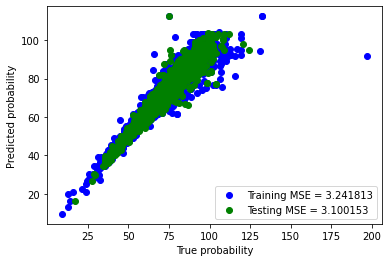

In [246]:
################ Code #################
#torch.save(model.state_dict(), "{}/gcn1_model_{}.pt".format(mydrive, 500))
device = 'cuda:0'
mydict=torch.load(f'{mydrive}/gcn1_model_500.pt')
model=GNN(n_convs=4,n_embed=128).to(device)
model.load_state_dict(mydict)

from sklearn.metrics import mean_squared_error

def itr_merge(*itrs):
    for itr in itrs:
        for v in itr:
            yield v

def evaluate(model, dataloader, dataloader2, device):
    '''
    A function to return the classification probabilities and true labels (for evaluation). 
    
    Args: 
        model (torch.nn.Module): your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        device (str): Your device
        
    Returns: 
        (np.array, np.array): true labels, predicted probabilities
    '''
      
    pred_prob = []
    labels = []
    losses = []
    with torch.no_grad():
        model.eval()
        for batch in dataloader:
            epoch_loss = []
            AtomicNum,Edge,Natom,label = batch

            AtomicNum = AtomicNum.to(device)
            Edge = Edge.to(device)
            # Natom = Natom.to(device)
            label = label.to(device)
            # evaluate your model here
            model.eval()
            y_pred = model(AtomicNum,Edge,Natom)
            batch_loss = (y_pred-label).pow(2).mean() # MSE loss
            batch_loss = batch_loss.cpu().detach().numpy()
            losses.append(batch_loss)
            label = label.cpu().detach().numpy()
            y_pred = y_pred.cpu().detach().numpy()
            pred_prob.append(y_pred)
            labels.append(label)
        if dataloader2 != 0:
            for batch in dataloader2:
              epoch_loss = []
            AtomicNum,Edge,Natom,label = batch
            AtomicNum = AtomicNum.to(device)
            Edge = Edge.to(device)
            # Natom = Natom.to(device)
            label = label.to(device)
            # evaluate your model here
            model.eval()
            y_pred = model(AtomicNum,Edge,Natom)
            batch_loss = (y_pred-label).pow(2).mean() # MSE loss
            batch_loss = batch_loss.cpu().detach().numpy()
            losses.append(batch_loss)
            label = label.cpu().detach().numpy()
            y_pred = y_pred.cpu().detach().numpy()
            pred_prob.append(y_pred)
            labels.append(label)

    return labels, pred_prob

training_labels, training_pred = evaluate(model, train_loader, val_loader, device)
testing_labels, testing_pred= evaluate(model, test_loader, 0, device)

training_y = [item for sublist in training_labels for item in sublist]
training_y_pred = [item for sublist in training_pred for item in sublist]
test_y = [item for sublist in testing_labels for item in sublist]
test_y_pred = [item for sublist in testing_pred for item in sublist]

training_loss = ((np.array(training_y)-np.array(training_y_pred))**2).mean(axis=None)
testing_loss = ((np.array(test_y)-np.array(test_y_pred))**2).mean(axis=None)

import matplotlib.pyplot as plt

a = "Training MSE = %f" % (training_loss)
b = "Testing MSE = %f" % (testing_loss)

plt.scatter(training_y, training_y_pred, c ="blue", label = a)
plt.scatter(test_y, test_y_pred, c ="green", label = b)
plt.legend()
plt.xlabel('True probability')
plt.ylabel('Predicted probability')
plt.show()


## Part 2: Variational auto-encoders for SMILES strings

In [248]:
# Get data 
! wget https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps4/data/zinc_50k.csv
    
# Get pretrained model
! wget -O vae_checkpoint.pth https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps4/pretrained_checkpoints/vae-050-0.06.pth

--2022-04-08 21:33:01--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps4/data/zinc_50k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2504809 (2.4M) [text/plain]
Saving to: ‘zinc_50k.csv.1’

zinc_50k.csv.1      100%[===================>]   2.39M  --.-KB/s    in 0.05s   

2022-04-08 21:33:01 (49.1 MB/s) - ‘zinc_50k.csv.1’ saved [2504809/2504809]

--2022-04-08 21:33:02--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps4/pretrained_checkpoints/vae-050-0.06.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
H

### 2.1 (5 points) One-hot encode SMILES strings into padded numerical vectors

In [249]:
from sklearn import preprocessing

# Character list for SMILES string
moses_charset = ['2', 'o', 'C', 'I', 'O', 'H', 'n', 'N', '=', '+', '#', '-', 'c',
                 'B', 'l', '7', 'r', 'S', 's', '4', '6', '[', '5', ']', 'F', '3', 
                 'P', '(', ')', '1', ' ']

# Define encoder 
enc = preprocessing.LabelEncoder().fit(moses_charset)

# Read data 
df = pd.read_csv("./zinc_50k.csv")




Encode SMILES strings into padded categorical vectors.

In [287]:
################ Code #################
unpad_smiles = list(df['SMILES'])
max_smile_len = len(max(unpad_smiles, key=len))

smiles = []

for smile in unpad_smiles:
  smiles.append(smile.ljust(max_smile_len,' '))

smiles_enc = torch.Tensor([np.transpose(np.squeeze([enc.transform([char]) for char in smile])) for smile in smiles]).type(torch.LongTensor)


print(smiles_enc.shape)


torch.Size([50000, 54])


Make train/validation/test Datasets and DataLoaders.

In [283]:
################ Code #################
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
X_train_and_val, X_test,a,b = train_test_split(smiles_enc, smiles_enc, test_size=0.2)
X_train, X_val,a,b= train_test_split(X_train_and_val, X_train_and_val, test_size=0.25)

train_data = torch.utils.data.TensorDataset(X_train)
val_data = torch.utils.data.TensorDataset(X_val)
test_data = torch.utils.data.TensorDataset(X_test)

batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


### 2.2 (14 points) Implement the Reparametrization Trick for VAE

In [252]:
# Molecular VAE model 

class MolVAE(nn.Module):
    def __init__(self,  rnn_enc_hid_dim, enc_nconv,
                         encoder_hid, z_dim, 
                         rnn_dec_hid_dim, dec_nconv, smiles_len, nchar
                         ):
        '''
            SMILES VAE model 
            
                rnn_enc_hid_dim: hidden dimension for the GRU encoder 
                enc_nconv: number of recurrent layers for the GRU decoder
                encoder_hid: dimension of GUR encoder readout
                z_dim: number of latent variable 
                rnn_dec_hid_dim: hidden dimension for the GRU decoder 
                dec_nconv: number of recurrent layers for the GRU decoder
                smiles_len: total length of padded SMILES string 
                nchar: number of possible characters 
                
        '''
        
        super(MolVAE, self).__init__()
        
        self.smiles_len = smiles_len
        self.nchar = nchar
        # Embedding layer
        self.embed = nn.Embedding(self.nchar, rnn_enc_hid_dim)
        # Encoding GRU
        self.rnn_enc = nn.GRU(rnn_enc_hid_dim, rnn_enc_hid_dim, enc_nconv, batch_first=True)
        # MLP to transfrom hidden output from Encoding GRU
        self.mlp0 = nn.Linear(rnn_enc_hid_dim, encoder_hid)
        # Network to parametrize mu
        self.mu_network = nn.Linear(encoder_hid, z_dim)
        # Network to parametrize log variance
        self.logvar_network = nn.Linear(encoder_hid, z_dim)
        # Decoding GRU
        self.rnn_dec = nn.GRU(z_dim, rnn_dec_hid_dim, dec_nconv, batch_first=True)
        # Output SMILES characters
        self.readout = nn.Linear(rnn_dec_hid_dim, self.nchar)

    def encode(self, x):
        '''Output mean and log variance of the encoded SMILES'''
        output, hn = self.rnn_enc(x)
        h = torch.nn.functional.relu(self.mlp0(hn[-1]))
        return self.mu_network(h), self.logvar_network(h)
    
    def get_std(self, logvar):
        '''Transform log variance to standard deviation'''
        ################ Code #################
        std = torch.exp(0.5 * logvar)
        return std
        ################ Code #################

    def reparametrize(self, mu, std):
        '''The reparametrization trick'''
        device = 'cuda:0'
        if self.training:
            ################ Code #################
            #z = torch.sum(mu,1).to(device) + torch.randn(std.shape[0]).to(device)*torch.sum(std,1).to(device)
            z = mu.to(device) + torch.randn(list(std.shape)).to(device)*std.to(device)
            return z

           ################ Code ################# 
        else:
            return mu

    def decode(self, z):
        '''Decoder to reconstruct latent variable back to SMILES'''
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, self.smiles_len, 1)
        out, h = self.rnn_dec(z)
        out_reshape = out.contiguous().view(-1, out.size(-1))
        
        y0 = self.readout(out_reshape)
        y = y0.contiguous().view(out.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        x_embed = self.embed(x) # Get SMILES embedding 
        mu, logvar = self.encode(x_embed) # Encoding SMILES to latent representations 
        std = self.get_std(logvar) # Transform log variance to std.
        z = self.reparametrize(mu, std) # Reparametrization trick 
        smiles_recon = self.decode(z)  # Reconstruct SMILES string 
        return smiles_recon, mu, std

Test your model by comparing your sampling with N(0, 1).

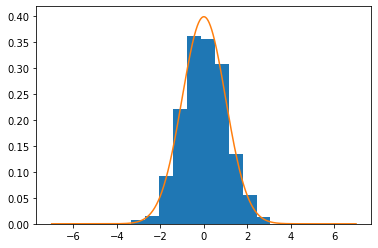

In [253]:
# Define your model 
model = MolVAE(rnn_enc_hid_dim=256, enc_nconv=1, 
                     encoder_hid=256, z_dim=128, rnn_dec_hid_dim=512,
                    dec_nconv=3, nchar=31, smiles_len=max_smile_len)

# Compare your sampling with N(0, 1)

import matplotlib.pyplot as plt
from scipy.stats import norm

sample = model.reparametrize(torch.zeros(1000), torch.ones(1000))
plt.hist(sample.detach().cpu().numpy(), density=True)

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-7, 7, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,1)) # Mean = 0, SD = 1.
plt.show()


### 2.3 (14 points) Implement the SMILES VAE loss function

Implement your loss function here.

In [254]:
def loss_function(recon_x, x, mu, std):
    ################ Code #################
 # xshape (512, 54)
# recon shape(512, 54, 31) (num ex, seq len, num chars)
    N_batch = x.shape[0]
    L_recon = nn.functional.cross_entropy(torch.transpose(recon_x, 2,1), x)  # reconstruction loss 

    L_kl = (1/N_batch) * 0.5* torch.sum(torch.sum(std**2 + mu**2 - torch.log(std**2) -1, dim=1)) # KL loss

    return L_recon, L_kl



In [191]:
a = np.array([[[1,2,3],[4,5,6]]])
print(np.argmax(a))

5


### 2.4 (2 points) Train your model

Run the following cells to train your model.

In [255]:


def loop(model, loader, epoch, beta=0.001, evaluation=False):
    '''
        Train/test your VAE model
    '''
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'
    batch_losses = []
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))

    for data in tqdm_data:
        x = data[0].to(device)
        recon_batch, mu, std = model(x)
        loss_recon, loss_kl = loss_function(recon_batch, x, mu, std)
        loss = loss_recon + beta * loss_kl     
        
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['recon loss={:.3f}'.format(loss_recon.item()) ,
                   'KL loss={:.3f}'.format(loss_kl.item()) ,
                   'total loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()

In [256]:
device = 0

model = MolVAE(rnn_enc_hid_dim=367, enc_nconv=2, 
                     encoder_hid=512, z_dim=171, rnn_dec_hid_dim=512,
                    dec_nconv=1, nchar=31, smiles_len=max_smile_len)
                      
model = model.to(device)

# load pretrained model 
model.load_state_dict(torch.load("./vae_checkpoint.pth"))

<All keys matched successfully>

In [257]:
optimizer = optim.Adam(model.parameters(),lr=5e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

In [258]:
epochs = 50
for epoch in range(0, epochs):
    
    train_loss = loop(model, train_loader, epoch, 0.001)
    val_loss = loop(model, val_loader, epoch, 0.001,  evaluation=True)
    scheduler.step(val_loss)
    
    # optional: save model 
    # if epoch == 50:
    #     torch.save(model.state_dict(),
    #             './{}/vae-{:03d}-{:.2f}.pth'.format(mydrive, epoch, train_loss))
        
    #     torch.save(optimizer.state_dict(),
    #         './{}/optim-{:03d}-{:.2f}.pth'.format(mydrive, epoch, train_loss))

    if epoch == 0:
        best_loss = train_loss.item()
    else:
        if train_loss.item() < best_loss:
            best_loss = train_loss.item()

trained_model = model

eval (epoch #1):  75%|███████▌  | 15/20 [00:00<00:00, 23.92it/s, recon loss=0.025 KL loss=121.115 total loss=0.146 avg. loss=0.148]


KeyboardInterrupt: ignored

### 2.5 (10 points) Sample new molecules

Some helper functions for you.

In [259]:
# save trained model
# torch.save(model.state_dict(),
#                 '{}/vae-{:03d}-{:.2f}.pth'.format(mydrive, epoch, train_loss))
# torch.save(optimizer.state_dict(),
#             '{}/optim-{:03d}-{:.2f}.pth'.format(mydrive, epoch, train_loss))

def index2smiles(mol_index, enc):
    '''Transform your array of character indices back to SMILES'''
    smiles_charlist = enc.inverse_transform(np.array(mol_index))
    smiles = ''.join(smiles_charlist).strip(" ")
    
    return smiles

def check_smiles_valid(smiles):
    '''Check if SMILES string is valid'''
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        valid = True 
    else:
        valid = False 
    return valid

Randomly select two SMILES in your test data, interpolate 10 points between them, and decode those points. Test them for accuracy and draw the scatter plot of the lower 2 dimensions. Then visualize any molecules that worked.

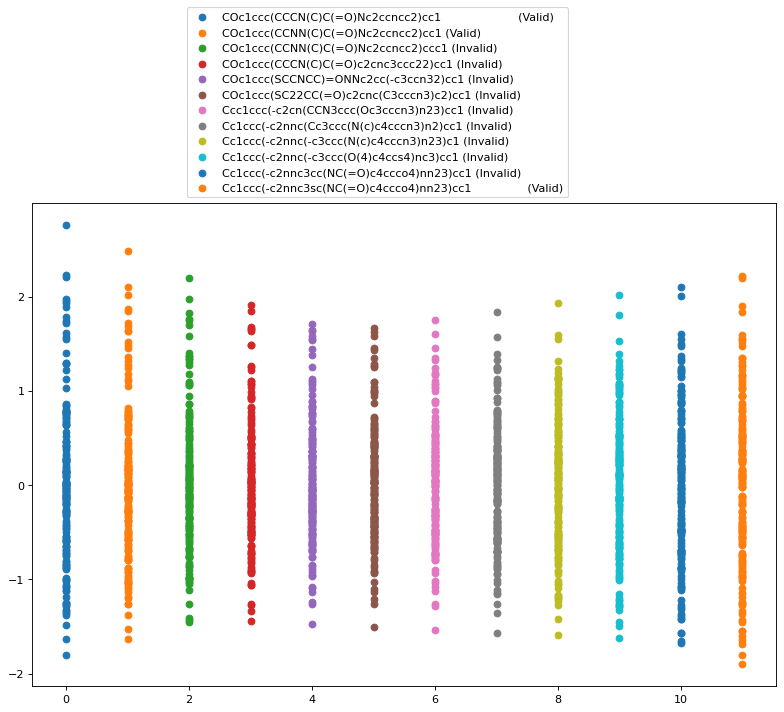

In [296]:
################ Code #################
import random
# select a starting and ending molecule (smile string)
start = index2smiles(test_loader.dataset.__getitem__(random.choices(range(len(test_loader.dataset)), k=1))[0].numpy().reshape(-1), enc)
end = index2smiles(test_loader.dataset.__getitem__(random.choices(range(len(test_loader.dataset)), k=1))[0].numpy().reshape(-1), enc)

start = start.ljust(max_smile_len,' ')
end = end.ljust(max_smile_len,' ')
#encode smile strings
start_enc = torch.Tensor([np.transpose(np.squeeze([enc.transform([char]) for char in start]))]).type(torch.LongTensor).to(device)
end_enc = torch.Tensor([np.transpose(np.squeeze([enc.transform([char]) for char in end]))]).type(torch.LongTensor).to(device)

model.eval()

#reconstruct smiles encodings
s_recon, s_mu, s_std = trained_model(start_enc)
e_recon, e_mu, e_std = trained_model(end_enc)

# calculate z
z_start = s_mu.to(device) + torch.randn(list(s_std.shape)).to(device)*s_std.to(device)
z_end = e_mu.to(device) + torch.randn(list(e_std.shape)).to(device)*e_std.to(device)

interp_encs = [] #for ploting
legends = []
interp_tensors = []
#calculate weights for interpolation
weights = np.linspace(0,1,11, endpoint=False)[1:11]

for weight in weights:
  interp_tensor = torch.lerp(z_start,z_end,weight) #yields a new z
  interp_tensors.append(interp_tensor.cpu().detach().numpy())
  interp_pre_enc = trained_model.decode(interp_tensor).cpu().detach().numpy() # latent z back to encoding (1X54X31)
  # interp_pre_enc = trained_model.decode(interp_tensor)
  # m = nn.Softmax(dim=2)
  # test = m(interp_pre_enc)
  # print(test)
  interp_enc= np.argmax(interp_pre_enc,axis=2)[0]
  interp_smile = index2smiles(interp_enc,enc)

  if check_smiles_valid(interp_smile):
    legend = interp_smile + " (Valid)"
    legends.append(legend)
  else:
    legend = interp_smile + " (Invalid)"
    legends.append(legend)


import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)

z_start = z_start.cpu().detach().numpy()[0]
plt.scatter(np.zeros(len(z_start)),z_start, label = start + ' (Valid)')
i = 0
for legend in legends:
  plt.scatter(i+1*np.ones(len(z_start)), interp_tensors[i], label = legend)
  i = i +1
plt.scatter(11*np.ones(len(z_start)), z_end.cpu().detach().numpy()[0], label = end + ' (Valid)')

plt.legend(bbox_to_anchor =(0.2, 1))
plt.show()

Why does the VAE sometimes fail to generate valid SMILES strings?

In [ ]:
# It is likely because of the numbers of examples the model was trained on. With more examples, it would confine the latent dimension
#values such that would be more likely to correspond to valid SMILES